# Part 2: Advanced experiments (coursework 4)
In the second part of the project you will explore more advanced approaches for the dataset you have chosen
to work, based on your plan presented in the Further Work section of Part 1. For example, you may wish
to explore different network architectures (for example, recurrent networks or convolutional networks), more
advanced approaches to regularisation (for example there have been many variants of dropout proposed), the
use of the variable length song data for music genre classification, trying to learn specific invariances for object
classification, or the use of teacher-student approaches. There are of course many possibilites! It is a good idea
if you can use your results in part 1 as a baseline against which you can compare your results in this part.

However please choose an approach which takes account of the constraints regarding time (you have 3–4 weeks
for part 2, and you will be doing other courses) and available compute resources (we can provide access to a
shared CPU cluster - the scutter cluster used in Extreme Computing - but cannot offer GPU access for this
course). It is perfectly reasonable, for example, to set a constraint whereby you limit yourself to experiments
with a training time below a certain threshold.

Your final report should present the research questions that you investigate, and the experiments you designed
and carried out; you should also concisely describe the baseline systems developed in phase 1. You should
present the results clearly and concisely, comparing to your baseline systems and provide a discussion of the
results, with conclusions related to the research questions. The conclusions section might propose some further
work based on the results of this mini-project.

Coursework 4 is worth 40% of the overall mark. The marking scheme is as follows:
- Research questions to be investigated (10 marks). Clear presentation of the research questions you are
exploring, and the experiments you designed to address these questions.
- Methods (30 marks). Clear presentation of the methods (network architectures, learning schedules, etc.)
that were used, and an outline of how they were implemented in TensorFlow.
- Results and discussion (40 marks). Clear presentation of results, discussion and interpretation of results,
conclusions, further work.
- Presentation and clarity of report (20 marks). Marks awarded for overall structure, clear and concise

presentation, providing enough information to enable work to be reproduced, clear and concise presentation
of results, informative discussion and conclusions.
Please note that a concise description of the baseline systems developed in part 1 is required, but will not
contribute to the numeric mark.

## Resources
- https://www.tensorflow.org/tutorials/layers
- https://www.tensorflow.org/tutorials/deep_cnn
- https://www.tensorflow.org/get_started/mnist/pros
- https://github.com/tensorflow/models/blob/master/tutorials/image/cifar10/cifar10.py
- https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/convolutional_network.ipynb
- http://danijar.com/structuring-your-tensorflow-models/
- http://cs231n.github.io/convolutional-networks/
- https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/06_CIFAR-10.ipynb
- http://neuralnetworksanddeeplearning.com/chap6.html

Fix directories.

In [2]:
import os

if 'fixed_dirs' not in locals():
    
    print 'fixing directories...'
    
    # Change working directory to mlpractical within Google Drive
    old_wd = os.getcwd()  # '/Users/sipola/Google Drive/mlpractical/notebooks'
    print 'old_wd: {}'.format(old_wd)
    new_wd = '/Users/sipola/Google Drive/mlpractical'
    print 'new_wd: {}'.format(new_wd)
    os.chdir(new_wd)
    
    # Fix data directory
    print 'old MLP_DATA_DIR: {}'.format(os.environ['MLP_DATA_DIR'])
    os.environ['MLP_DATA_DIR'] = '/Users/sipola/Google Drive/education/coursework/graduate/edinburgh/mlp/data'
    print 'new MLP_DATA_DIR: {}'.format(os.environ['MLP_DATA_DIR'])
    
    # Confirm directories have been fixed
    fixed_dirs = True

fixing directories...
old_wd: /Users/sipola/Google Drive/mlpractical/notebooks
new_wd: /Users/sipola/Google Drive/mlpractical
old MLP_DATA_DIR: /Users/sipola/mlpractical/data
new MLP_DATA_DIR: /Users/sipola/Google Drive/education/coursework/graduate/edinburgh/mlp/data


In [3]:
import datetime
import tensorflow as tf
import numpy as np
from mlp.data_providers import CIFAR10DataProvider, CIFAR100DataProvider
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import OrderedDict
# import seaborn as sns
import pandas as pd
import pickle
import time
import re
import collections
from decimal import Decimal
%matplotlib inline

/Users/sipola/miniconda2/envs/mlp/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
save_path_main = 'run/coursework4/'

def create_and_return_path(folder_name,
                           save_path_main,
                           date_as_str = datetime.datetime.today().strftime('%Y-%m-%d')):
    save_path = os.path.join(save_path_main, folder_name, date_as_str)
    print 'path created: ' + save_path
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    return save_path

def clear_dir(folder):
    print 'deleting files in: ' + folder
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            #elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e)

In [5]:
use_cifar_10 = True

batch_size = 50

if use_cifar_10:
    train_data = CIFAR10DataProvider('train', batch_size=batch_size)
    valid_data = CIFAR10DataProvider('valid', batch_size=batch_size)
else:
    train_data = CIFAR100DataProvider('train', batch_size=batch_size)
    valid_data = CIFAR100DataProvider('valid', batch_size=batch_size)

for input_batch, target_batch in train_data:
    num_classes = target_batch.shape[1]
    break

In [6]:
image_shape = [-1,32,32,3]

In [79]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME')


def max_pool_kxk(x, k_width, stride):
    return tf.nn.max_pool(x, ksize=[1, k_width, k_width, 1], strides=[1, stride, stride, 1], padding='SAME')


def batch_normalization(layer):
    
    # Save original shape of layer and determine if it has the dimensionality of an image
    orig_layer_shape = [-1] + layer.get_shape().as_list()[1:]
    is_image = len(orig_layer_shape) == 4
    
    # Get flattened dimension
    dim = np.prod(orig_layer_shape[1:])
    
    if is_image:
        # Flatten
        layer = tf.reshape(layer, [-1, dim])
    
    epsilon = 1e-6
    batch_mean1, batch_var1 = tf.nn.moments(layer, [0])
    z1_hat = (layer - batch_mean1) / tf.sqrt(batch_var1 + epsilon)
    scale1 = tf.Variable(tf.ones([dim]))
    beta1 = tf.Variable(tf.zeros([dim]))
    layer_norm = tf.nn.batch_normalization(layer, batch_mean1, batch_var1, beta1, scale1, epsilon)
    
    if is_image:
        # Convert back to image shape
        layer_norm = tf.reshape(layer_norm, orig_layer_shape)
    
    return layer_norm


def batch_normalization(layer):
    
    '''
    Perform batch normalization on a layer. The layer argument can be a 4-D tensor or a flattened layer.
    
    Input:
        layer: TensorFlow layer object
    Output:
        batch-normalized layer
    '''
    
    # Save original shape of layer and determine if it has the dimensionality of an image.
    orig_layer_shape = [-1] + layer.get_shape().as_list()[1:]
    is_image = len(orig_layer_shape) == 4
    
    if is_image:
        # Use separate function for 4-D tensors.
        return tf.nn.lrn(layer)
    
    dim = np.prod(orig_layer_shape[1:])  # Get flattened dimension
    epsilon = 1e-6
    batch_mean1, batch_var1 = tf.nn.moments(layer, [0])
    z1_hat = (layer - batch_mean1) / tf.sqrt(batch_var1 + epsilon)
    scale1 = tf.Variable(tf.ones([dim]))
    beta1 = tf.Variable(tf.zeros([dim]))
    layer_norm = tf.nn.batch_normalization(layer, batch_mean1, batch_var1, beta1, scale1, epsilon)
    
    return layer_norm

def conv_layer(x_image, num_input_channels, filter_size, num_filters, conv_stride, batch_norm):
    conv_shape = [filter_size, filter_size, num_input_channels, num_filters]
    W_conv = weight_variable(conv_shape)
    b_conv = bias_variable([num_filters])  # last element of weights gives bias length
    h_conv = conv2d(x_image, W_conv, conv_stride) + b_conv
    if batch_norm:
        h_conv = batch_normalization(h_conv)
    h_conv = tf.nn.relu(h_conv)
    return h_conv


def pool_layer(h_conv, pool_k_width, pool_stride):
    h_pool = max_pool_kxk(h_conv, pool_k_width, pool_stride)
    return h_pool


def fc_layer(x, num_inputs, num_outputs, batch_norm):
    weights = weight_variable([num_inputs, num_outputs])
    biases = bias_variable([num_outputs])
    layer = tf.matmul(x, weights) + biases
    if batch_norm:
        layer = batch_normalization(layer)
    layer = tf.nn.relu(layer)
    return layer


def run_cnn_model_annoying(params, save_path):
    
    # It's "annoying" in that keyboard interrupt produces a long error message.
    # See run_cnn_model, which is a wrapper for this function.

    optimizer = tf.train.AdamOptimizer(params['learning_rate'])

    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
    
    # First convolutional/pooling layer
    with tf.name_scope('conv_pool_layer_1'):
        x_image = tf.reshape(inputs, image_shape)
        h_conv1a = conv_layer(x_image,
                             num_input_channels=3,
                             filter_size=params['conv1_filter_size'],
                             num_filters=params['conv1_num_filters'],
                             conv_stride=params['conv1_stride'],
                             batch_norm=params['conv_batch_norm'])
        h_pool1 = pool_layer(h_conv1a,
                             pool_k_width=params['pool1_k_width'],
                             pool_stride=params['pool1_stride'])

    # Second convolutional/pooling layer
    with tf.name_scope('conv_pool_layer_2'):
        h_conv2a = conv_layer(h_pool1,
                             num_input_channels=params['conv1_num_filters'],
                             filter_size=params['conv2_filter_size'],
                             num_filters=params['conv2_num_filters'],
                             conv_stride=params['conv2_stride'],
                             batch_norm=params['conv_batch_norm'])
        h_pool2 = pool_layer(h_conv2a,
                             pool_k_width=params['pool2_k_width'],
                             pool_stride=params['pool2_stride'])

    # Get number of dimensions for reshaping (used in flatten layer and fully connected layer 1)
    dim = np.prod(h_pool2.get_shape()[1:]).value

    # Flatten layer
    with tf.name_scope('flatten_layer'):
        h_pool2_flat = tf.reshape(h_pool2, [-1, dim])

    # Apply dropout
    with tf.name_scope('dropout_layer'):
        keep_prob = tf.placeholder(tf.float32)
        h_pool2_drop = tf.nn.dropout(h_pool2_flat, keep_prob)

    # Densely connected layer 1
    with tf.name_scope('dense_layer1'):
        h_fc1 = fc_layer(h_pool2_drop,
                         dim,
                         params['fc1_num_outputs'],
                         batch_norm=params['fc_batch_norm'])

    # Densely connected layer 2
    with tf.name_scope('dense_layer2'):
        h_fc2 = fc_layer(h_fc1,
                         params['fc1_num_outputs'],
                         params['fc2_num_outputs'],
                         batch_norm=params['fc_batch_norm'])

    # Readout layer
    with tf.name_scope('readout_layer'):
        W_fc3 = weight_variable([params['fc2_num_outputs'], num_classes])
        b_fc3 = bias_variable([num_classes])
        outputs = tf.matmul(h_fc2, W_fc3) + b_fc3

    # Error and accuracy
    with tf.name_scope('error'):
        error = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(
                tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
                tf.float32))

    with tf.name_scope('train'):
        train_step = optimizer.minimize(error)

    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:

        sess.run(init)
        t0 = time.time()

        for e in range(num_epoch):

            t0_epoch = time.time()

            # Training
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, keep_prob: params['keep_prob']})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches

            # Validation
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch, targets: target_batch, keep_prob: 1.0})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches

            print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f} err(valid)={3:.2f} acc(valid)={4:.2f} time={5:.2f} min'
                  .format(e + 1, running_error, running_accuracy, valid_error, valid_accuracy, (time.time()-t0_epoch)/60))

            # Store metrics
            stats_one['err(train)'].append(running_error)
            stats_one['acc(train)'].append(running_accuracy)
            stats_one['err(valid)'].append(valid_error)
            stats_one['acc(valid)'].append(valid_accuracy)

    plot_and_save_figures(stats_one, iter_str, num_epoch, save_path)

    stats_one['time'] = time.time() - t0

    return stats_one


def run_cnn_model(params, save_path):
    try:
        return run_cnn_model_annoying(params, save_path)
    except KeyboardInterrupt:
        print '***KeyboardInterrupt***'  # to avoid the printing of annoying error message

        
def plot_and_save_figures(stats_one, iter_str, num_epoch, save_path):

    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['err(train)', 'err(valid)']:
        ax_1.plot(np.arange(1, num_epoch + 1), 
                  stats_one[k], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')
    fig_1.suptitle(iter_str)

    plt.savefig(os.path.join(save_path, 'error_' + iter_str + '.pdf'))

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, num_epoch + 1), 
                  stats_one[k], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    fig_2.suptitle(iter_str)

    plt.savefig(os.path.join(save_path, 'acc_' + iter_str + '.pdf'))

    plt.show()

# Plot basic iter graph
def iter_graph(stats, path, fontsize=14, lwd=2):
    
    font = {'family' : 'normal',
            'weight' : 'normal',
            'size'   : fontsize}
    plt.rc('font', **font)
        
    # Plot stuff
    fig = plt.figure(figsize=(18, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    for iter_str, stats_sub in stats.iteritems():
        num_epoch = len(stats_sub.values()[0])
        label = '{}'.format(iter_str)
        ax1.plot(np.arange(1, num_epoch + 1), 
                 stats_sub['err(train)'], label=label, linewidth=lwd)
        ax2.plot(np.arange(1, num_epoch + 1), 
                 stats_sub['err(valid)'], label=label, linewidth=lwd)
    ax1.legend(loc=0)
    ax1.set_xlabel('Epoch number')
    ax1.set_ylabel('Training set error')
    ax1.set_yscale('log')
    ax2.legend(loc=0)
    ax2.set_xlabel('Epoch number')
    ax2.set_ylabel('Validation set error')
    ax2.set_yscale('log')

    plt.savefig(path)
    
def format_e(n):
    a = '%E' % n
    return a.split('E')[0].rstrip('0').rstrip('.') + 'e' + a.split('E')[1]

def print_stats(subdir, stats_key, function):
    stats = pickle.load(open(os.path.join(save_path_main, subdir, "stats.p"), "rb"))  # gets save_path_main from global
    for iter_str, values in stats.iteritems():
        print iter_str, function(values[stats_key])

## Batch normalization

path created: run/coursework4/cnn_batch_norm_lrn/2017-03-14
deleting files in: run/coursework4/cnn_batch_norm_lrn/2017-03-14
fc_batch_norm=True, conv_batch_norm=True

End of epoch 01: err(train)=1.65 acc(train)=0.42 err(valid)=1.45 acc(valid)=0.49 time=4.66 min
End of epoch 02: err(train)=1.32 acc(train)=0.54 err(valid)=1.33 acc(valid)=0.54 time=4.09 min
End of epoch 03: err(train)=1.17 acc(train)=0.59 err(valid)=1.25 acc(valid)=0.56 time=4.11 min
End of epoch 04: err(train)=1.06 acc(train)=0.63 err(valid)=1.20 acc(valid)=0.58 time=3.91 min
End of epoch 05: err(train)=0.96 acc(train)=0.67 err(valid)=1.18 acc(valid)=0.59 time=3.68 min
End of epoch 06: err(train)=0.87 acc(train)=0.71 err(valid)=1.17 acc(valid)=0.59 time=4.12 min
End of epoch 07: err(train)=0.79 acc(train)=0.74 err(valid)=1.17 acc(valid)=0.59 time=4.39 min
End of epoch 08: err(train)=0.71 acc(train)=0.77 err(valid)=1.17 acc(valid)=0.60 time=3.99 min
End of epoch 09: err(train)=0.63 acc(train)=0.79 err(valid)=1.19 acc(vali

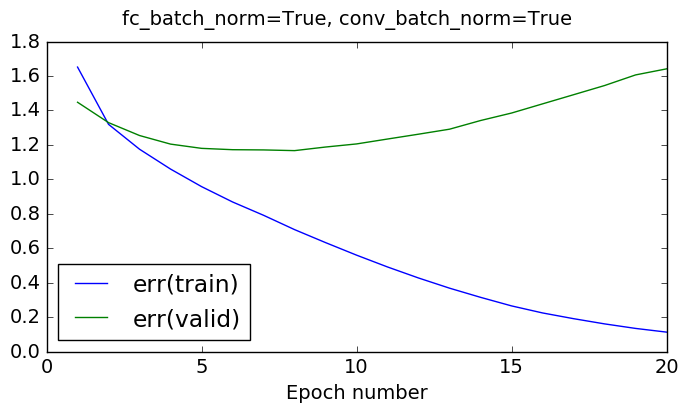

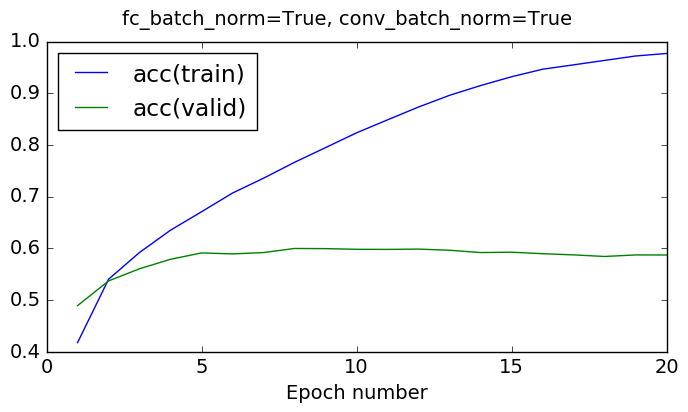

fc_batch_norm=False, conv_batch_norm=True

End of epoch 01: err(train)=1.80 acc(train)=0.35 err(valid)=1.57 acc(valid)=0.43 time=3.95 min
End of epoch 02: err(train)=1.49 acc(train)=0.47 err(valid)=1.44 acc(valid)=0.48 time=4.34 min
End of epoch 03: err(train)=1.38 acc(train)=0.51 err(valid)=1.38 acc(valid)=0.51 time=3.93 min
End of epoch 04: err(train)=1.31 acc(train)=0.54 err(valid)=1.31 acc(valid)=0.54 time=4.14 min
End of epoch 05: err(train)=1.25 acc(train)=0.56 err(valid)=1.27 acc(valid)=0.55 time=3.67 min
End of epoch 06: err(train)=1.20 acc(train)=0.58 err(valid)=1.23 acc(valid)=0.57 time=3.54 min
End of epoch 07: err(train)=1.15 acc(train)=0.60 err(valid)=1.21 acc(valid)=0.57 time=3.54 min
End of epoch 08: err(train)=1.11 acc(train)=0.61 err(valid)=1.20 acc(valid)=0.58 time=3.56 min
End of epoch 09: err(train)=1.08 acc(train)=0.62 err(valid)=1.17 acc(valid)=0.59 time=3.54 min
End of epoch 10: err(train)=1.04 acc(train)=0.64 err(valid)=1.14 acc(valid)=0.60 time=3.55 min
End of 

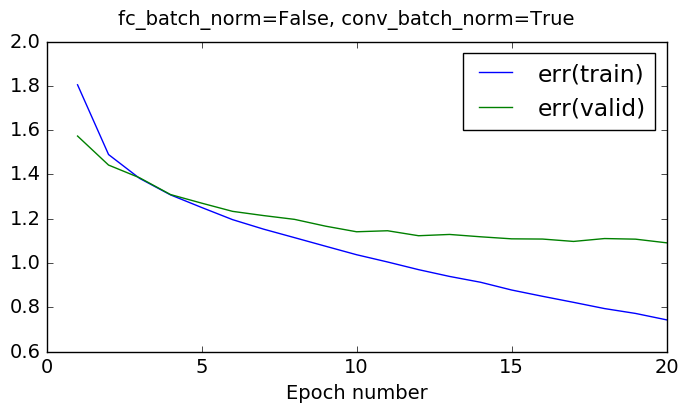

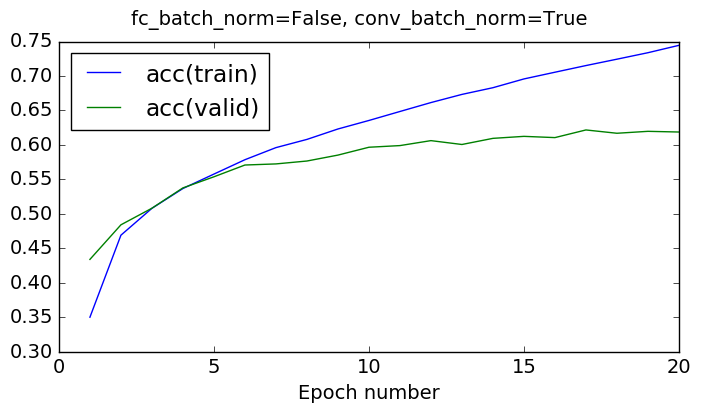

fc_batch_norm=True, conv_batch_norm=False

End of epoch 01: err(train)=1.66 acc(train)=0.42 err(valid)=1.46 acc(valid)=0.49 time=2.21 min
End of epoch 02: err(train)=1.34 acc(train)=0.53 err(valid)=1.33 acc(valid)=0.54 time=2.21 min
End of epoch 03: err(train)=1.19 acc(train)=0.58 err(valid)=1.26 acc(valid)=0.56 time=2.19 min
End of epoch 04: err(train)=1.08 acc(train)=0.63 err(valid)=1.20 acc(valid)=0.58 time=2.19 min
End of epoch 05: err(train)=0.99 acc(train)=0.66 err(valid)=1.18 acc(valid)=0.59 time=2.20 min
End of epoch 06: err(train)=0.91 acc(train)=0.69 err(valid)=1.15 acc(valid)=0.60 time=2.22 min
End of epoch 07: err(train)=0.83 acc(train)=0.72 err(valid)=1.15 acc(valid)=0.60 time=2.27 min
End of epoch 08: err(train)=0.76 acc(train)=0.75 err(valid)=1.15 acc(valid)=0.60 time=2.27 min
End of epoch 09: err(train)=0.69 acc(train)=0.77 err(valid)=1.15 acc(valid)=0.60 time=2.21 min
End of epoch 10: err(train)=0.63 acc(train)=0.80 err(valid)=1.16 acc(valid)=0.61 time=2.20 min
End of 

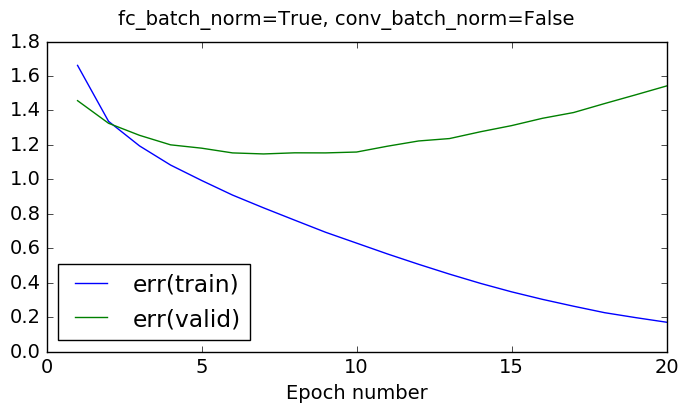

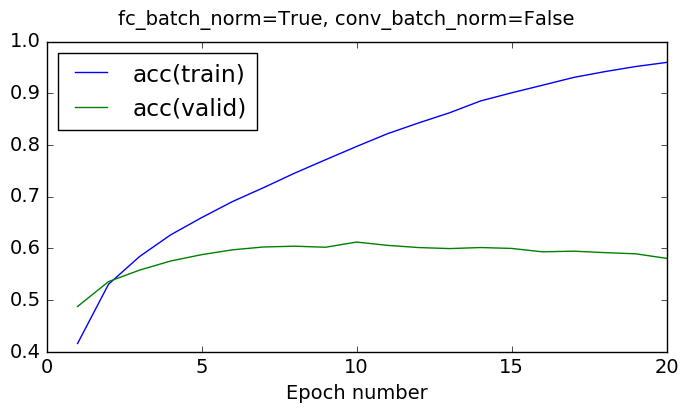

fc_batch_norm=False, conv_batch_norm=False

End of epoch 01: err(train)=1.81 acc(train)=0.36 err(valid)=1.62 acc(valid)=0.42 time=2.36 min
End of epoch 02: err(train)=1.51 acc(train)=0.47 err(valid)=1.50 acc(valid)=0.46 time=2.36 min
End of epoch 03: err(train)=1.40 acc(train)=0.50 err(valid)=1.40 acc(valid)=0.50 time=2.31 min
End of epoch 04: err(train)=1.32 acc(train)=0.53 err(valid)=1.34 acc(valid)=0.52 time=2.27 min
End of epoch 05: err(train)=1.26 acc(train)=0.56 err(valid)=1.33 acc(valid)=0.53 time=2.29 min
End of epoch 06: err(train)=1.21 acc(train)=0.58 err(valid)=1.28 acc(valid)=0.55 time=2.24 min
End of epoch 07: err(train)=1.16 acc(train)=0.59 err(valid)=1.21 acc(valid)=0.57 time=2.27 min
End of epoch 08: err(train)=1.13 acc(train)=0.61 err(valid)=1.21 acc(valid)=0.58 time=2.19 min
End of epoch 09: err(train)=1.09 acc(train)=0.62 err(valid)=1.18 acc(valid)=0.59 time=2.55 min
End of epoch 10: err(train)=1.06 acc(train)=0.63 err(valid)=1.17 acc(valid)=0.59 time=2.26 min
End of

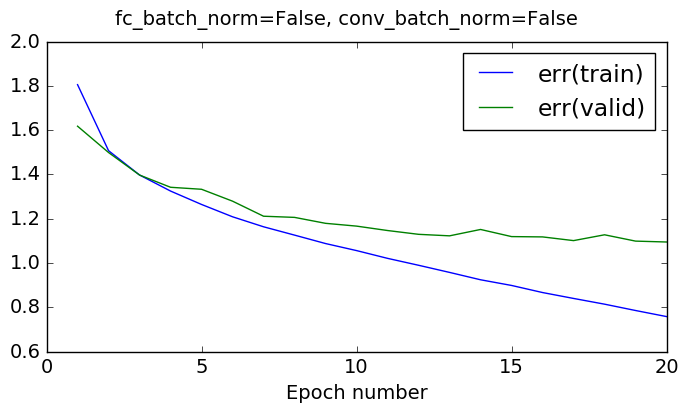

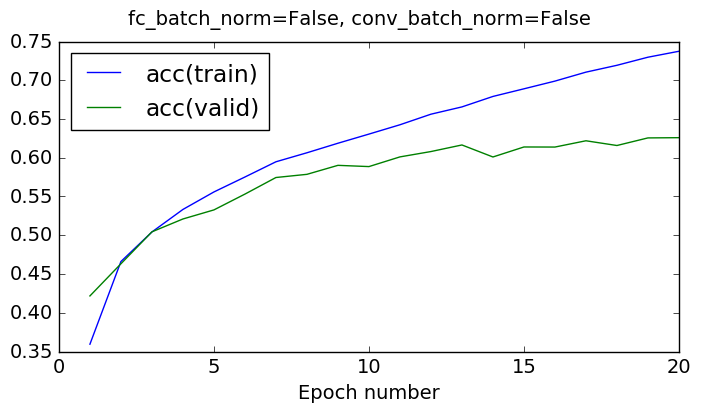

In [86]:
# Create directory (has suffix for today's date).
# Then DELETE all files in path if there are files already there.
subdir = 'cnn_batch_norm_lrn'
save_path = create_and_return_path(subdir, save_path_main)
clear_dir(save_path)

# Define hyperparameters
params = {
    'learning_rate': 1e-4,
    'conv1_filter_size': 3,
    'conv1_num_filters': 32,
    'conv1_stride': 1,
    'pool1_k_width': 2,
    'pool1_stride': 2,
    'conv2_filter_size': 3,
    'conv2_num_filters': 64,
    'conv2_stride': 1,
    'pool2_k_width': 2,
    'pool2_stride': 2,
    'fc1_num_outputs': 384,
    'fc2_num_outputs': 192,
    'keep_prob': 1.0,
    'fc_batch_norm': False,
    'conv_batch_norm': False
}

stats = OrderedDict()

num_epoch = 20

# iter_vars = [(False, False), (True, False), (False, True), (True, True)]
iter_vars = [(True, True), (False, True), (True, False), (False, False)]
iter_strs = ['fc_batch_norm={}, conv_batch_norm={}'.format(fc_batch_norm, conv_batch_norm)\
             for (fc_batch_norm, conv_batch_norm) in iter_vars]
if len(iter_vars) != len(iter_strs):
    print 'lengths DO NOT match. Bad!!!'

for iter_var, iter_str in zip(iter_vars, iter_strs):
    
    print '==========\n{}\n'.format(iter_str)
    stats_one = {'err(train)': [], 'acc(train)': [], 'err(valid)': [], 'acc(valid)': []}
    
    params['fc_batch_norm'] = iter_var[0]  # fc_batch_norm
    params['conv_batch_norm'] = iter_var[1]  # conv_batch_norm
    stats[iter_str] = run_cnn_model(params, save_path)
    
# Pickle all important objects
pickle.dump(stats, open(os.path.join(save_path_main, subdir, "stats.p"), "wb"))

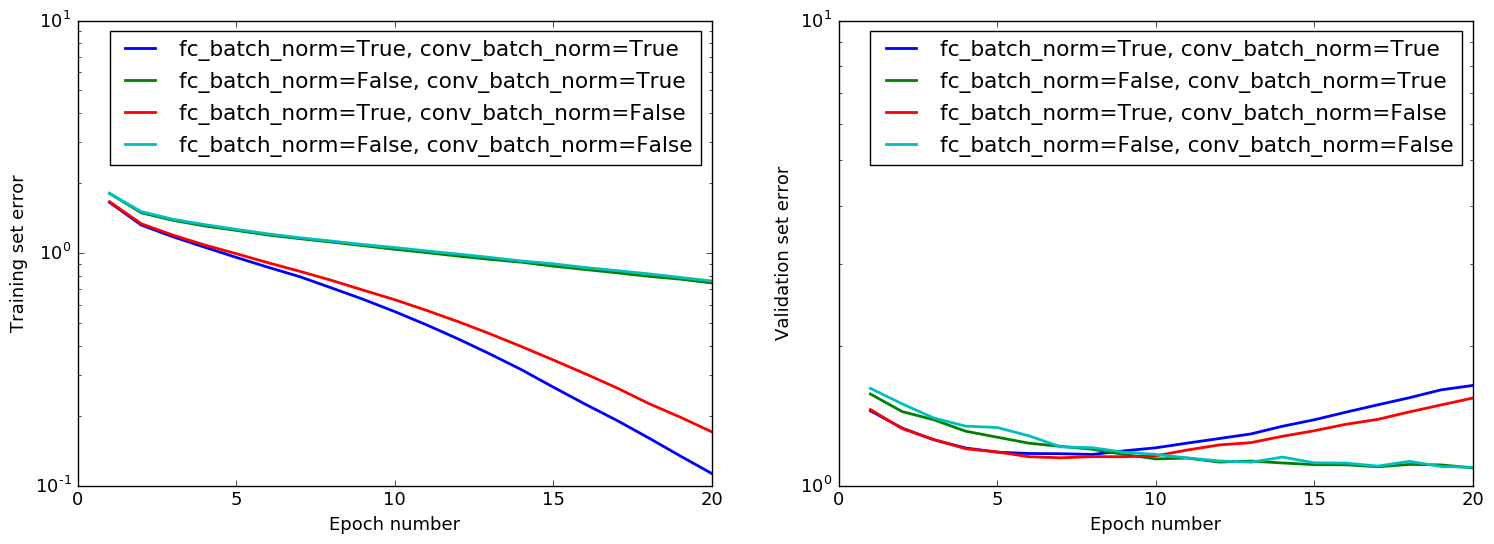

In [90]:
subdir = 'cnn_batch_norm_lrn'
stats = pickle.load(open(os.path.join(save_path_main, subdir, "stats.p"), "rb"))
iter_graph(stats, os.path.join(save_path, 'cnn_batch_norm.pdf'), fontsize=13)

path created: run/coursework4/cnn_batch_norm/2017-03-14


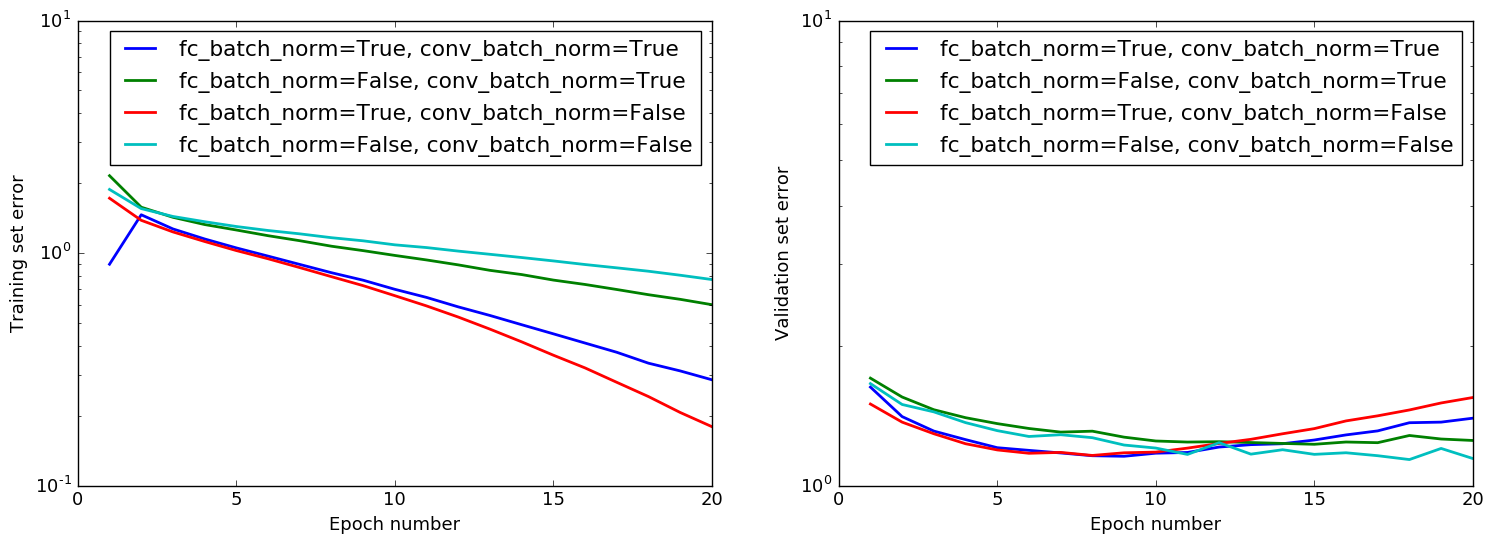

In [116]:
subdir = 'cnn_batch_norm'
stats = pickle.load(open(os.path.join(save_path_main, subdir, "stats.p"), "rb"))
save_path = create_and_return_path(subdir, save_path_main)
iter_graph(stats, os.path.join(save_path, 'cnn_batch_norm.pdf'), fontsize=13)

In [120]:
subdir = 'cnn_batch_norm'
stats = pickle.load(open(os.path.join(save_path_main, subdir, "stats.p"), "rb"))

iter_vars = [(True, True), (False, True), (True, False), (False, False)]
iter_strs = ['fc_batch_norm={}, conv_batch_norm={}'.format(fc_batch_norm, conv_batch_norm)\
             for (fc_batch_norm, conv_batch_norm) in iter_vars]

for iter_str, values in stats.iteritems():
    print iter_str, min(values['err(valid)'])

fc_batch_norm=True, conv_batch_norm=True 1.1557094115
fc_batch_norm=False, conv_batch_norm=True 1.22642434478
fc_batch_norm=True, conv_batch_norm=False 1.1604433468
fc_batch_norm=False, conv_batch_norm=False 1.13706977278


In [104]:
# # Create directory (has suffix for today's date).
# # Then DELETE all files in path if there are files already there.
# subdir = 'cnn_learning_rate'
# save_path = create_and_return_path(subdir, save_path_main)
# clear_dir(save_path)

# # Define hyperparameters
# params = {
#     'learning_rate': 1e-4,
#     'conv1_filter_size': 3,
#     'conv1_num_filters': 32,
#     'conv1_stride': 1,
#     'pool1_k_width': 2,
#     'pool1_stride': 2,
#     'conv2_filter_size': 3,
#     'conv2_num_filters': 64,
#     'conv2_stride': 1,
#     'pool2_k_width': 2,
#     'pool2_stride': 2,
#     'fc1_num_outputs': 384,
#     'fc2_num_outputs': 192,
#     'keep_prob': 1.0,
#     'fc_batch_norm': False,
#     'conv_batch_norm': False
# }

# stats = OrderedDict()

# num_epoch = 15

# iter_vars = [1e-3, 3e-3, 1e-2]
# iter_vars = iter_vars[::-1]  # just reversing; can comment this out
# iter_strs = ['learning_rate={}'.format(learning_rate) for learning_rate in iter_vars]
# if len(iter_vars) != len(iter_strs):
#     print 'lengths DO NOT match. Bad!!!'

# for iter_var, iter_str in zip(iter_vars, iter_strs):
    
#     print '==========\n{}\n'.format(iter_str)
#     stats_one = {'err(train)': [], 'acc(train)': [], 'err(valid)': [], 'acc(valid)': []}
    
#     params['learning_rate'] = iter_var
#     stats[iter_str] = run_cnn_model(params, save_path)
    
# # Pickle all important objects
# pickle.dump(stats, open(os.path.join(save_path_main, subdir, "stats.p"), "wb"))

path created: run/coursework4/cnn_learning_rate/2017-03-14
deleting files in: run/coursework4/cnn_learning_rate/2017-03-14
learning_rate=0.01

***KeyboardInterrupt***
learning_rate=0.003

***KeyboardInterrupt***
learning_rate=0.001



Exception KeyboardInterrupt in <bound method TF_Buffer.<lambda> of <tensorflow.python.pywrap_tensorflow.TF_Buffer; proxy of <Swig Object of type 'TF_Buffer *' at 0x14610d7e0> >> ignored


***KeyboardInterrupt***


Exception KeyboardInterrupt in <bound method TF_Buffer.<lambda> of <tensorflow.python.pywrap_tensorflow.TF_Buffer; proxy of <Swig Object of type 'TF_Buffer *' at 0x146f51f60> >> ignored


## Comparison with baseline

path created: run/coursework4/cnn_baseline/2017-03-14


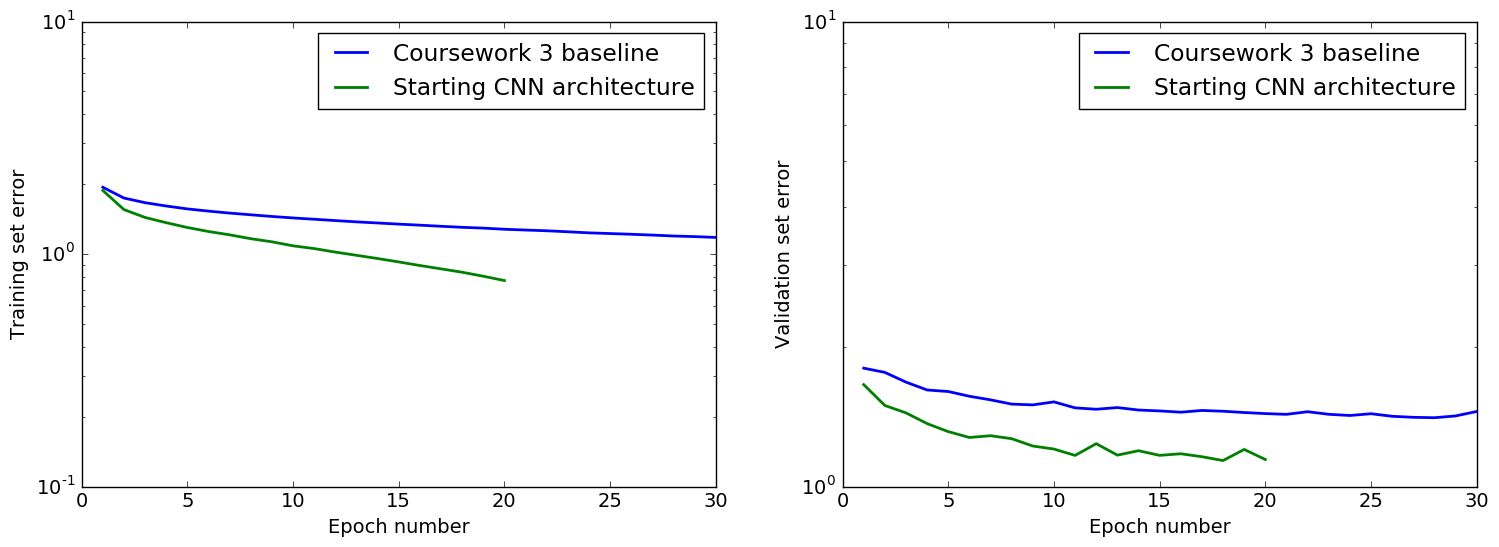

In [89]:
# Get stats from end of CW3 to compare with new CNN architecture.
stats_batch_norm = pickle.load(open(os.path.join(save_path_main, 'cnn_batch_norm', 'stats.p'), 'rb'))
stats_cw3 = pickle.load(open(os.path.join('/Users/sipola/Google Drive/mlpractical/run/coursework3/batch_norm', 'stats.p'), 'rb'))

# Manucally create stats object.
stats = {}
stats['Starting CNN architecture'] = stats_batch_norm['fc_batch_norm=False, conv_batch_norm=False']
stats['Coursework 3 baseline'] = stats_cw3['non-batch norm layers']

subdir = 'cnn_baseline'
save_path = create_and_return_path(subdir, save_path_main)
iter_graph(stats, os.path.join(save_path, 'cnn_baseline.pdf'))

## Dropout

In [8]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME')


def max_pool_kxk(x, k_width, stride):
    return tf.nn.max_pool(x, ksize=[1, k_width, k_width, 1], strides=[1, stride, stride, 1], padding='SAME')


def batch_normalization(layer):
    
    # Save original shape of layer and determine if it has the dimensionality of an image
    orig_layer_shape = [-1] + layer.get_shape().as_list()[1:]
    is_image = len(orig_layer_shape) == 4
    
    # Get flattened dimension
    dim = np.prod(orig_layer_shape[1:])
    
    if is_image:
        # Flatten
        layer = tf.reshape(layer, [-1, dim])
    
    epsilon = 1e-6
    batch_mean1, batch_var1 = tf.nn.moments(layer, [0])
    z1_hat = (layer - batch_mean1) / tf.sqrt(batch_var1 + epsilon)
    scale1 = tf.Variable(tf.ones([dim]))
    beta1 = tf.Variable(tf.zeros([dim]))
    layer_norm = tf.nn.batch_normalization(layer, batch_mean1, batch_var1, beta1, scale1, epsilon)
    
    if is_image:
        # Convert back to image shape
        layer_norm = tf.reshape(layer_norm, orig_layer_shape)
    
    return layer_norm


def batch_normalization(layer):
    
    '''
    Perform batch normalization on a layer. The layer argument can be a 4-D tensor or a flattened layer.
    
    Input:
        layer: TensorFlow layer object
    Output:
        batch-normalized layer
    '''
    
    # Save original shape of layer and determine if it has the dimensionality of an image.
    orig_layer_shape = [-1] + layer.get_shape().as_list()[1:]
    is_image = len(orig_layer_shape) == 4
    
    if is_image:
        # Use separate function for 4-D tensors.
        return tf.nn.lrn(layer)
    
    dim = np.prod(orig_layer_shape[1:])  # Get flattened dimension
    epsilon = 1e-6
    batch_mean1, batch_var1 = tf.nn.moments(layer, [0])
    z1_hat = (layer - batch_mean1) / tf.sqrt(batch_var1 + epsilon)
    scale1 = tf.Variable(tf.ones([dim]))
    beta1 = tf.Variable(tf.zeros([dim]))
    layer_norm = tf.nn.batch_normalization(layer, batch_mean1, batch_var1, beta1, scale1, epsilon)
    
    return layer_norm

def conv_layer(x_image, num_input_channels, filter_size, num_filters, conv_stride, batch_norm):
    conv_shape = [filter_size, filter_size, num_input_channels, num_filters]
    W_conv = weight_variable(conv_shape)
    b_conv = bias_variable([num_filters])  # last element of weights gives bias length
    h_conv = conv2d(x_image, W_conv, conv_stride) + b_conv
    if batch_norm:
        h_conv = batch_normalization(h_conv)
    h_conv = tf.nn.relu(h_conv)
    return h_conv


def pool_layer(h_conv, pool_k_width, pool_stride):
    h_pool = max_pool_kxk(h_conv, pool_k_width, pool_stride)
    return h_pool


def fc_layer(x, num_inputs, num_outputs, batch_norm):
    weights = weight_variable([num_inputs, num_outputs])
    biases = bias_variable([num_outputs])
    layer = tf.matmul(x, weights) + biases
    if batch_norm:
        layer = batch_normalization(layer)
    layer = tf.nn.relu(layer)
    return layer


def run_cnn_model_annoying(params, save_path):
    
    # It's "annoying" in that keyboard interrupt produces a long error message.
    # See run_cnn_model, which is a wrapper for this function.

    optimizer = tf.train.AdamOptimizer(params['learning_rate'])

    inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
    targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
    
    # Apply dropout
    with tf.name_scope('dropout_layer'):
        keep_prob_inputs = tf.placeholder(tf.float32)
        inputs_dropout = tf.nn.dropout(inputs, keep_prob_inputs)
    
    # First convolutional/pooling layer
    with tf.name_scope('conv_pool_layer_1'):
        x_image = tf.reshape(inputs_dropout, image_shape)
        h_conv1a = conv_layer(x_image,
                             num_input_channels=3,
                             filter_size=params['conv1_filter_size'],
                             num_filters=params['conv1_num_filters'],
                             conv_stride=params['conv1_stride'],
                             batch_norm=params['conv_batch_norm'])
        h_pool1 = pool_layer(h_conv1a,
                             pool_k_width=params['pool1_k_width'],
                             pool_stride=params['pool1_stride'])
        
    # Second convolutional/pooling layer
    with tf.name_scope('conv_pool_layer_2'):
        h_conv2a = conv_layer(h_pool1,
                             num_input_channels=params['conv1_num_filters'],
                             filter_size=params['conv2_filter_size'],
                             num_filters=params['conv2_num_filters'],
                             conv_stride=params['conv2_stride'],
                             batch_norm=params['conv_batch_norm'])
        h_pool2 = pool_layer(h_conv2a,
                             pool_k_width=params['pool2_k_width'],
                             pool_stride=params['pool2_stride'])

    # Get number of dimensions for reshaping (used in flatten layer and fully connected layer 1)
    dim = np.prod(h_pool2.get_shape()[1:]).value

    # Flatten layer
    with tf.name_scope('flatten_layer'):
        h_pool2_flat = tf.reshape(h_pool2, [-1, dim])

    # Apply dropout
    with tf.name_scope('dropout_layer'):
        keep_prob_fc = tf.placeholder(tf.float32)
        h_pool2_drop = tf.nn.dropout(h_pool2_flat, keep_prob_fc)

    # Densely connected layer 1
    with tf.name_scope('dense_layer1'):
        h_fc1 = fc_layer(h_pool2_drop,
                         dim,
                         params['fc1_num_outputs'],
                         batch_norm=params['fc_batch_norm'])
        
    # Apply dropout
    with tf.name_scope('dropout_layer'):
        # keep_prob_fc = tf.placeholder(tf.float32)
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob_fc)
        
    # Densely connected layer 2
    with tf.name_scope('dense_layer2'):
        h_fc2 = fc_layer(h_fc1_drop,
                         params['fc1_num_outputs'],
                         params['fc2_num_outputs'],
                         batch_norm=params['fc_batch_norm'])
        
    # Apply dropout
    with tf.name_scope('dropout_layer'):
        # keep_prob_fc = tf.placeholder(tf.float32)
        h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob_fc)

    # Readout layer
    with tf.name_scope('readout_layer'):
        W_fc3 = weight_variable([params['fc2_num_outputs'], num_classes])
        b_fc3 = bias_variable([num_classes])
        outputs = tf.matmul(h_fc2_drop, W_fc3) + b_fc3

    # Error and accuracy
    with tf.name_scope('error'):
        error = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(
                tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
                tf.float32))

    with tf.name_scope('train'):
        train_step = optimizer.minimize(error)

    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:

        sess.run(init)
        t0 = time.time()

        for e in range(num_epoch):

            t0_epoch = time.time()

            # Training
            running_error = 0.
            running_accuracy = 0.
            for input_batch, target_batch in train_data:
                _, batch_error, batch_acc = sess.run(
                    [train_step, error, accuracy], 
                    feed_dict={inputs: input_batch,
                               targets: target_batch,
                               keep_prob_inputs: params['keep_prob_inputs'],
                               keep_prob_fc: params['keep_prob_fc']})
                running_error += batch_error
                running_accuracy += batch_acc
            running_error /= train_data.num_batches
            running_accuracy /= train_data.num_batches

            # Validation
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [error, accuracy], 
                    feed_dict={inputs: input_batch,
                               targets: target_batch,
                               keep_prob_inputs: 1.0,
                               keep_prob_fc: 1.0})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches

            print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f} err(valid)={3:.2f} acc(valid)={4:.2f} time={5:.2f} min'
                  .format(e + 1, running_error, running_accuracy, valid_error, valid_accuracy, (time.time()-t0_epoch)/60))

            # Store metrics
            stats_one['err(train)'].append(running_error)
            stats_one['acc(train)'].append(running_accuracy)
            stats_one['err(valid)'].append(valid_error)
            stats_one['acc(valid)'].append(valid_accuracy)

    plot_and_save_figures(stats_one, iter_str, num_epoch, save_path)

    stats_one['time'] = time.time() - t0

    return stats_one


def run_cnn_model(params, save_path):
    try:
        return run_cnn_model_annoying(params, save_path)
    except KeyboardInterrupt:
        print '***KeyboardInterrupt***'  # to avoid the printing of annoying error message

        
def plot_and_save_figures(stats_one, iter_str, num_epoch, save_path):

    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['err(train)', 'err(valid)']:
        ax_1.plot(np.arange(1, num_epoch + 1), 
                  stats_one[k], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')
    fig_1.suptitle(iter_str)

    plt.savefig(os.path.join(save_path, 'error_' + iter_str + '.pdf'))

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, num_epoch + 1), 
                  stats_one[k], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    fig_2.suptitle(iter_str)

    plt.savefig(os.path.join(save_path, 'acc_' + iter_str + '.pdf'))

    plt.show()

# Plot basic iter graph
def iter_graph(stats, path, fontsize=14, lwd=2):
    
    font = {'family' : 'normal',
            'weight' : 'normal',
            'size'   : fontsize}
    plt.rc('font', **font)
        
    # Plot stuff
    fig = plt.figure(figsize=(18, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    for iter_str, stats_sub in stats.iteritems():
        num_epoch = len(stats_sub.values()[0])
        label = '{}'.format(iter_str)
        ax1.plot(np.arange(1, num_epoch + 1), 
                 stats_sub['err(train)'], label=label, linewidth=lwd)
        ax2.plot(np.arange(1, num_epoch + 1), 
                 stats_sub['err(valid)'], label=label, linewidth=lwd)
    ax1.legend(loc=0)
    ax1.set_xlabel('Epoch number')
    ax1.set_ylabel('Training set error')
    ax1.set_yscale('log')
    ax2.legend(loc=0)
    ax2.set_xlabel('Epoch number')
    ax2.set_ylabel('Validation set error')
    ax2.set_yscale('log')

    plt.savefig(path)

path created: run/coursework4/cnn_dropout_complete/2017-03-16
deleting files in: run/coursework4/cnn_dropout_complete/2017-03-16
learning_rate=3e-01

End of epoch 01: err(train)=0.43 acc(train)=0.02 err(valid)=2.33 acc(valid)=0.10 time=0.49 min
End of epoch 02: err(train)=2.34 acc(train)=0.10 err(valid)=2.39 acc(valid)=0.10 time=2.01 min
End of epoch 03: err(train)=2.33 acc(train)=0.10 err(valid)=2.32 acc(valid)=0.10 time=2.04 min
End of epoch 04: err(train)=2.33 acc(train)=0.10 err(valid)=2.31 acc(valid)=0.10 time=3.29 min
End of epoch 05: err(train)=2.34 acc(train)=0.10 err(valid)=2.34 acc(valid)=0.10 time=2.82 min
End of epoch 06: err(train)=2.33 acc(train)=0.10 err(valid)=2.36 acc(valid)=0.10 time=2.49 min
End of epoch 07: err(train)=2.33 acc(train)=0.10 err(valid)=2.33 acc(valid)=0.10 time=2.72 min
End of epoch 08: err(train)=2.33 acc(train)=0.10 err(valid)=2.31 acc(valid)=0.10 time=3.44 min
End of epoch 09: err(train)=2.33 acc(train)=0.10 err(valid)=2.34 acc(valid)=0.10 time=2.65

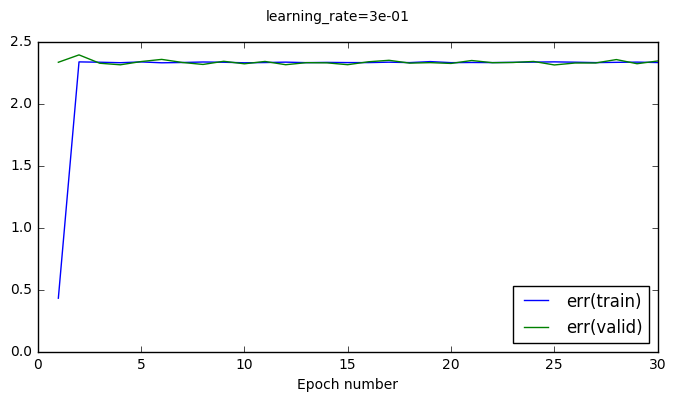

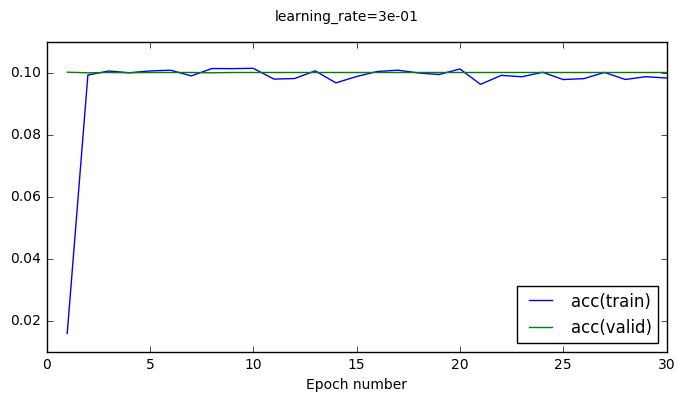

learning_rate=1e-01

End of epoch 01: err(train)=2.25 acc(train)=0.14 err(valid)=2.19 acc(valid)=0.13 time=2.42 min
End of epoch 02: err(train)=2.15 acc(train)=0.15 err(valid)=2.01 acc(valid)=0.19 time=2.20 min
End of epoch 03: err(train)=2.14 acc(train)=0.16 err(valid)=1.99 acc(valid)=0.17 time=2.20 min
End of epoch 04: err(train)=2.13 acc(train)=0.15 err(valid)=2.03 acc(valid)=0.18 time=2.22 min
End of epoch 05: err(train)=2.15 acc(train)=0.15 err(valid)=2.04 acc(valid)=0.17 time=2.24 min
End of epoch 06: err(train)=2.15 acc(train)=0.15 err(valid)=2.03 acc(valid)=0.17 time=2.19 min
End of epoch 07: err(train)=2.15 acc(train)=0.15 err(valid)=2.02 acc(valid)=0.18 time=2.20 min
End of epoch 08: err(train)=2.15 acc(train)=0.16 err(valid)=2.02 acc(valid)=0.17 time=2.19 min
End of epoch 09: err(train)=2.15 acc(train)=0.15 err(valid)=2.05 acc(valid)=0.17 time=2.19 min
End of epoch 10: err(train)=2.15 acc(train)=0.15 err(valid)=2.08 acc(valid)=0.16 time=2.22 min
End of epoch 11: err(train)=2

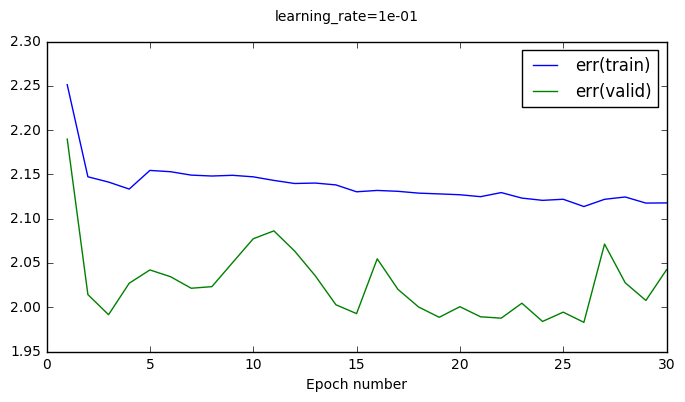

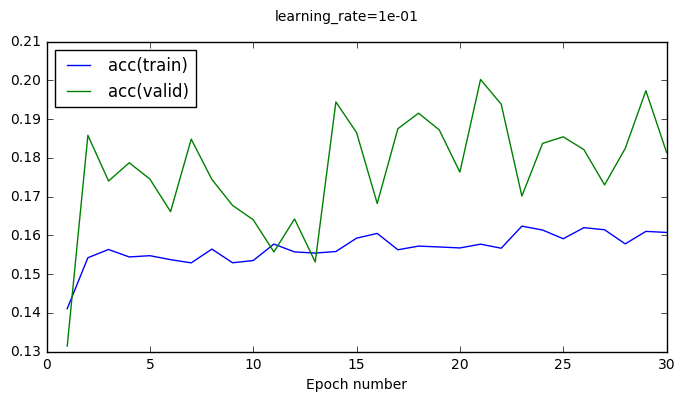

learning_rate=3e-02

End of epoch 01: err(train)=2.04 acc(train)=0.25 err(valid)=1.75 acc(valid)=0.36 time=2.20 min
End of epoch 02: err(train)=1.86 acc(train)=0.30 err(valid)=1.67 acc(valid)=0.38 time=2.20 min
End of epoch 03: err(train)=1.81 acc(train)=0.33 err(valid)=1.63 acc(valid)=0.40 time=2.24 min
End of epoch 04: err(train)=1.78 acc(train)=0.35 err(valid)=1.62 acc(valid)=0.42 time=2.21 min
End of epoch 05: err(train)=1.75 acc(train)=0.36 err(valid)=1.56 acc(valid)=0.43 time=2.19 min
End of epoch 06: err(train)=1.73 acc(train)=0.37 err(valid)=1.53 acc(valid)=0.44 time=2.19 min
End of epoch 07: err(train)=1.71 acc(train)=0.38 err(valid)=1.52 acc(valid)=0.46 time=2.19 min
End of epoch 08: err(train)=1.70 acc(train)=0.38 err(valid)=1.49 acc(valid)=0.46 time=2.19 min
End of epoch 09: err(train)=1.68 acc(train)=0.39 err(valid)=1.52 acc(valid)=0.45 time=2.19 min
End of epoch 10: err(train)=1.66 acc(train)=0.40 err(valid)=1.47 acc(valid)=0.47 time=2.18 min
End of epoch 11: err(train)=1

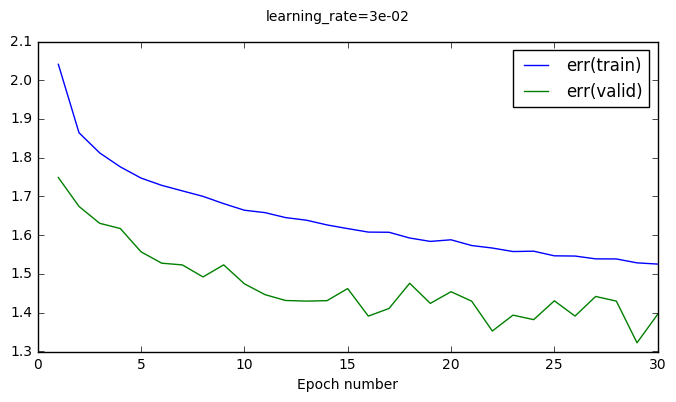

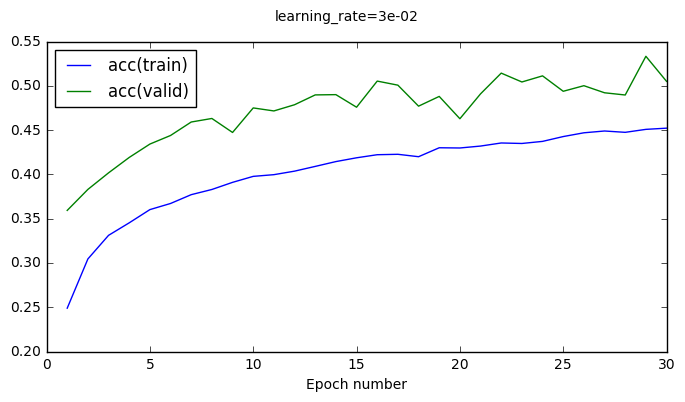

learning_rate=1e-02

End of epoch 01: err(train)=1.91 acc(train)=0.30 err(valid)=1.58 acc(valid)=0.41 time=2.22 min
End of epoch 02: err(train)=1.68 acc(train)=0.39 err(valid)=1.49 acc(valid)=0.45 time=2.21 min
End of epoch 03: err(train)=1.61 acc(train)=0.41 err(valid)=1.44 acc(valid)=0.48 time=2.18 min
End of epoch 04: err(train)=1.58 acc(train)=0.43 err(valid)=1.40 acc(valid)=0.49 time=2.18 min
End of epoch 05: err(train)=1.54 acc(train)=0.45 err(valid)=1.38 acc(valid)=0.50 time=2.20 min
End of epoch 06: err(train)=1.52 acc(train)=0.46 err(valid)=1.41 acc(valid)=0.50 time=2.19 min
End of epoch 07: err(train)=1.50 acc(train)=0.47 err(valid)=1.35 acc(valid)=0.51 time=2.19 min
End of epoch 08: err(train)=1.48 acc(train)=0.47 err(valid)=1.33 acc(valid)=0.52 time=2.20 min
End of epoch 09: err(train)=1.46 acc(train)=0.48 err(valid)=1.34 acc(valid)=0.52 time=2.19 min
End of epoch 10: err(train)=1.44 acc(train)=0.49 err(valid)=1.35 acc(valid)=0.52 time=2.18 min
End of epoch 11: err(train)=1

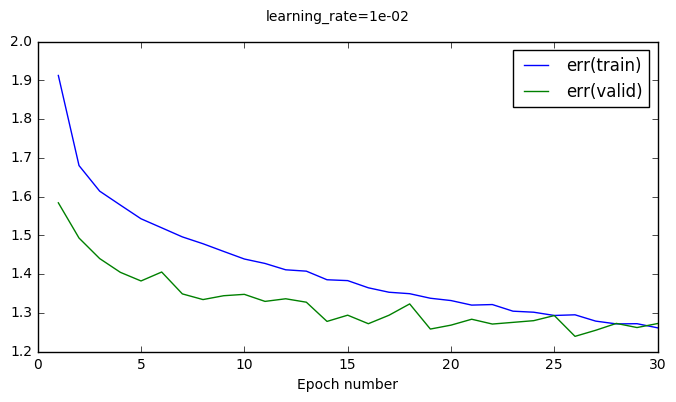

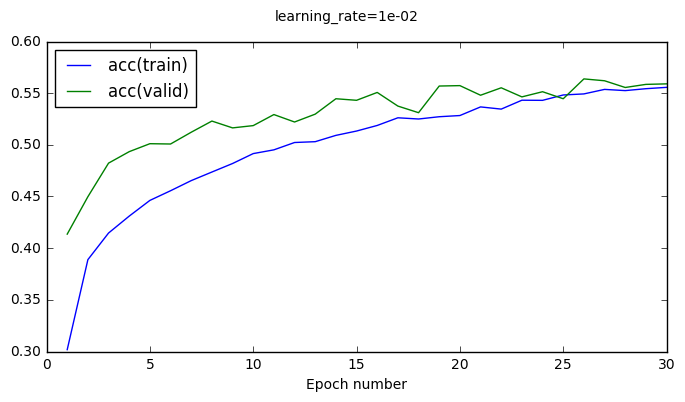

learning_rate=3e-03

End of epoch 01: err(train)=1.96 acc(train)=0.29 err(valid)=1.57 acc(valid)=0.42 time=2.20 min
End of epoch 02: err(train)=1.65 acc(train)=0.40 err(valid)=1.46 acc(valid)=0.47 time=2.20 min
End of epoch 03: err(train)=1.56 acc(train)=0.44 err(valid)=1.39 acc(valid)=0.50 time=2.18 min
End of epoch 04: err(train)=1.51 acc(train)=0.46 err(valid)=1.37 acc(valid)=0.50 time=2.18 min
End of epoch 05: err(train)=1.46 acc(train)=0.48 err(valid)=1.37 acc(valid)=0.50 time=2.18 min
End of epoch 06: err(train)=1.43 acc(train)=0.49 err(valid)=1.35 acc(valid)=0.51 time=2.19 min
End of epoch 07: err(train)=1.41 acc(train)=0.50 err(valid)=1.30 acc(valid)=0.54 time=2.16 min
End of epoch 08: err(train)=1.38 acc(train)=0.51 err(valid)=1.29 acc(valid)=0.54 time=1.98 min
End of epoch 09: err(train)=1.36 acc(train)=0.52 err(valid)=1.29 acc(valid)=0.54 time=1.98 min
End of epoch 10: err(train)=1.35 acc(train)=0.52 err(valid)=1.29 acc(valid)=0.54 time=1.98 min
End of epoch 11: err(train)=1

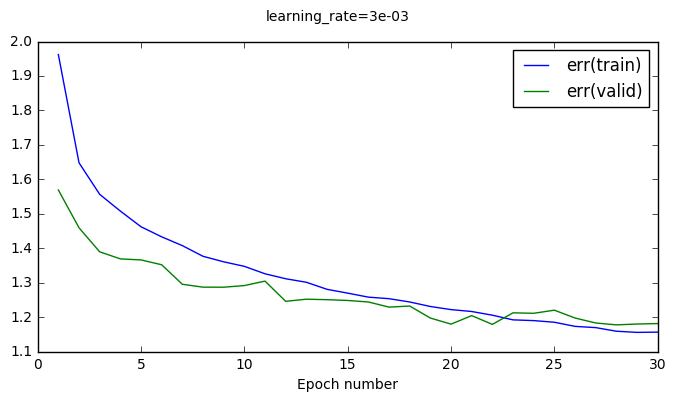

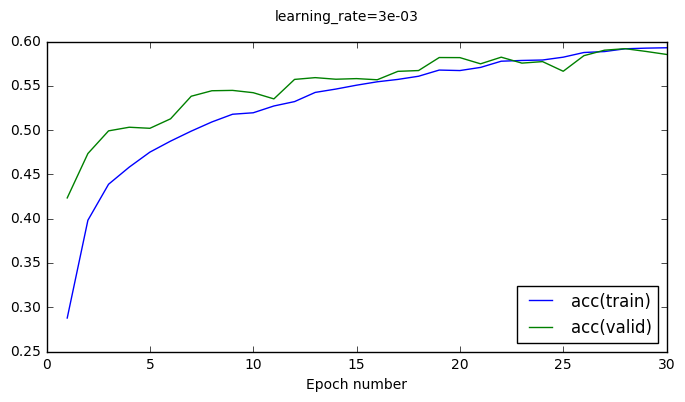

learning_rate=1e-03

End of epoch 01: err(train)=2.14 acc(train)=0.23 err(valid)=1.68 acc(valid)=0.38 time=2.02 min
End of epoch 02: err(train)=1.73 acc(train)=0.36 err(valid)=1.52 acc(valid)=0.44 time=1.99 min
End of epoch 03: err(train)=1.62 acc(train)=0.40 err(valid)=1.45 acc(valid)=0.47 time=2.00 min
End of epoch 04: err(train)=1.56 acc(train)=0.43 err(valid)=1.40 acc(valid)=0.49 time=1.99 min
End of epoch 05: err(train)=1.51 acc(train)=0.45 err(valid)=1.37 acc(valid)=0.50 time=2.00 min
End of epoch 06: err(train)=1.48 acc(train)=0.47 err(valid)=1.39 acc(valid)=0.50 time=2.02 min
End of epoch 07: err(train)=1.44 acc(train)=0.49 err(valid)=1.35 acc(valid)=0.51 time=2.00 min
End of epoch 08: err(train)=1.41 acc(train)=0.50 err(valid)=1.33 acc(valid)=0.53 time=1.99 min
End of epoch 09: err(train)=1.38 acc(train)=0.51 err(valid)=1.33 acc(valid)=0.52 time=2.00 min
End of epoch 10: err(train)=1.36 acc(train)=0.52 err(valid)=1.31 acc(valid)=0.53 time=2.00 min
End of epoch 11: err(train)=1

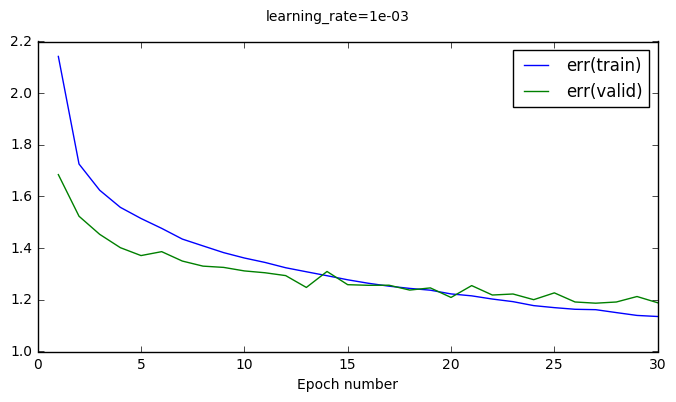

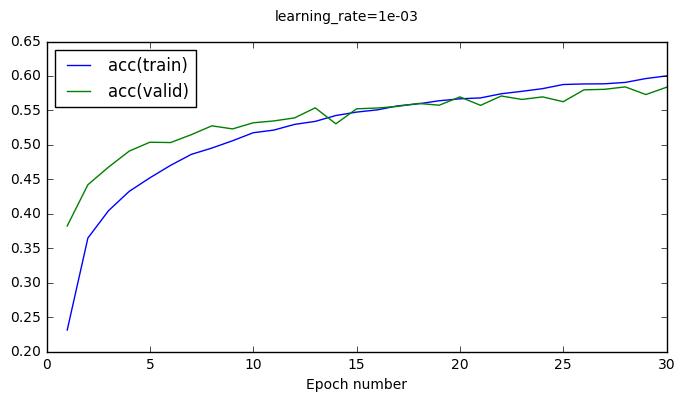

learning_rate=3e-04

End of epoch 01: err(train)=2.39 acc(train)=0.17 err(valid)=1.94 acc(valid)=0.32 time=2.03 min
End of epoch 02: err(train)=2.00 acc(train)=0.27 err(valid)=1.74 acc(valid)=0.37 time=2.02 min
End of epoch 03: err(train)=1.84 acc(train)=0.32 err(valid)=1.62 acc(valid)=0.41 time=2.00 min
End of epoch 04: err(train)=1.74 acc(train)=0.36 err(valid)=1.58 acc(valid)=0.42 time=2.03 min
End of epoch 05: err(train)=1.68 acc(train)=0.38 err(valid)=1.54 acc(valid)=0.43 time=2.01 min
End of epoch 06: err(train)=1.64 acc(train)=0.40 err(valid)=1.50 acc(valid)=0.45 time=2.01 min
End of epoch 07: err(train)=1.60 acc(train)=0.42 err(valid)=1.46 acc(valid)=0.47 time=2.01 min
End of epoch 08: err(train)=1.58 acc(train)=0.43 err(valid)=1.46 acc(valid)=0.47 time=2.01 min
End of epoch 09: err(train)=1.56 acc(train)=0.44 err(valid)=1.43 acc(valid)=0.48 time=2.01 min
End of epoch 10: err(train)=1.53 acc(train)=0.44 err(valid)=1.39 acc(valid)=0.50 time=2.00 min
End of epoch 11: err(train)=1

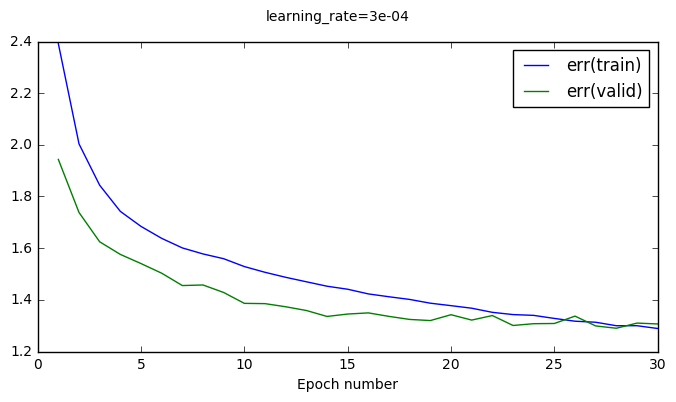

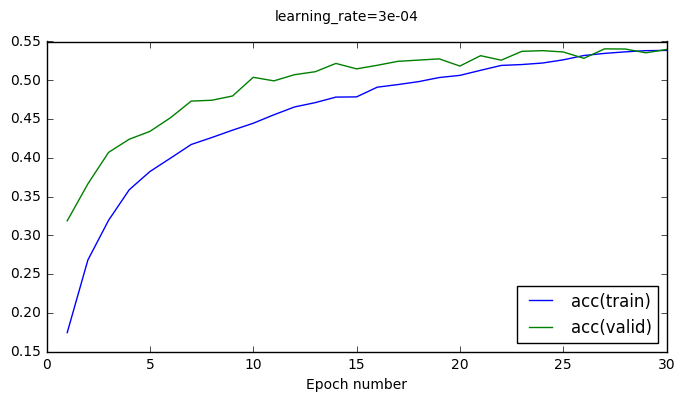

In [10]:
# Create directory (has suffix for today's date).
# Then DELETE all files in path if there are files already there.
subdir = 'cnn_dropout_complete'
save_path = create_and_return_path(subdir, save_path_main)
clear_dir(save_path)

# Define hyperparameters
params = {
    'learning_rate': None,
    'conv1_filter_size': 3,
    'conv1_num_filters': 32,
    'conv1_stride': 1,
    'pool1_k_width': 2,
    'pool1_stride': 2,
    'conv2_filter_size': 3,
    'conv2_num_filters': 64,
    'conv2_stride': 1,
    'pool2_k_width': 2,
    'pool2_stride': 2,
    'fc1_num_outputs': 384,
    'fc2_num_outputs': 192,
    'keep_prob': 1.0,
    'keep_prob_inputs': 0.8,
    'keep_prob_fc': 0.5,
    'fc_batch_norm': True,
    'conv_batch_norm': False
}

stats = OrderedDict()

num_epoch = 30

iter_vars = [3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1][::-1]
iter_strs = ['learning_rate={}'.format(format_e(iter_var)) for iter_var in iter_vars]

for iter_var, iter_str in zip(iter_vars, iter_strs):

    print '==========\n{}\n'.format(iter_str)
    stats_one = {'err(train)': [], 'acc(train)': [], 'err(valid)': [], 'acc(valid)': []}
    
    params['learning_rate'] = iter_var
    stats[iter_str] = run_cnn_model(params, save_path)
    
    # Pickle all important objects
    pickle.dump(stats, open(os.path.join(save_path_main, subdir, "stats.p"), "wb"))

path created: run/coursework4/cnn_dropout_complete/2017-03-16


/Users/sipola/miniconda2/envs/mlp/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


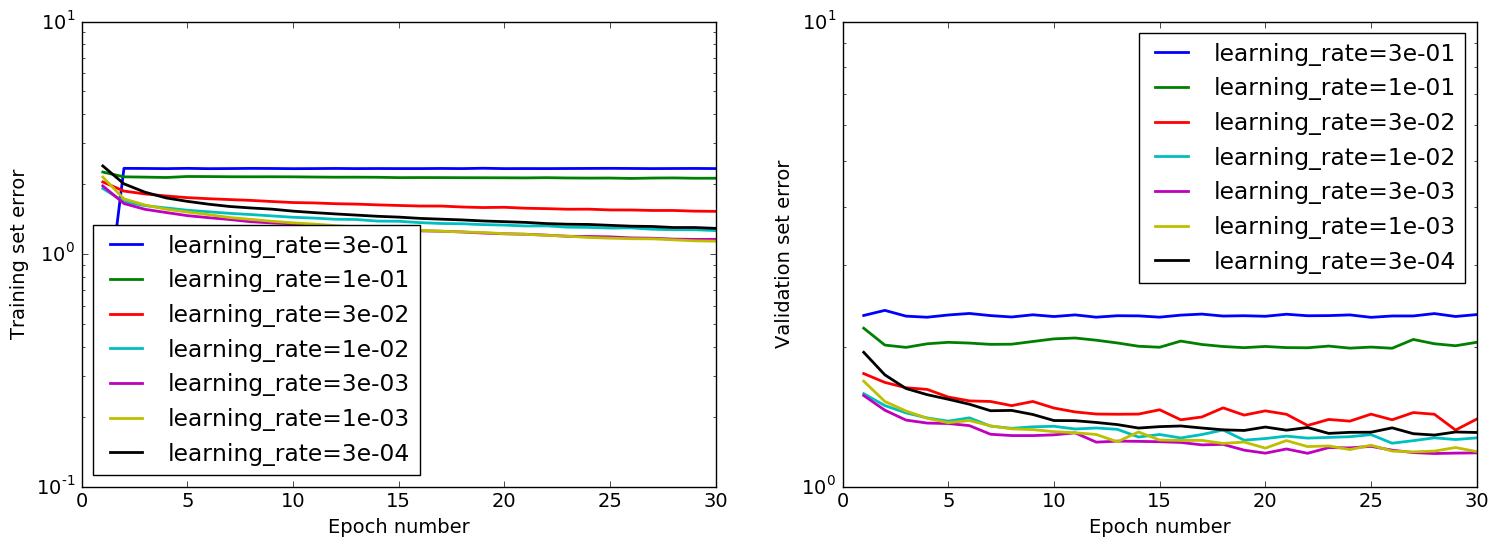

In [11]:
subdir = 'cnn_dropout_complete'
stats = pickle.load(open(os.path.join(save_path_main, subdir, "stats.p"), "rb"))
save_path = create_and_return_path(subdir, save_path_main)
# del stats['keep_prob=0.25']
iter_graph(stats, os.path.join(save_path, 'cnn_dropout_complete.pdf'))

path created: run/coursework4/cnn_dropout/2017-03-08
deleting files in: run/coursework4/cnn_dropout/2017-03-08
keep_prob=1.00

End of epoch 01: err(train)=1.67 acc(train)=0.41 err(valid)=1.47 acc(valid)=0.48 time=2.30 min
End of epoch 02: err(train)=1.35 acc(train)=0.53 err(valid)=1.33 acc(valid)=0.53 time=2.04 min
End of epoch 03: err(train)=1.21 acc(train)=0.58 err(valid)=1.27 acc(valid)=0.55 time=2.05 min
End of epoch 04: err(train)=1.10 acc(train)=0.62 err(valid)=1.22 acc(valid)=0.57 time=2.05 min
End of epoch 05: err(train)=1.00 acc(train)=0.65 err(valid)=1.19 acc(valid)=0.58 time=2.18 min
End of epoch 06: err(train)=0.92 acc(train)=0.68 err(valid)=1.17 acc(valid)=0.59 time=2.04 min
End of epoch 07: err(train)=0.85 acc(train)=0.71 err(valid)=1.17 acc(valid)=0.59 time=2.01 min
End of epoch 08: err(train)=0.77 acc(train)=0.74 err(valid)=1.16 acc(valid)=0.60 time=2.00 min
End of epoch 09: err(train)=0.70 acc(train)=0.77 err(valid)=1.19 acc(valid)=0.59 time=1.99 min
End of epoch 10: e

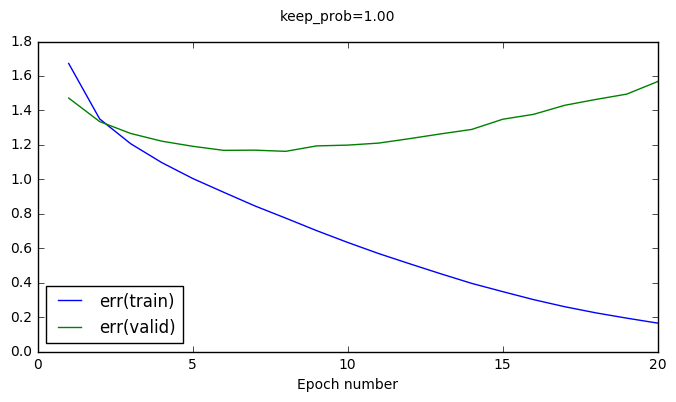

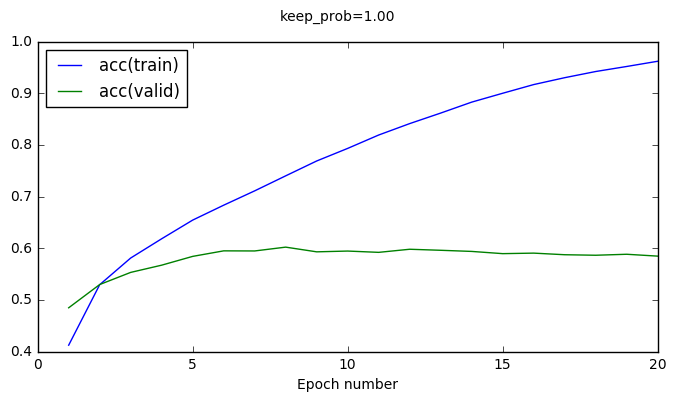

keep_prob=0.90

End of epoch 01: err(train)=1.87 acc(train)=0.33 err(valid)=1.52 acc(valid)=0.46 time=2.32 min
End of epoch 02: err(train)=1.48 acc(train)=0.47 err(valid)=1.38 acc(valid)=0.51 time=2.22 min
End of epoch 03: err(train)=1.35 acc(train)=0.52 err(valid)=1.30 acc(valid)=0.54 time=2.21 min
End of epoch 04: err(train)=1.25 acc(train)=0.56 err(valid)=1.25 acc(valid)=0.56 time=2.22 min
End of epoch 05: err(train)=1.17 acc(train)=0.59 err(valid)=1.21 acc(valid)=0.57 time=2.24 min
End of epoch 06: err(train)=1.09 acc(train)=0.62 err(valid)=1.18 acc(valid)=0.59 time=2.25 min
End of epoch 07: err(train)=1.03 acc(train)=0.64 err(valid)=1.16 acc(valid)=0.60 time=2.24 min
End of epoch 08: err(train)=0.97 acc(train)=0.66 err(valid)=1.15 acc(valid)=0.60 time=2.21 min
End of epoch 09: err(train)=0.92 acc(train)=0.68 err(valid)=1.14 acc(valid)=0.61 time=2.23 min
End of epoch 10: err(train)=0.86 acc(train)=0.70 err(valid)=1.13 acc(valid)=0.61 time=2.21 min
End of epoch 11: err(train)=0.81 a

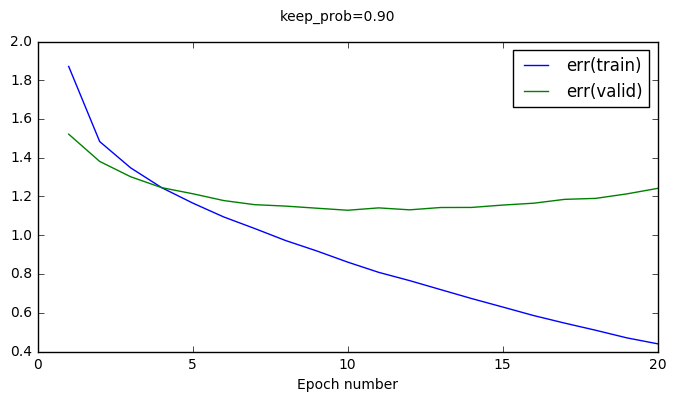

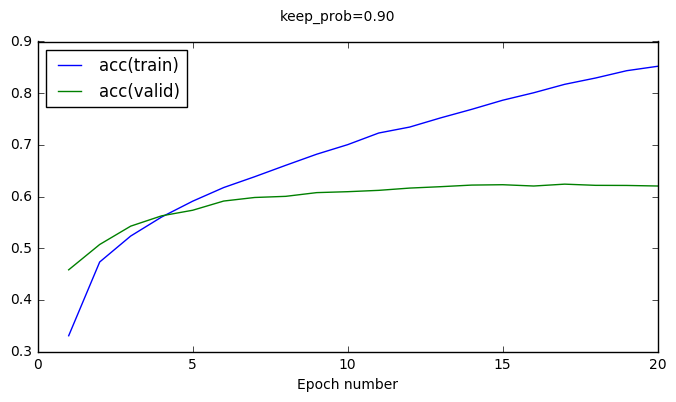

keep_prob=0.75

End of epoch 01: err(train)=1.98 acc(train)=0.29 err(valid)=1.57 acc(valid)=0.43 time=2.23 min
End of epoch 02: err(train)=1.57 acc(train)=0.44 err(valid)=1.42 acc(valid)=0.49 time=2.21 min
End of epoch 03: err(train)=1.43 acc(train)=0.49 err(valid)=1.33 acc(valid)=0.53 time=2.21 min
End of epoch 04: err(train)=1.33 acc(train)=0.53 err(valid)=1.27 acc(valid)=0.55 time=2.20 min
End of epoch 05: err(train)=1.25 acc(train)=0.56 err(valid)=1.22 acc(valid)=0.57 time=2.21 min
End of epoch 06: err(train)=1.19 acc(train)=0.58 err(valid)=1.18 acc(valid)=0.59 time=2.22 min
End of epoch 07: err(train)=1.13 acc(train)=0.60 err(valid)=1.15 acc(valid)=0.60 time=2.24 min
End of epoch 08: err(train)=1.08 acc(train)=0.62 err(valid)=1.13 acc(valid)=0.60 time=2.21 min
End of epoch 09: err(train)=1.04 acc(train)=0.64 err(valid)=1.11 acc(valid)=0.61 time=2.21 min
End of epoch 10: err(train)=1.00 acc(train)=0.65 err(valid)=1.10 acc(valid)=0.62 time=2.20 min
End of epoch 11: err(train)=0.96 a

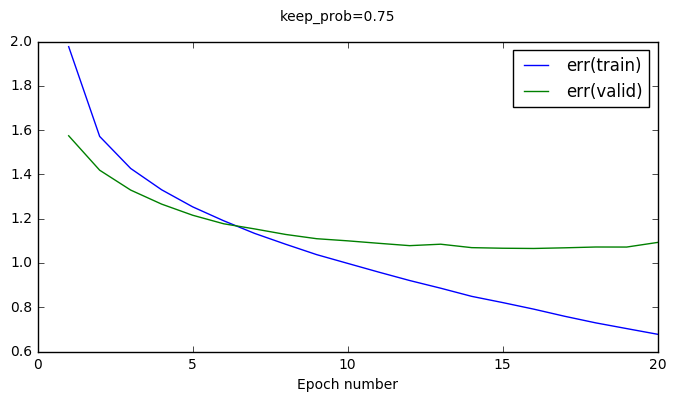

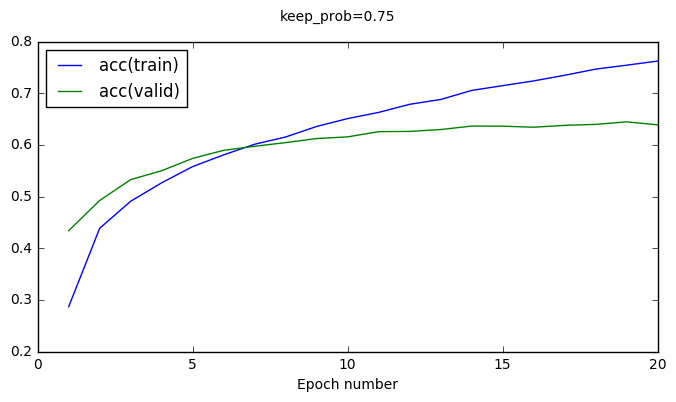

keep_prob=0.50

End of epoch 01: err(train)=2.11 acc(train)=0.25 err(valid)=1.72 acc(valid)=0.39 time=2.24 min
End of epoch 02: err(train)=1.75 acc(train)=0.37 err(valid)=1.54 acc(valid)=0.45 time=2.21 min
End of epoch 03: err(train)=1.60 acc(train)=0.42 err(valid)=1.46 acc(valid)=0.48 time=2.19 min
End of epoch 04: err(train)=1.51 acc(train)=0.46 err(valid)=1.40 acc(valid)=0.50 time=2.19 min
End of epoch 05: err(train)=1.45 acc(train)=0.48 err(valid)=1.35 acc(valid)=0.52 time=2.19 min
End of epoch 06: err(train)=1.39 acc(train)=0.50 err(valid)=1.32 acc(valid)=0.53 time=2.18 min
End of epoch 07: err(train)=1.34 acc(train)=0.52 err(valid)=1.28 acc(valid)=0.55 time=2.19 min
End of epoch 08: err(train)=1.31 acc(train)=0.54 err(valid)=1.26 acc(valid)=0.56 time=2.18 min
End of epoch 09: err(train)=1.27 acc(train)=0.55 err(valid)=1.22 acc(valid)=0.57 time=2.20 min
End of epoch 10: err(train)=1.24 acc(train)=0.56 err(valid)=1.20 acc(valid)=0.58 time=2.20 min
End of epoch 11: err(train)=1.21 a

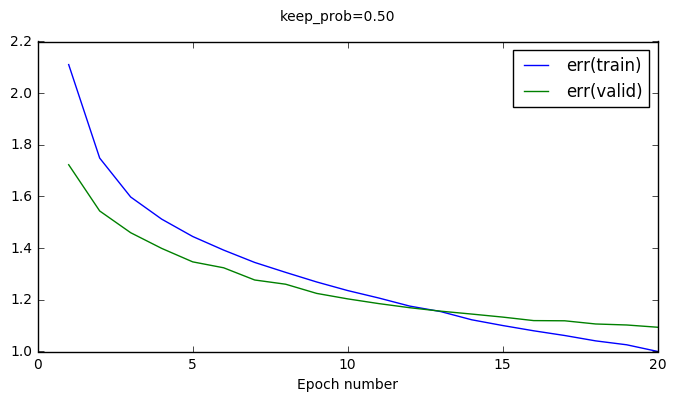

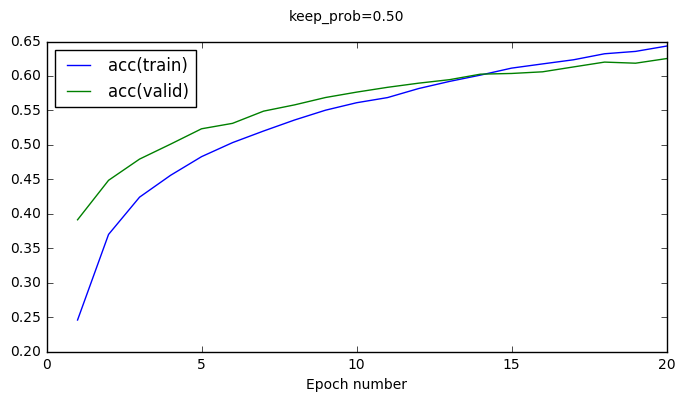

keep_prob=0.25

End of epoch 01: err(train)=2.32 acc(train)=0.16 err(valid)=1.98 acc(valid)=0.32 time=2.05 min
End of epoch 02: err(train)=1.96 acc(train)=0.28 err(valid)=1.76 acc(valid)=0.38 time=2.02 min
End of epoch 03: err(train)=1.78 acc(train)=0.35 err(valid)=1.62 acc(valid)=0.42 time=2.04 min
End of epoch 04: err(train)=1.68 acc(train)=0.39 err(valid)=1.54 acc(valid)=0.45 time=2.01 min
End of epoch 05: err(train)=1.62 acc(train)=0.41 err(valid)=1.48 acc(valid)=0.47 time=2.02 min
End of epoch 06: err(train)=1.56 acc(train)=0.43 err(valid)=1.44 acc(valid)=0.49 time=2.26 min
End of epoch 07: err(train)=1.52 acc(train)=0.45 err(valid)=1.41 acc(valid)=0.50 time=2.23 min
End of epoch 08: err(train)=1.49 acc(train)=0.46 err(valid)=1.38 acc(valid)=0.51 time=2.21 min
End of epoch 09: err(train)=1.45 acc(train)=0.48 err(valid)=1.35 acc(valid)=0.53 time=2.21 min
End of epoch 10: err(train)=1.43 acc(train)=0.48 err(valid)=1.33 acc(valid)=0.53 time=2.20 min
End of epoch 11: err(train)=1.40 a

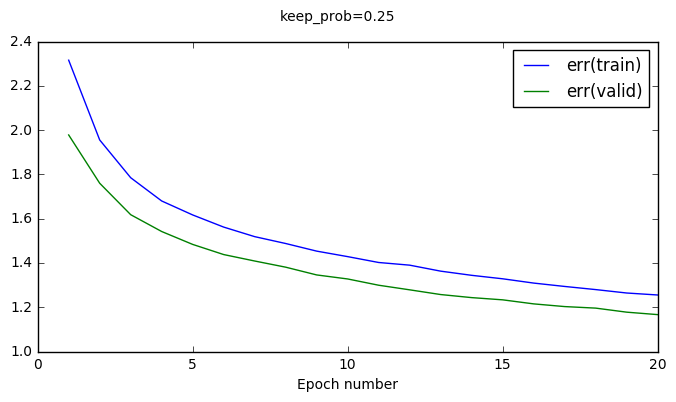

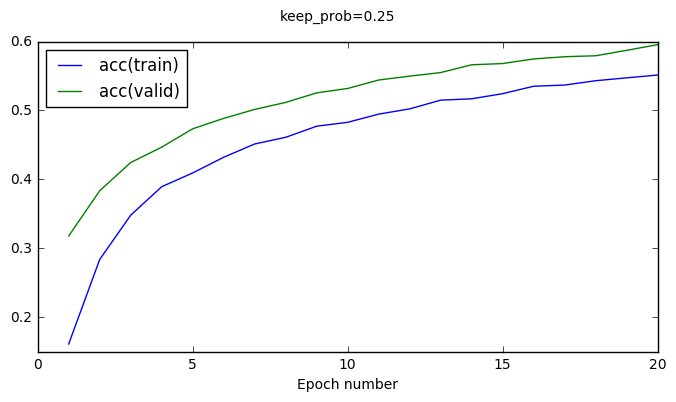

In [101]:
# # Create directory (has suffix for today's date).
# # Then DELETE all files in path if there are files already there.
# subdir = 'cnn_dropout'
# save_path = create_and_return_path(subdir, save_path_main)
# clear_dir(save_path)

# # Define hyperparameters
# params = {
#     'learning_rate': 1e-4,
#     'conv1_filter_size': 3,
#     'conv1_num_filters': 32,
#     'conv1_stride': 1,
#     'pool1_k_width': 2,
#     'pool1_stride': 2,
#     'conv2_filter_size': 3,
#     'conv2_num_filters': 64,
#     'conv2_stride': 1,
#     'pool2_k_width': 2,
#     'pool2_stride': 2,
#     'fc1_num_outputs': 384,
#     'fc2_num_outputs': 192,
#     'keep_prob': 1.0,
#     'fc_batch_norm': True,
#     'conv_batch_norm': False
# }

# stats = OrderedDict()

# num_epoch = 20

# iter_vars = [1.0, 0.9, 0.75, 0.5, 0.25]
# iter_strs = ['keep_prob={:.2f}'.format(p) for p in iter_vars]
# # if len(iter_vars) != len(iter_strs):
# #     print 'lengths DO NOT match. Bad!!!'

# for iter_var, iter_str in zip(iter_vars, iter_strs):

#     print '==========\n{}\n'.format(iter_str)
#     stats_one = {'err(train)': [], 'acc(train)': [], 'err(valid)': [], 'acc(valid)': []}
    
#     params['keep_prob'] = iter_var
#     stats[iter_str] = run_cnn_model(params, save_path)
    
#     # Pickle all important objects
#     pickle.dump(stats, open(os.path.join(save_path_main, subdir, "stats.p"), "wb"))

path created: run/coursework4/cnn_dropout_faster/2017-03-16
deleting files in: run/coursework4/cnn_dropout_faster/2017-03-16
keep_prob=1.00

End of epoch 01: err(train)=1.40 acc(train)=0.50 err(valid)=1.21 acc(valid)=0.57 time=2.58 min
End of epoch 02: err(train)=1.06 acc(train)=0.63 err(valid)=1.12 acc(valid)=0.61 time=2.67 min
End of epoch 03: err(train)=0.86 acc(train)=0.70 err(valid)=1.10 acc(valid)=0.62 time=2.48 min
End of epoch 04: err(train)=0.70 acc(train)=0.76 err(valid)=1.11 acc(valid)=0.63 time=2.51 min
End of epoch 05: err(train)=0.54 acc(train)=0.81 err(valid)=1.18 acc(valid)=0.63 time=2.52 min
End of epoch 06: err(train)=0.40 acc(train)=0.86 err(valid)=1.27 acc(valid)=0.63 time=2.24 min
End of epoch 07: err(train)=0.28 acc(train)=0.90 err(valid)=1.47 acc(valid)=0.62 time=2.39 min
End of epoch 08: err(train)=0.22 acc(train)=0.92 err(valid)=1.55 acc(valid)=0.63 time=2.32 min
End of epoch 09: err(train)=0.17 acc(train)=0.94 err(valid)=1.68 acc(valid)=0.62 time=2.37 min
End 

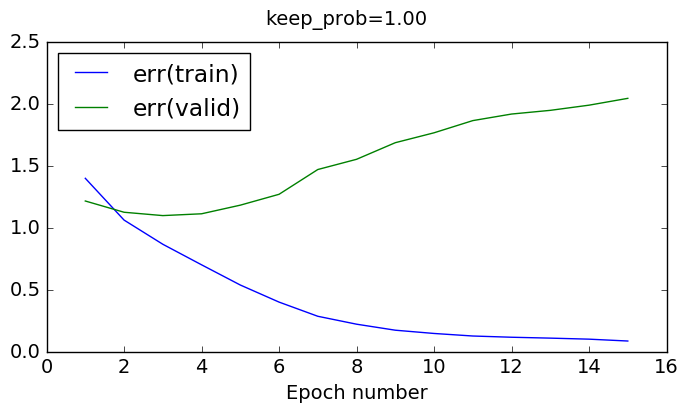

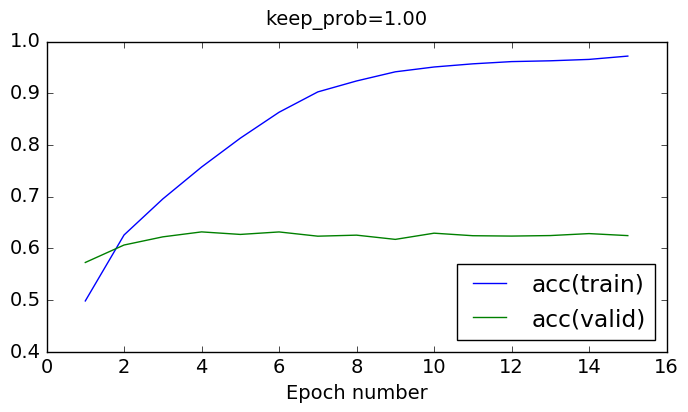

keep_prob=0.90

End of epoch 01: err(train)=1.47 acc(train)=0.47 err(valid)=1.23 acc(valid)=0.57 time=2.34 min
End of epoch 02: err(train)=1.12 acc(train)=0.60 err(valid)=1.09 acc(valid)=0.62 time=2.20 min
End of epoch 03: err(train)=0.95 acc(train)=0.66 err(valid)=1.04 acc(valid)=0.64 time=2.20 min
End of epoch 04: err(train)=0.81 acc(train)=0.71 err(valid)=1.03 acc(valid)=0.65 time=2.26 min
End of epoch 05: err(train)=0.69 acc(train)=0.76 err(valid)=1.06 acc(valid)=0.65 time=2.26 min
End of epoch 06: err(train)=0.57 acc(train)=0.80 err(valid)=1.11 acc(valid)=0.65 time=2.31 min
End of epoch 07: err(train)=0.46 acc(train)=0.84 err(valid)=1.16 acc(valid)=0.65 time=2.20 min
End of epoch 08: err(train)=0.36 acc(train)=0.87 err(valid)=1.26 acc(valid)=0.65 time=2.23 min
End of epoch 09: err(train)=0.29 acc(train)=0.90 err(valid)=1.31 acc(valid)=0.65 time=2.79 min
End of epoch 10: err(train)=0.24 acc(train)=0.92 err(valid)=1.40 acc(valid)=0.65 time=2.33 min
End of epoch 11: err(train)=0.20 a

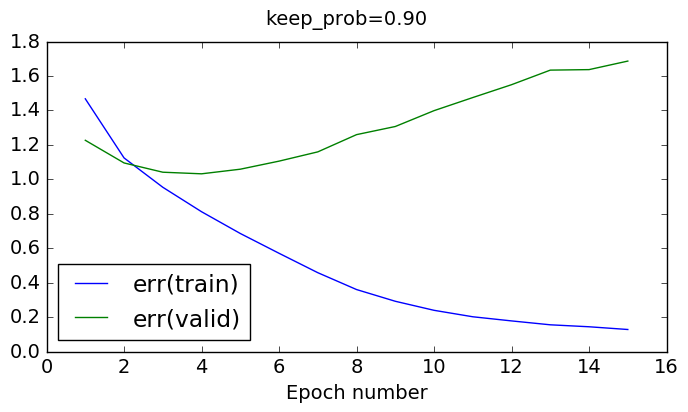

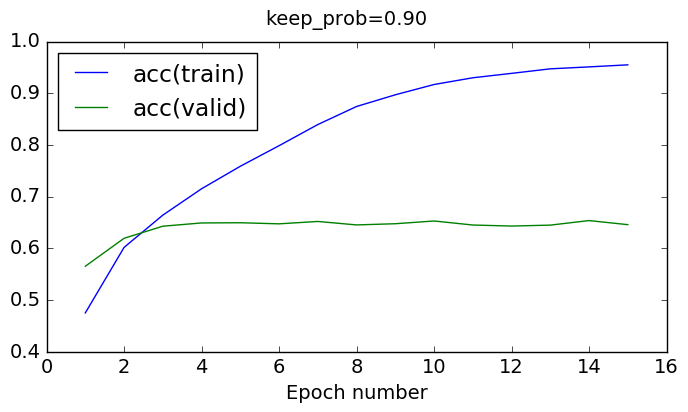

keep_prob=0.75

End of epoch 01: err(train)=1.55 acc(train)=0.44 err(valid)=1.30 acc(valid)=0.54 time=2.19 min
End of epoch 02: err(train)=1.21 acc(train)=0.57 err(valid)=1.15 acc(valid)=0.59 time=2.02 min
End of epoch 03: err(train)=1.05 acc(train)=0.62 err(valid)=1.07 acc(valid)=0.63 time=2.11 min
End of epoch 04: err(train)=0.94 acc(train)=0.67 err(valid)=1.04 acc(valid)=0.64 time=2.51 min
End of epoch 05: err(train)=0.84 acc(train)=0.70 err(valid)=0.99 acc(valid)=0.66 time=2.71 min
End of epoch 06: err(train)=0.75 acc(train)=0.74 err(valid)=1.02 acc(valid)=0.66 time=2.39 min
End of epoch 07: err(train)=0.66 acc(train)=0.77 err(valid)=1.04 acc(valid)=0.65 time=2.32 min
End of epoch 08: err(train)=0.58 acc(train)=0.79 err(valid)=1.06 acc(valid)=0.66 time=2.78 min
End of epoch 09: err(train)=0.51 acc(train)=0.82 err(valid)=1.08 acc(valid)=0.67 time=2.44 min
End of epoch 10: err(train)=0.44 acc(train)=0.84 err(valid)=1.12 acc(valid)=0.67 time=2.47 min
End of epoch 11: err(train)=0.38 a

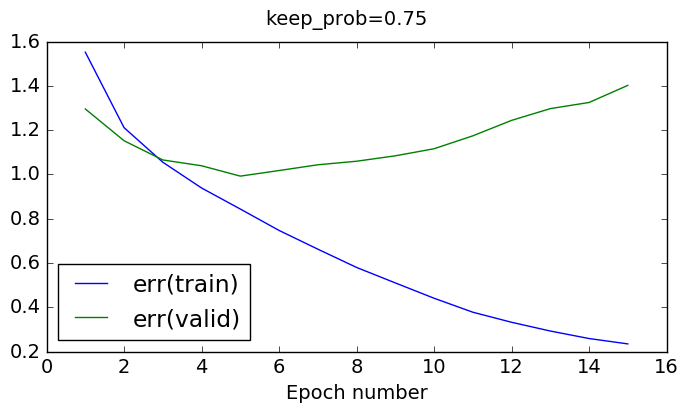

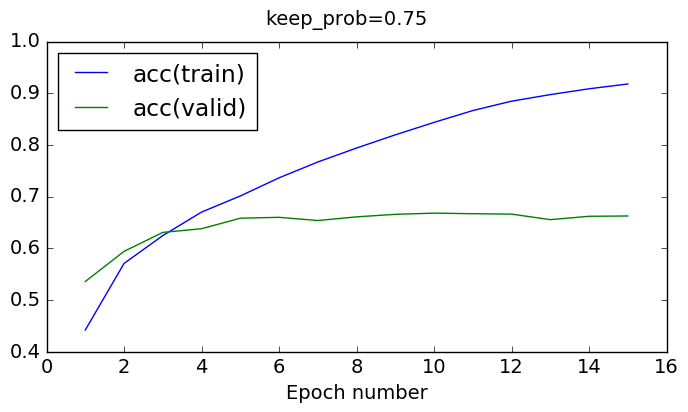

keep_prob=0.50

End of epoch 01: err(train)=1.68 acc(train)=0.39 err(valid)=1.38 acc(valid)=0.51 time=2.29 min
End of epoch 02: err(train)=1.36 acc(train)=0.51 err(valid)=1.23 acc(valid)=0.56 time=2.23 min
End of epoch 03: err(train)=1.22 acc(train)=0.56 err(valid)=1.15 acc(valid)=0.59 time=2.32 min
End of epoch 04: err(train)=1.11 acc(train)=0.60 err(valid)=1.06 acc(valid)=0.63 time=2.17 min
End of epoch 05: err(train)=1.04 acc(train)=0.63 err(valid)=1.05 acc(valid)=0.63 time=2.24 min
End of epoch 06: err(train)=0.97 acc(train)=0.66 err(valid)=1.00 acc(valid)=0.65 time=2.49 min
End of epoch 07: err(train)=0.91 acc(train)=0.68 err(valid)=0.99 acc(valid)=0.65 time=2.00 min
End of epoch 08: err(train)=0.86 acc(train)=0.69 err(valid)=0.96 acc(valid)=0.67 time=1.98 min
End of epoch 09: err(train)=0.80 acc(train)=0.72 err(valid)=0.96 acc(valid)=0.67 time=1.97 min
End of epoch 10: err(train)=0.76 acc(train)=0.73 err(valid)=0.96 acc(valid)=0.67 time=1.98 min
End of epoch 11: err(train)=0.72 a

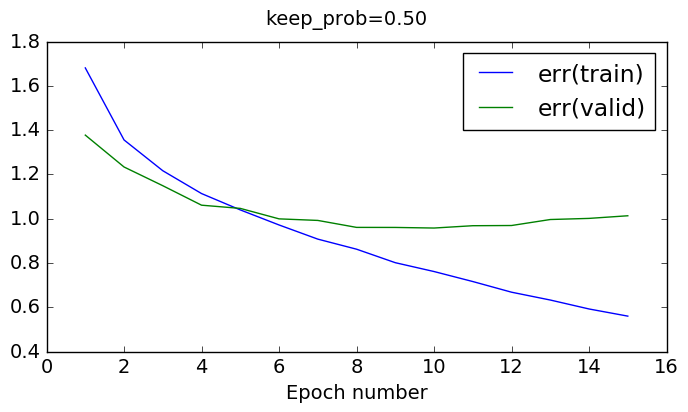

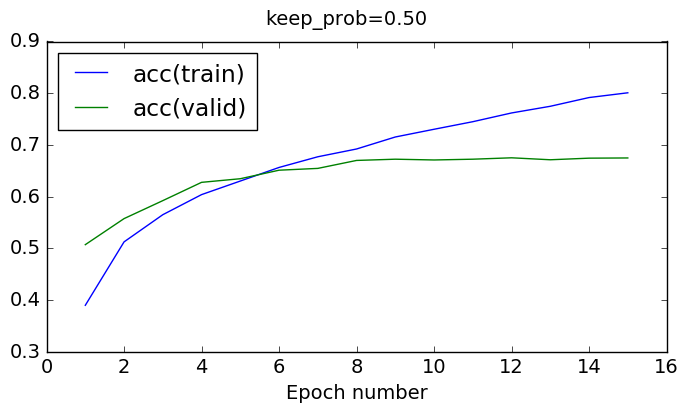

keep_prob=0.25

End of epoch 01: err(train)=1.84 acc(train)=0.33 err(valid)=1.49 acc(valid)=0.46 time=2.38 min
End of epoch 02: err(train)=1.51 acc(train)=0.45 err(valid)=1.34 acc(valid)=0.52 time=2.23 min
End of epoch 03: err(train)=1.40 acc(train)=0.50 err(valid)=1.27 acc(valid)=0.55 time=2.23 min
End of epoch 04: err(train)=1.32 acc(train)=0.53 err(valid)=1.19 acc(valid)=0.58 time=2.24 min
End of epoch 05: err(train)=1.26 acc(train)=0.55 err(valid)=1.14 acc(valid)=0.60 time=2.27 min
End of epoch 06: err(train)=1.21 acc(train)=0.57 err(valid)=1.10 acc(valid)=0.62 time=2.14 min
End of epoch 07: err(train)=1.17 acc(train)=0.58 err(valid)=1.07 acc(valid)=0.63 time=2.30 min
End of epoch 08: err(train)=1.13 acc(train)=0.60 err(valid)=1.05 acc(valid)=0.64 time=2.33 min
End of epoch 09: err(train)=1.10 acc(train)=0.61 err(valid)=1.03 acc(valid)=0.64 time=2.41 min
End of epoch 10: err(train)=1.06 acc(train)=0.62 err(valid)=1.00 acc(valid)=0.65 time=2.23 min
End of epoch 11: err(train)=1.04 a

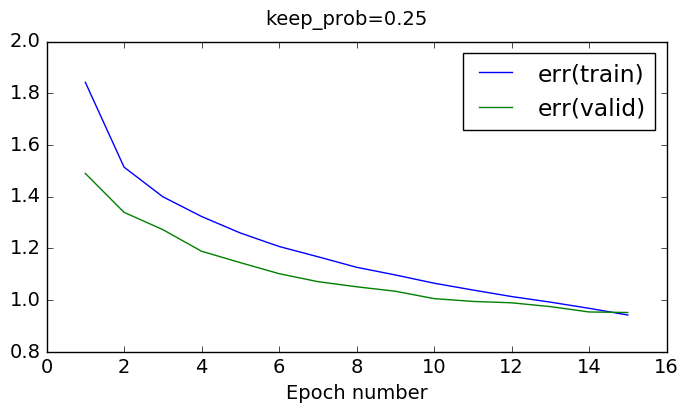

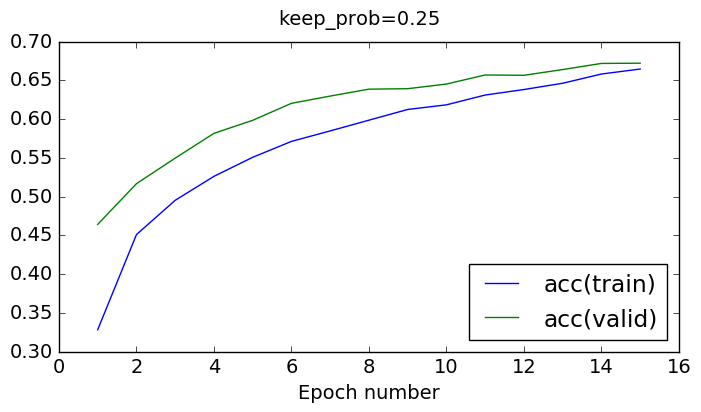

In [22]:
# Create directory (has suffix for today's date).
# Then DELETE all files in path if there are files already there.
subdir = 'cnn_dropout_faster'
save_path = create_and_return_path(subdir, save_path_main)
clear_dir(save_path)

# Define hyperparameters
params = {
    'learning_rate': 1e-3,
    'conv1_filter_size': 3,
    'conv1_num_filters': 32,
    'conv1_stride': 1,
    'pool1_k_width': 2,
    'pool1_stride': 2,
    'conv2_filter_size': 3,
    'conv2_num_filters': 64,
    'conv2_stride': 1,
    'pool2_k_width': 2,
    'pool2_stride': 2,
    'fc1_num_outputs': 384,
    'fc2_num_outputs': 192,
    'keep_prob': 1.0,
    'fc_batch_norm': True,
    'conv_batch_norm': False
}

stats = OrderedDict()

num_epoch = 15

iter_vars = [1.0, 0.9, 0.75, 0.5, 0.25]
# iter_vars = [0.5]
iter_strs = ['keep_prob={:.2f}'.format(p) for p in iter_vars]
# if len(iter_vars) != len(iter_strs):
#     print 'lengths DO NOT match. Bad!!!'

for iter_var, iter_str in zip(iter_vars, iter_strs):

    print '==========\n{}\n'.format(iter_str)
    stats_one = {'err(train)': [], 'acc(train)': [], 'err(valid)': [], 'acc(valid)': []}
    
    params['keep_prob'] = iter_var
    stats[iter_str] = run_cnn_model(params, save_path)
    
    # Pickle all important objects
    pickle.dump(stats, open(os.path.join(save_path_main, subdir, "stats.p"), "wb"))

path created: run/coursework4/cnn_dropout/2017-03-14


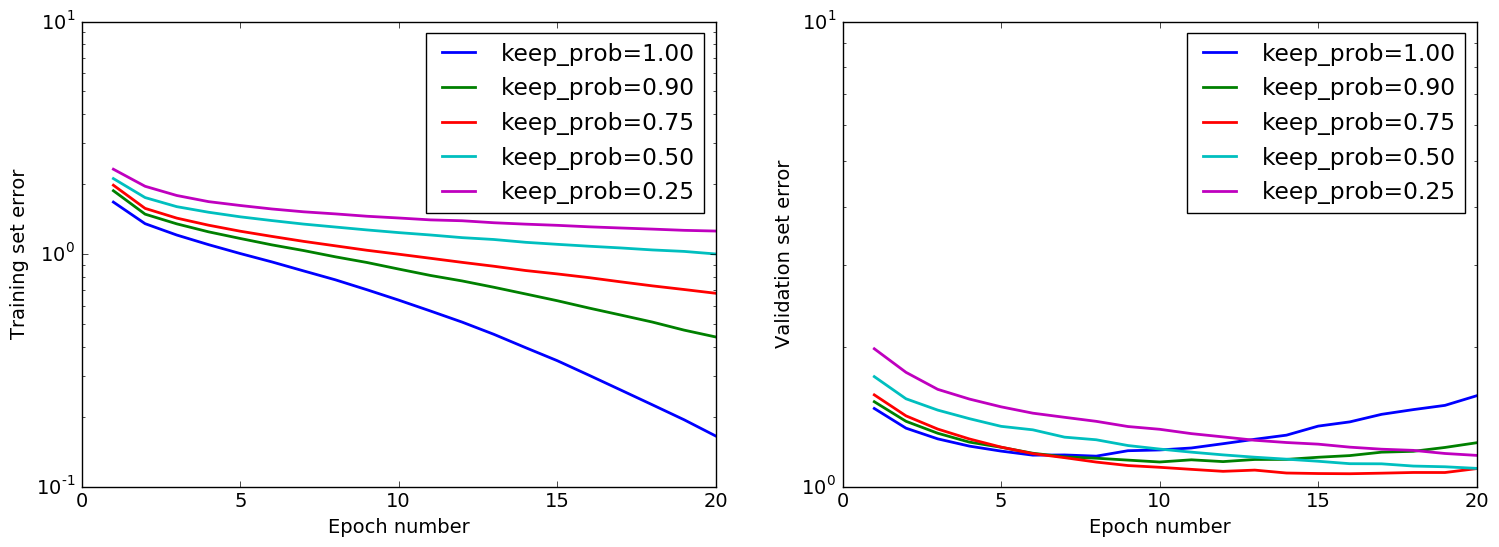

In [124]:
subdir = 'cnn_dropout'
stats = pickle.load(open(os.path.join(save_path_main, subdir, "stats.p"), "rb"))
save_path = create_and_return_path(subdir, save_path_main)
# del stats['keep_prob=0.25']
iter_graph(stats, os.path.join(save_path, 'cnn_dropout.pdf'))

path created: run/coursework4/cnn_dropout_faster/2017-03-16
run/coursework4/cnn_dropout_faster/2017-03-16/cnn_dropout_faster.pdf


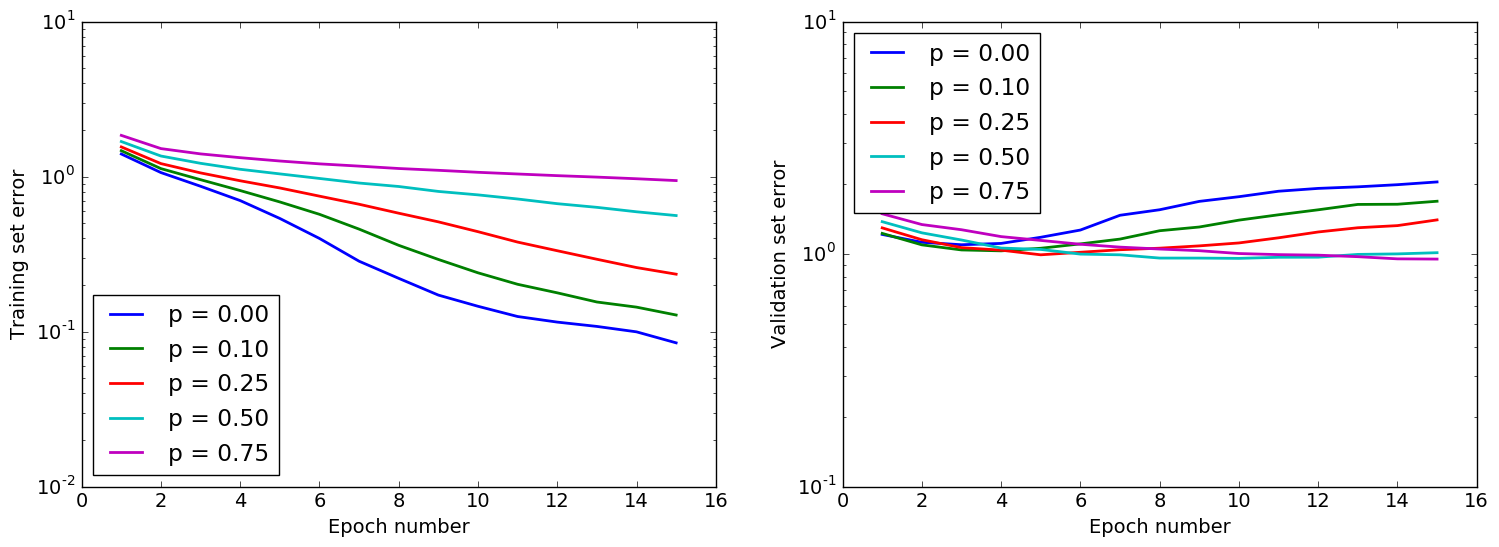

In [40]:
subdir = 'cnn_dropout_faster'
save_path = create_and_return_path(subdir, save_path_main)
stats = pickle.load(open(os.path.join(save_path_main, subdir, "stats.p"), "rb"))
# iter_graph(stats, os.path.join(save_path, 'cnn_dropout.pdf'))

def iter_graph_dropout(stats, path, fontsize=14, lwd=2):
    
    font = {'family' : 'normal',
            'weight' : 'normal',
            'size'   : fontsize}
    plt.rc('font', **font)
        
    # Plot stuff
    fig = plt.figure(figsize=(18, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    for iter_str, stats_sub in stats.iteritems():
        num_epoch = len(stats_sub.values()[0])
        p = 1 - float(re.sub('keep_prob=', '', iter_str))
        label = 'p = {:0.2f}'.format(p)
        ax1.plot(np.arange(1, num_epoch + 1), 
                 stats_sub['err(train)'], label=label, linewidth=lwd)
        ax2.plot(np.arange(1, num_epoch + 1), 
                 stats_sub['err(valid)'], label=label, linewidth=lwd)
    ax1.legend(loc=0)
    ax1.set_xlabel('Epoch number')
    ax1.set_ylabel('Training set error')
    ax1.set_yscale('log')
    ax2.legend(loc=0)
    ax2.set_xlabel('Epoch number')
    ax2.set_ylabel('Validation set error')
    ax2.set_yscale('log')

    plt.savefig(path)
    
iter_graph_dropout(stats, os.path.join(save_path, 'cnn_dropout_faster.pdf'))

## Filter size and stride

In [75]:
def make_filter_iter_vars():
    iter_vars = []
    for conv1_filter_size in [3, 5]:
        for conv1_stride in [1, 2]:
            for conv2_filter_size in [3, 5]:
                for conv2_stride in [1, 2]:
                    iter_vars.append([conv1_filter_size, conv1_stride, conv2_filter_size, conv2_stride])
    return iter_vars

def make_filter_iter_strs(filter_iter_vars):
    iter_strs = []
    for filter_iter_var in filter_iter_vars:
        iter_strs.append('conv1_filter_size={}, conv1_stride={}, conv2_filter_size={}, conv2_stride={}'.format(filter_iter_var[0], filter_iter_var[1], filter_iter_var[2], filter_iter_var[3]))
    return iter_strs

path created: run/coursework4/cnn_filter_faster/2017-03-14
deleting files in: run/coursework4/cnn_filter_faster/2017-03-14
conv1_filter_size=3, conv1_stride=1, conv2_filter_size=3, conv2_stride=1

End of epoch 01: err(train)=1.57 acc(train)=0.35 err(valid)=1.38 acc(valid)=0.50 time=2.55 min
End of epoch 02: err(train)=1.36 acc(train)=0.51 err(valid)=1.19 acc(valid)=0.58 time=2.39 min
End of epoch 03: err(train)=1.21 acc(train)=0.57 err(valid)=1.13 acc(valid)=0.60 time=2.14 min
End of epoch 04: err(train)=1.11 acc(train)=0.61 err(valid)=1.07 acc(valid)=0.62 time=2.29 min
End of epoch 05: err(train)=1.04 acc(train)=0.63 err(valid)=1.03 acc(valid)=0.64 time=2.12 min
End of epoch 06: err(train)=0.98 acc(train)=0.65 err(valid)=1.01 acc(valid)=0.65 time=1.97 min
End of epoch 07: err(train)=0.91 acc(train)=0.68 err(valid)=1.00 acc(valid)=0.65 time=1.97 min
End of epoch 08: err(train)=0.86 acc(train)=0.69 err(valid)=0.97 acc(valid)=0.66 time=1.96 min
End of epoch 09: err(train)=0.81 acc(train)

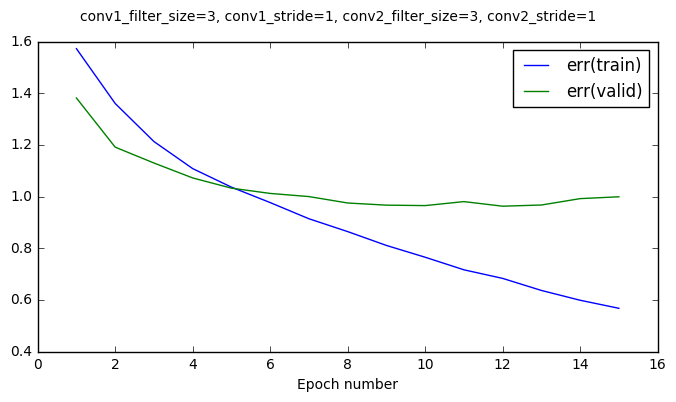

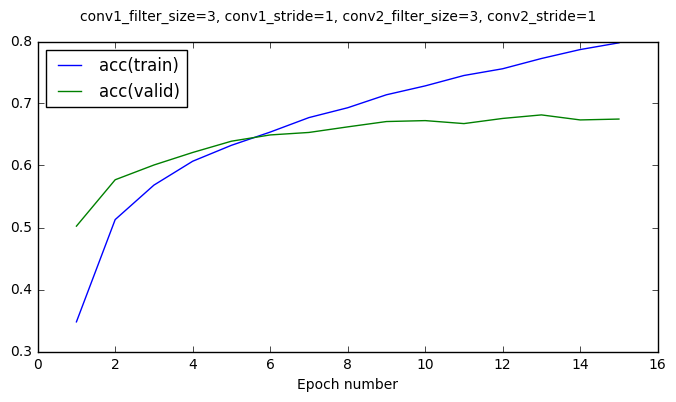

conv1_filter_size=3, conv1_stride=1, conv2_filter_size=3, conv2_stride=2

End of epoch 01: err(train)=1.82 acc(train)=0.34 err(valid)=1.47 acc(valid)=0.47 time=1.13 min
End of epoch 02: err(train)=1.50 acc(train)=0.46 err(valid)=1.35 acc(valid)=0.51 time=1.11 min
End of epoch 03: err(train)=1.40 acc(train)=0.50 err(valid)=1.28 acc(valid)=0.55 time=1.11 min
End of epoch 04: err(train)=1.33 acc(train)=0.52 err(valid)=1.22 acc(valid)=0.57 time=1.12 min
End of epoch 05: err(train)=1.27 acc(train)=0.54 err(valid)=1.19 acc(valid)=0.58 time=1.12 min
End of epoch 06: err(train)=1.22 acc(train)=0.56 err(valid)=1.14 acc(valid)=0.60 time=1.12 min
End of epoch 07: err(train)=1.18 acc(train)=0.58 err(valid)=1.12 acc(valid)=0.60 time=1.12 min
End of epoch 08: err(train)=1.15 acc(train)=0.59 err(valid)=1.11 acc(valid)=0.61 time=1.13 min
End of epoch 09: err(train)=1.11 acc(train)=0.60 err(valid)=1.09 acc(valid)=0.62 time=1.20 min
End of epoch 10: err(train)=1.09 acc(train)=0.61 err(valid)=1.07 acc(va

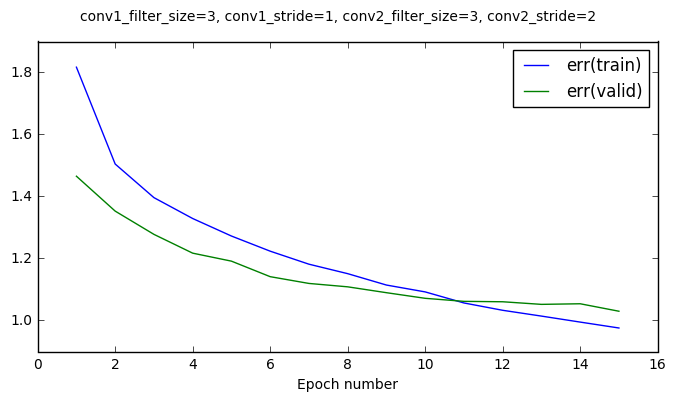

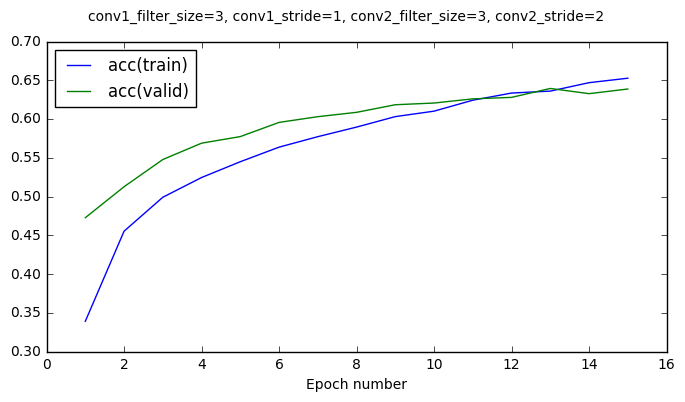

conv1_filter_size=3, conv1_stride=1, conv2_filter_size=5, conv2_stride=1

End of epoch 01: err(train)=1.68 acc(train)=0.39 err(valid)=1.38 acc(valid)=0.51 time=3.37 min
End of epoch 02: err(train)=1.35 acc(train)=0.52 err(valid)=1.24 acc(valid)=0.56 time=3.32 min
End of epoch 03: err(train)=1.22 acc(train)=0.56 err(valid)=1.15 acc(valid)=0.59 time=3.31 min
End of epoch 04: err(train)=1.13 acc(train)=0.60 err(valid)=1.07 acc(valid)=0.63 time=3.35 min
End of epoch 05: err(train)=1.05 acc(train)=0.62 err(valid)=1.04 acc(valid)=0.64 time=3.34 min
End of epoch 06: err(train)=0.98 acc(train)=0.65 err(valid)=1.04 acc(valid)=0.63 time=3.31 min
End of epoch 07: err(train)=0.92 acc(train)=0.67 err(valid)=0.99 acc(valid)=0.66 time=3.33 min
End of epoch 08: err(train)=0.86 acc(train)=0.69 err(valid)=0.99 acc(valid)=0.66 time=3.32 min
End of epoch 09: err(train)=0.81 acc(train)=0.71 err(valid)=0.98 acc(valid)=0.66 time=3.33 min
End of epoch 10: err(train)=0.77 acc(train)=0.73 err(valid)=0.99 acc(va

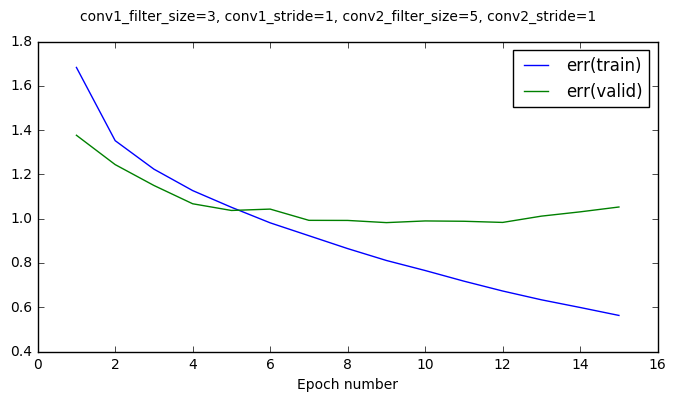

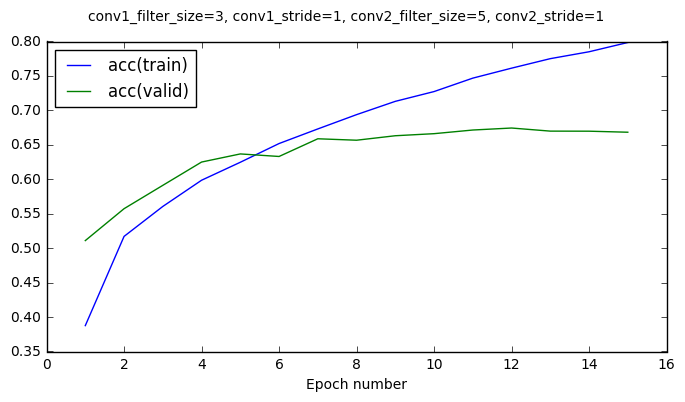

conv1_filter_size=3, conv1_stride=1, conv2_filter_size=5, conv2_stride=2

End of epoch 01: err(train)=1.82 acc(train)=0.33 err(valid)=1.48 acc(valid)=0.46 time=1.59 min
End of epoch 02: err(train)=1.51 acc(train)=0.45 err(valid)=1.33 acc(valid)=0.52 time=1.53 min
End of epoch 03: err(train)=1.39 acc(train)=0.50 err(valid)=1.26 acc(valid)=0.55 time=1.53 min
End of epoch 04: err(train)=1.31 acc(train)=0.53 err(valid)=1.21 acc(valid)=0.57 time=1.55 min
End of epoch 05: err(train)=1.25 acc(train)=0.55 err(valid)=1.17 acc(valid)=0.59 time=1.54 min
End of epoch 06: err(train)=1.19 acc(train)=0.57 err(valid)=1.13 acc(valid)=0.61 time=1.54 min
End of epoch 07: err(train)=1.15 acc(train)=0.59 err(valid)=1.12 acc(valid)=0.61 time=1.56 min
End of epoch 08: err(train)=1.11 acc(train)=0.60 err(valid)=1.09 acc(valid)=0.62 time=1.54 min
End of epoch 09: err(train)=1.08 acc(train)=0.62 err(valid)=1.08 acc(valid)=0.63 time=1.54 min
End of epoch 10: err(train)=1.05 acc(train)=0.62 err(valid)=1.05 acc(va

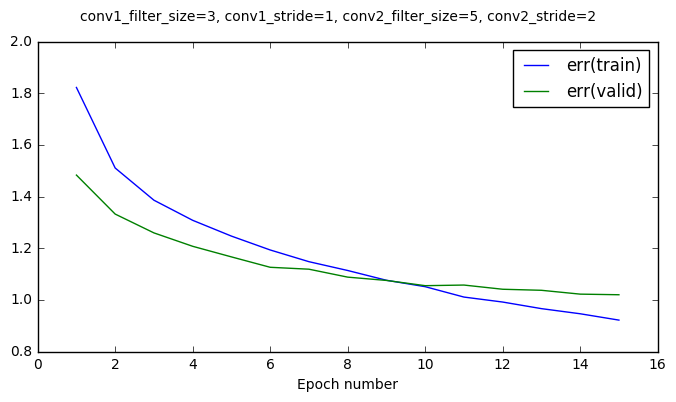

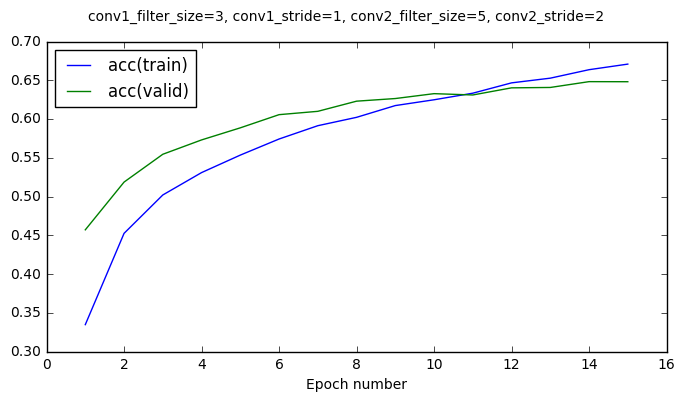

conv1_filter_size=3, conv1_stride=2, conv2_filter_size=3, conv2_stride=1

End of epoch 01: err(train)=1.87 acc(train)=0.32 err(valid)=1.54 acc(valid)=0.44 time=0.59 min
End of epoch 02: err(train)=1.57 acc(train)=0.43 err(valid)=1.42 acc(valid)=0.49 time=0.57 min
End of epoch 03: err(train)=1.46 acc(train)=0.47 err(valid)=1.34 acc(valid)=0.52 time=0.59 min
End of epoch 04: err(train)=1.39 acc(train)=0.50 err(valid)=1.28 acc(valid)=0.54 time=0.57 min
End of epoch 05: err(train)=1.33 acc(train)=0.52 err(valid)=1.27 acc(valid)=0.55 time=0.56 min
End of epoch 06: err(train)=1.29 acc(train)=0.54 err(valid)=1.23 acc(valid)=0.56 time=0.56 min
End of epoch 07: err(train)=1.25 acc(train)=0.55 err(valid)=1.22 acc(valid)=0.57 time=0.57 min
End of epoch 08: err(train)=1.22 acc(train)=0.56 err(valid)=1.19 acc(valid)=0.58 time=0.56 min
End of epoch 09: err(train)=1.19 acc(train)=0.57 err(valid)=1.19 acc(valid)=0.58 time=0.56 min
End of epoch 10: err(train)=1.16 acc(train)=0.59 err(valid)=1.15 acc(va

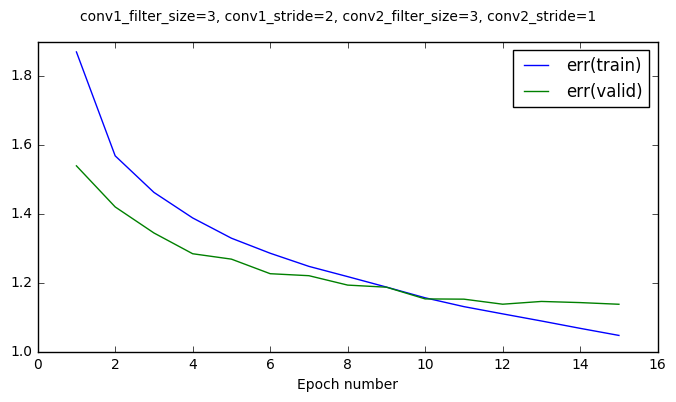

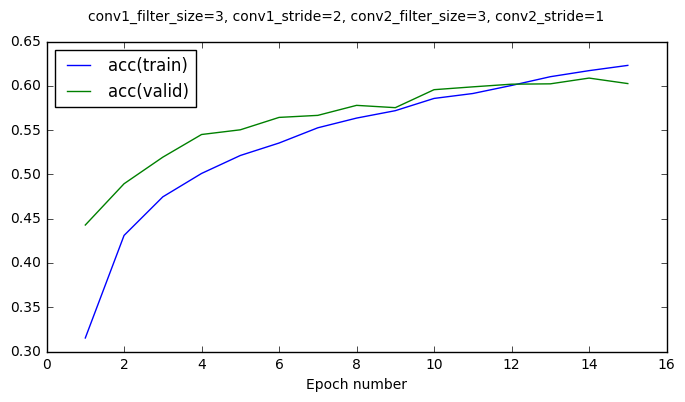

conv1_filter_size=3, conv1_stride=2, conv2_filter_size=3, conv2_stride=2

End of epoch 01: err(train)=1.92 acc(train)=0.30 err(valid)=1.60 acc(valid)=0.42 time=0.37 min
End of epoch 02: err(train)=1.66 acc(train)=0.39 err(valid)=1.49 acc(valid)=0.45 time=0.34 min
End of epoch 03: err(train)=1.58 acc(train)=0.43 err(valid)=1.44 acc(valid)=0.48 time=0.34 min
End of epoch 04: err(train)=1.53 acc(train)=0.45 err(valid)=1.40 acc(valid)=0.49 time=0.34 min
End of epoch 05: err(train)=1.49 acc(train)=0.46 err(valid)=1.37 acc(valid)=0.51 time=0.34 min
End of epoch 06: err(train)=1.45 acc(train)=0.47 err(valid)=1.34 acc(valid)=0.51 time=0.34 min
End of epoch 07: err(train)=1.42 acc(train)=0.49 err(valid)=1.31 acc(valid)=0.54 time=0.34 min
End of epoch 08: err(train)=1.39 acc(train)=0.50 err(valid)=1.30 acc(valid)=0.53 time=0.34 min
End of epoch 09: err(train)=1.38 acc(train)=0.51 err(valid)=1.29 acc(valid)=0.54 time=0.34 min
End of epoch 10: err(train)=1.36 acc(train)=0.51 err(valid)=1.27 acc(va

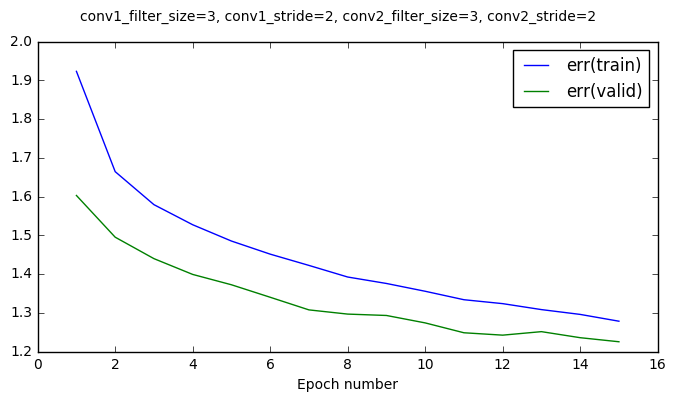

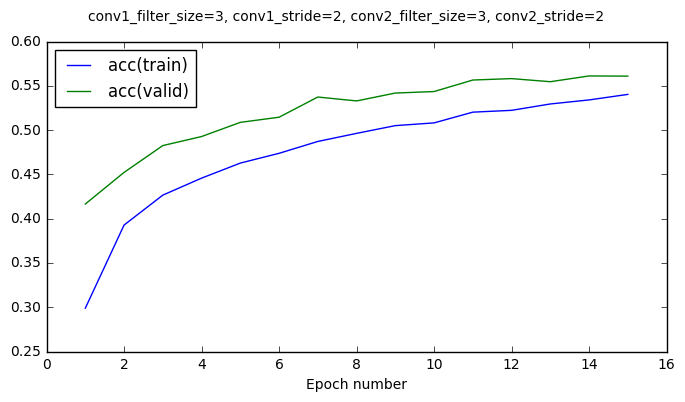

conv1_filter_size=3, conv1_stride=2, conv2_filter_size=5, conv2_stride=1

End of epoch 01: err(train)=1.82 acc(train)=0.33 err(valid)=1.51 acc(valid)=0.45 time=0.95 min
End of epoch 02: err(train)=1.54 acc(train)=0.44 err(valid)=1.40 acc(valid)=0.49 time=0.90 min
End of epoch 03: err(train)=1.44 acc(train)=0.48 err(valid)=1.33 acc(valid)=0.53 time=0.92 min
End of epoch 04: err(train)=1.36 acc(train)=0.51 err(valid)=1.26 acc(valid)=0.56 time=0.91 min
End of epoch 05: err(train)=1.30 acc(train)=0.53 err(valid)=1.24 acc(valid)=0.56 time=0.91 min
End of epoch 06: err(train)=1.25 acc(train)=0.55 err(valid)=1.20 acc(valid)=0.58 time=0.91 min
End of epoch 07: err(train)=1.21 acc(train)=0.56 err(valid)=1.19 acc(valid)=0.58 time=0.91 min
End of epoch 08: err(train)=1.17 acc(train)=0.58 err(valid)=1.17 acc(valid)=0.59 time=0.90 min
End of epoch 09: err(train)=1.14 acc(train)=0.59 err(valid)=1.14 acc(valid)=0.59 time=0.90 min
End of epoch 10: err(train)=1.10 acc(train)=0.60 err(valid)=1.14 acc(va

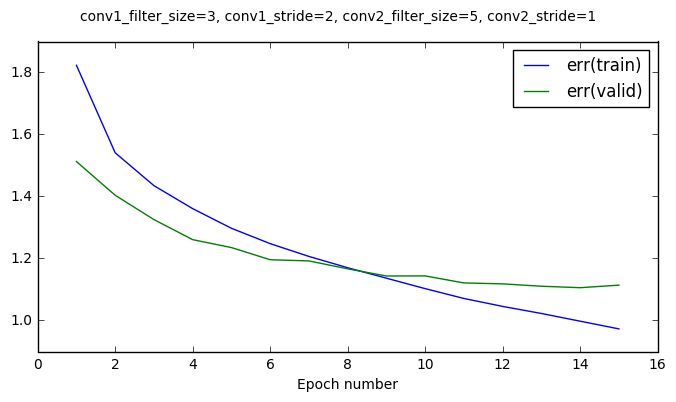

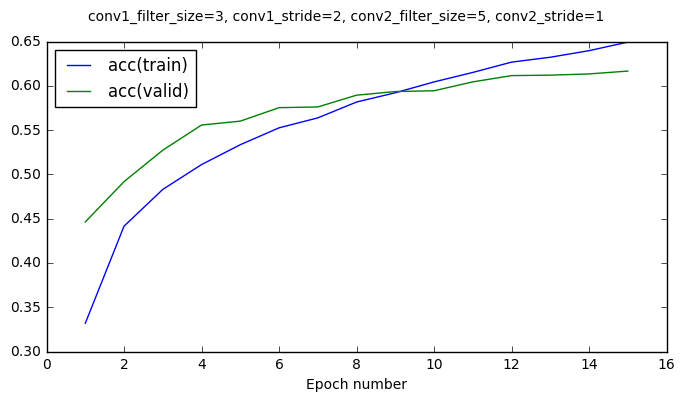

conv1_filter_size=3, conv1_stride=2, conv2_filter_size=5, conv2_stride=2

End of epoch 01: err(train)=1.87 acc(train)=0.31 err(valid)=1.56 acc(valid)=0.43 time=0.45 min
End of epoch 02: err(train)=1.60 acc(train)=0.41 err(valid)=1.46 acc(valid)=0.47 time=0.42 min
End of epoch 03: err(train)=1.53 acc(train)=0.45 err(valid)=1.40 acc(valid)=0.50 time=0.42 min
End of epoch 04: err(train)=1.47 acc(train)=0.47 err(valid)=1.34 acc(valid)=0.52 time=0.42 min
End of epoch 05: err(train)=1.41 acc(train)=0.49 err(valid)=1.30 acc(valid)=0.54 time=0.42 min
End of epoch 06: err(train)=1.38 acc(train)=0.51 err(valid)=1.28 acc(valid)=0.54 time=0.42 min
End of epoch 07: err(train)=1.33 acc(train)=0.52 err(valid)=1.26 acc(valid)=0.55 time=0.41 min
End of epoch 08: err(train)=1.31 acc(train)=0.53 err(valid)=1.23 acc(valid)=0.57 time=0.42 min
End of epoch 09: err(train)=1.28 acc(train)=0.54 err(valid)=1.21 acc(valid)=0.58 time=0.41 min
End of epoch 10: err(train)=1.25 acc(train)=0.55 err(valid)=1.21 acc(va

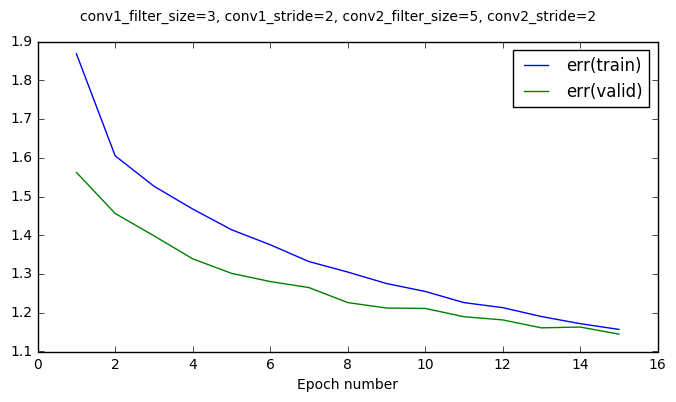

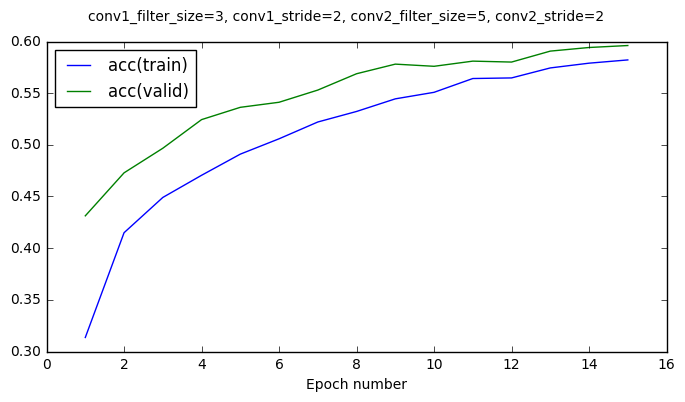

conv1_filter_size=5, conv1_stride=1, conv2_filter_size=3, conv2_stride=1

End of epoch 01: err(train)=1.69 acc(train)=0.39 err(valid)=1.39 acc(valid)=0.50 time=2.64 min
End of epoch 02: err(train)=1.39 acc(train)=0.50 err(valid)=1.26 acc(valid)=0.56 time=2.62 min
End of epoch 03: err(train)=1.27 acc(train)=0.55 err(valid)=1.20 acc(valid)=0.58 time=2.58 min
End of epoch 04: err(train)=1.18 acc(train)=0.58 err(valid)=1.15 acc(valid)=0.60 time=2.58 min
End of epoch 05: err(train)=1.11 acc(train)=0.60 err(valid)=1.12 acc(valid)=0.60 time=2.60 min
End of epoch 06: err(train)=1.04 acc(train)=0.63 err(valid)=1.08 acc(valid)=0.62 time=2.59 min
End of epoch 07: err(train)=0.99 acc(train)=0.64 err(valid)=1.06 acc(valid)=0.63 time=2.58 min
End of epoch 08: err(train)=0.93 acc(train)=0.66 err(valid)=1.05 acc(valid)=0.64 time=2.59 min
End of epoch 09: err(train)=0.89 acc(train)=0.69 err(valid)=1.06 acc(valid)=0.64 time=2.60 min
End of epoch 10: err(train)=0.84 acc(train)=0.70 err(valid)=1.04 acc(va

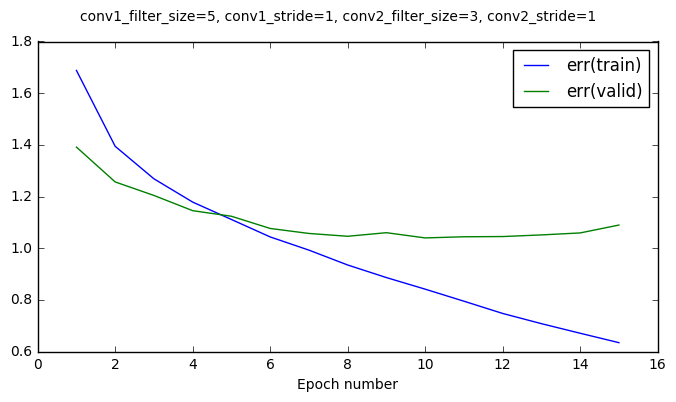

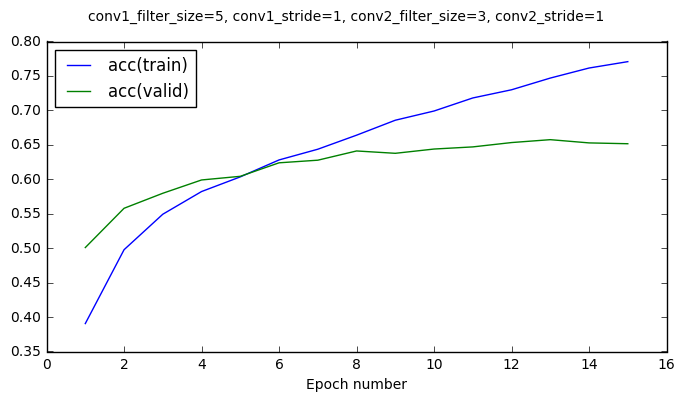

conv1_filter_size=5, conv1_stride=1, conv2_filter_size=3, conv2_stride=2

End of epoch 01: err(train)=1.84 acc(train)=0.33 err(valid)=1.53 acc(valid)=0.44 time=1.69 min
End of epoch 02: err(train)=1.57 acc(train)=0.43 err(valid)=1.41 acc(valid)=0.50 time=1.64 min
End of epoch 03: err(train)=1.47 acc(train)=0.47 err(valid)=1.34 acc(valid)=0.52 time=1.64 min
End of epoch 04: err(train)=1.40 acc(train)=0.50 err(valid)=1.28 acc(valid)=0.55 time=1.51 min
End of epoch 05: err(train)=1.34 acc(train)=0.52 err(valid)=1.25 acc(valid)=0.56 time=1.49 min
End of epoch 06: err(train)=1.30 acc(train)=0.53 err(valid)=1.21 acc(valid)=0.57 time=1.51 min
End of epoch 07: err(train)=1.26 acc(train)=0.55 err(valid)=1.18 acc(valid)=0.58 time=1.50 min
End of epoch 08: err(train)=1.23 acc(train)=0.56 err(valid)=1.17 acc(valid)=0.59 time=1.50 min
End of epoch 09: err(train)=1.19 acc(train)=0.57 err(valid)=1.16 acc(valid)=0.59 time=1.50 min
End of epoch 10: err(train)=1.17 acc(train)=0.58 err(valid)=1.16 acc(va

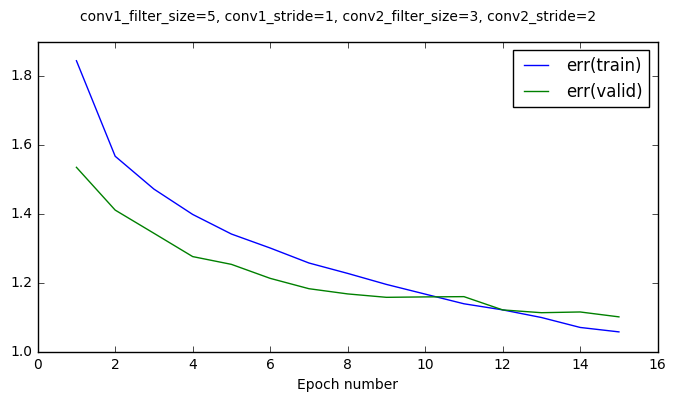

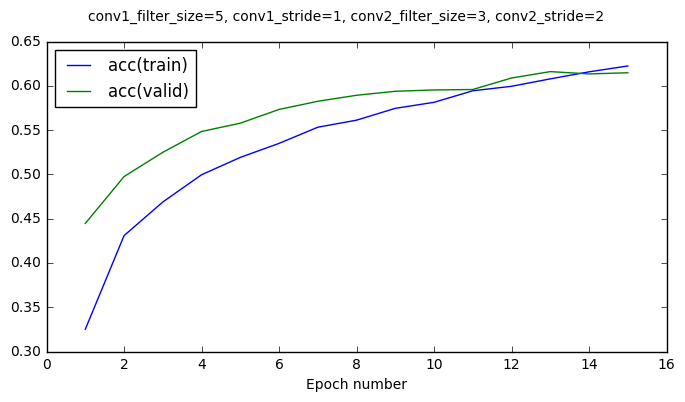

conv1_filter_size=5, conv1_stride=1, conv2_filter_size=5, conv2_stride=1

End of epoch 01: err(train)=1.70 acc(train)=0.38 err(valid)=1.38 acc(valid)=0.51 time=3.51 min
End of epoch 02: err(train)=1.38 acc(train)=0.50 err(valid)=1.27 acc(valid)=0.55 time=3.49 min
End of epoch 03: err(train)=1.26 acc(train)=0.55 err(valid)=1.20 acc(valid)=0.58 time=3.56 min
End of epoch 04: err(train)=1.16 acc(train)=0.59 err(valid)=1.15 acc(valid)=0.60 time=3.47 min
End of epoch 05: err(train)=1.10 acc(train)=0.61 err(valid)=1.10 acc(valid)=0.62 time=3.48 min
End of epoch 06: err(train)=1.04 acc(train)=0.63 err(valid)=1.08 acc(valid)=0.62 time=3.48 min
End of epoch 07: err(train)=0.97 acc(train)=0.65 err(valid)=1.05 acc(valid)=0.64 time=3.46 min
End of epoch 08: err(train)=0.93 acc(train)=0.67 err(valid)=1.06 acc(valid)=0.63 time=3.46 min
End of epoch 09: err(train)=0.87 acc(train)=0.69 err(valid)=1.07 acc(valid)=0.63 time=3.49 min
End of epoch 10: err(train)=0.83 acc(train)=0.71 err(valid)=1.05 acc(va

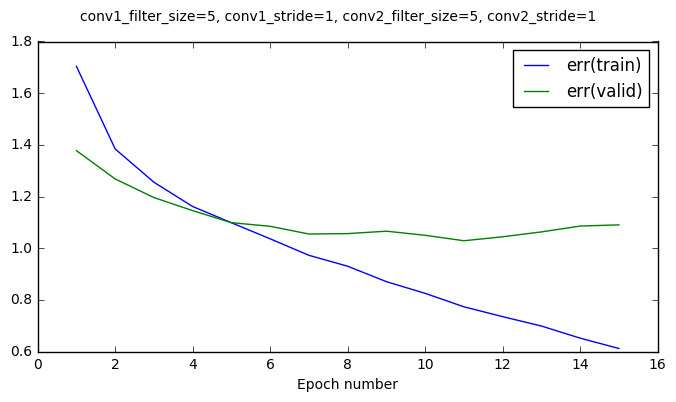

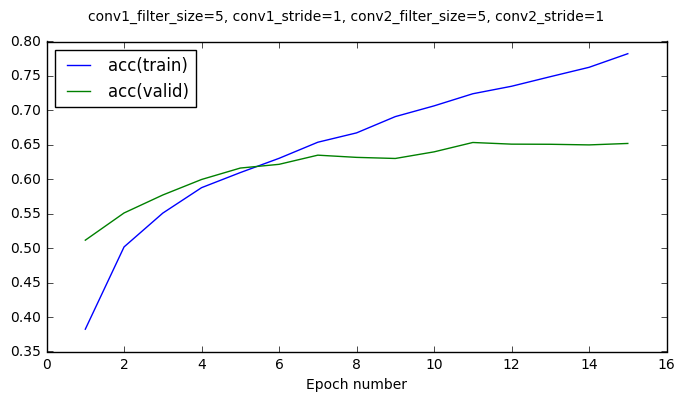

conv1_filter_size=5, conv1_stride=1, conv2_filter_size=5, conv2_stride=2

End of epoch 01: err(train)=1.84 acc(train)=0.33 err(valid)=1.50 acc(valid)=0.46 time=1.84 min
End of epoch 02: err(train)=1.54 acc(train)=0.44 err(valid)=1.39 acc(valid)=0.50 time=1.81 min
End of epoch 03: err(train)=1.43 acc(train)=0.48 err(valid)=1.31 acc(valid)=0.53 time=1.83 min
End of epoch 04: err(train)=1.37 acc(train)=0.51 err(valid)=1.28 acc(valid)=0.55 time=1.82 min
End of epoch 05: err(train)=1.30 acc(train)=0.53 err(valid)=1.22 acc(valid)=0.56 time=1.86 min
End of epoch 06: err(train)=1.25 acc(train)=0.55 err(valid)=1.19 acc(valid)=0.58 time=1.80 min
End of epoch 07: err(train)=1.22 acc(train)=0.56 err(valid)=1.17 acc(valid)=0.58 time=1.81 min
End of epoch 08: err(train)=1.17 acc(train)=0.58 err(valid)=1.15 acc(valid)=0.59 time=1.82 min
End of epoch 09: err(train)=1.14 acc(train)=0.59 err(valid)=1.13 acc(valid)=0.61 time=1.81 min
End of epoch 10: err(train)=1.11 acc(train)=0.61 err(valid)=1.13 acc(va

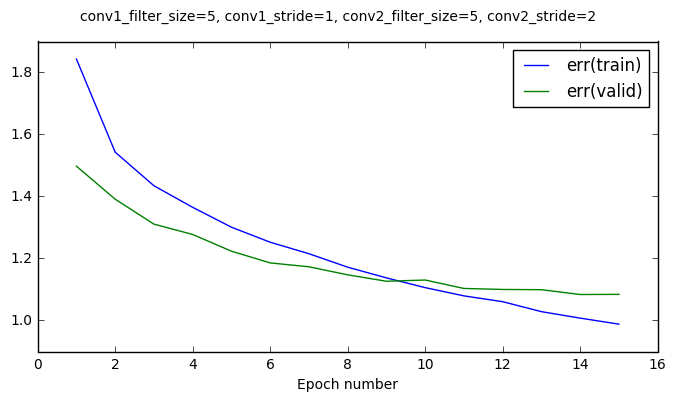

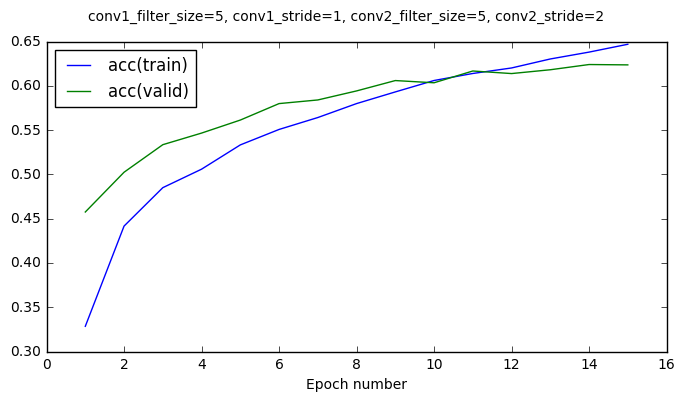

conv1_filter_size=5, conv1_stride=2, conv2_filter_size=3, conv2_stride=1

End of epoch 01: err(train)=1.86 acc(train)=0.32 err(valid)=1.55 acc(valid)=0.44 time=0.65 min
End of epoch 02: err(train)=1.58 acc(train)=0.43 err(valid)=1.45 acc(valid)=0.48 time=0.63 min
End of epoch 03: err(train)=1.49 acc(train)=0.46 err(valid)=1.37 acc(valid)=0.51 time=0.63 min
End of epoch 04: err(train)=1.42 acc(train)=0.49 err(valid)=1.31 acc(valid)=0.53 time=0.64 min
End of epoch 05: err(train)=1.36 acc(train)=0.51 err(valid)=1.28 acc(valid)=0.55 time=0.64 min
End of epoch 06: err(train)=1.31 acc(train)=0.53 err(valid)=1.25 acc(valid)=0.55 time=0.64 min
End of epoch 07: err(train)=1.27 acc(train)=0.54 err(valid)=1.21 acc(valid)=0.58 time=0.64 min
End of epoch 08: err(train)=1.23 acc(train)=0.56 err(valid)=1.20 acc(valid)=0.58 time=0.63 min
End of epoch 09: err(train)=1.21 acc(train)=0.57 err(valid)=1.19 acc(valid)=0.58 time=0.63 min
End of epoch 10: err(train)=1.18 acc(train)=0.58 err(valid)=1.19 acc(va

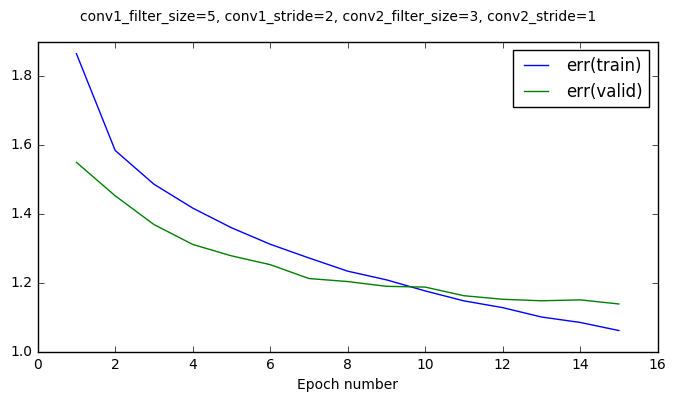

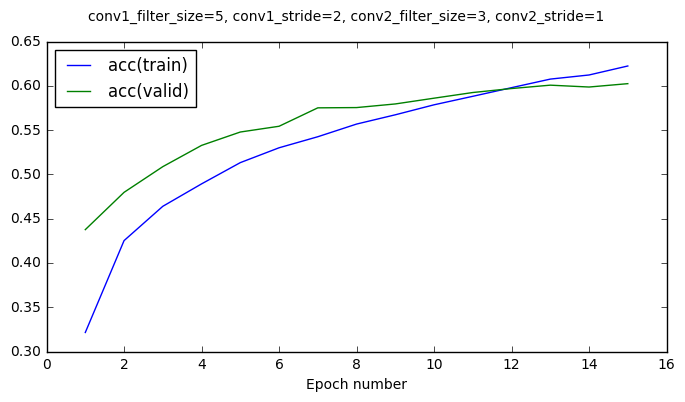

conv1_filter_size=5, conv1_stride=2, conv2_filter_size=3, conv2_stride=2

End of epoch 01: err(train)=1.92 acc(train)=0.30 err(valid)=1.60 acc(valid)=0.41 time=0.45 min
End of epoch 02: err(train)=1.66 acc(train)=0.39 err(valid)=1.50 acc(valid)=0.45 time=0.42 min
End of epoch 03: err(train)=1.59 acc(train)=0.42 err(valid)=1.46 acc(valid)=0.48 time=0.41 min
End of epoch 04: err(train)=1.54 acc(train)=0.44 err(valid)=1.42 acc(valid)=0.48 time=0.42 min
End of epoch 05: err(train)=1.51 acc(train)=0.45 err(valid)=1.40 acc(valid)=0.50 time=0.41 min
End of epoch 06: err(train)=1.47 acc(train)=0.47 err(valid)=1.37 acc(valid)=0.51 time=0.41 min
End of epoch 07: err(train)=1.45 acc(train)=0.48 err(valid)=1.35 acc(valid)=0.51 time=0.41 min
End of epoch 08: err(train)=1.42 acc(train)=0.49 err(valid)=1.33 acc(valid)=0.52 time=0.41 min
End of epoch 09: err(train)=1.40 acc(train)=0.49 err(valid)=1.30 acc(valid)=0.54 time=0.41 min
End of epoch 10: err(train)=1.38 acc(train)=0.50 err(valid)=1.30 acc(va

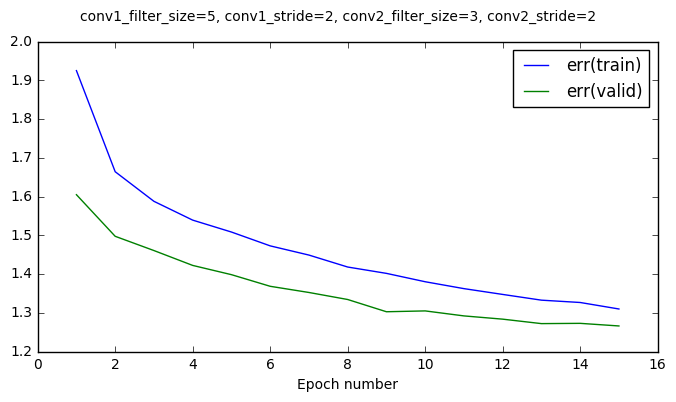

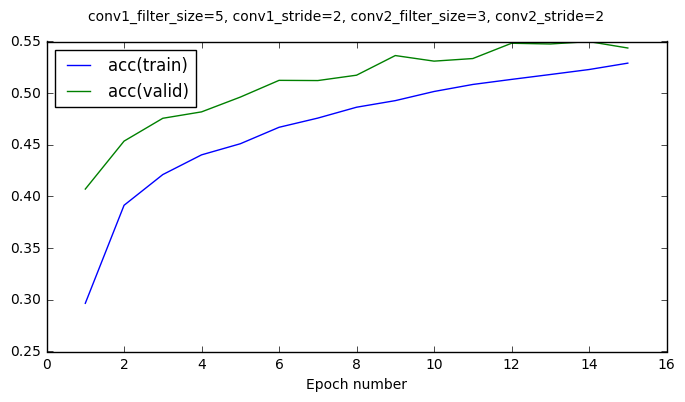

conv1_filter_size=5, conv1_stride=2, conv2_filter_size=5, conv2_stride=1

End of epoch 01: err(train)=1.86 acc(train)=0.32 err(valid)=1.54 acc(valid)=0.44 time=0.95 min
End of epoch 02: err(train)=1.56 acc(train)=0.43 err(valid)=1.44 acc(valid)=0.48 time=0.94 min
End of epoch 03: err(train)=1.47 acc(train)=0.47 err(valid)=1.36 acc(valid)=0.51 time=0.94 min
End of epoch 04: err(train)=1.40 acc(train)=0.50 err(valid)=1.29 acc(valid)=0.54 time=0.96 min
End of epoch 05: err(train)=1.35 acc(train)=0.51 err(valid)=1.27 acc(valid)=0.55 time=0.94 min
End of epoch 06: err(train)=1.30 acc(train)=0.53 err(valid)=1.26 acc(valid)=0.55 time=0.95 min
End of epoch 07: err(train)=1.25 acc(train)=0.55 err(valid)=1.22 acc(valid)=0.57 time=0.94 min
End of epoch 08: err(train)=1.21 acc(train)=0.56 err(valid)=1.19 acc(valid)=0.58 time=0.94 min
End of epoch 09: err(train)=1.18 acc(train)=0.57 err(valid)=1.21 acc(valid)=0.57 time=0.94 min
End of epoch 10: err(train)=1.16 acc(train)=0.59 err(valid)=1.16 acc(va

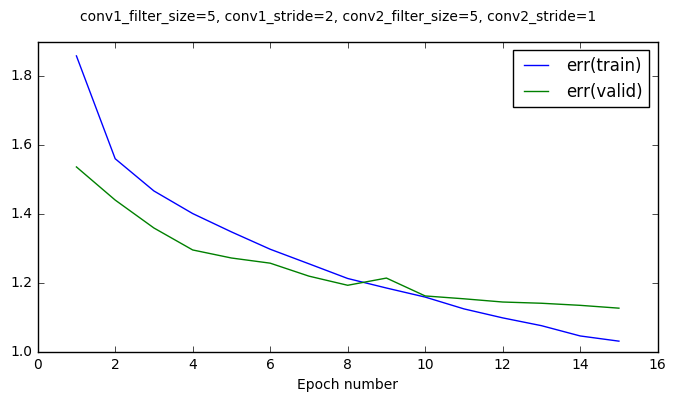

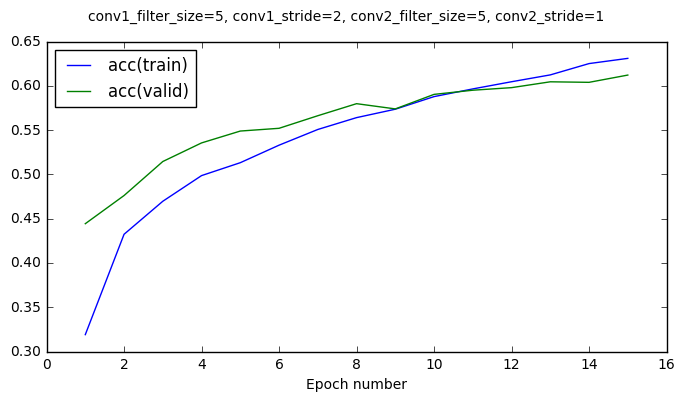

conv1_filter_size=5, conv1_stride=2, conv2_filter_size=5, conv2_stride=2

End of epoch 01: err(train)=1.91 acc(train)=0.30 err(valid)=1.59 acc(valid)=0.42 time=0.51 min
End of epoch 02: err(train)=1.64 acc(train)=0.40 err(valid)=1.48 acc(valid)=0.46 time=0.49 min
End of epoch 03: err(train)=1.55 acc(train)=0.44 err(valid)=1.44 acc(valid)=0.48 time=0.49 min
End of epoch 04: err(train)=1.50 acc(train)=0.46 err(valid)=1.38 acc(valid)=0.50 time=0.48 min
End of epoch 05: err(train)=1.45 acc(train)=0.48 err(valid)=1.35 acc(valid)=0.52 time=0.48 min
End of epoch 06: err(train)=1.41 acc(train)=0.49 err(valid)=1.32 acc(valid)=0.52 time=0.48 min
End of epoch 07: err(train)=1.37 acc(train)=0.50 err(valid)=1.30 acc(valid)=0.54 time=0.48 min
End of epoch 08: err(train)=1.34 acc(train)=0.52 err(valid)=1.27 acc(valid)=0.55 time=0.49 min
End of epoch 09: err(train)=1.32 acc(train)=0.53 err(valid)=1.25 acc(valid)=0.55 time=0.48 min
End of epoch 10: err(train)=1.28 acc(train)=0.54 err(valid)=1.23 acc(va

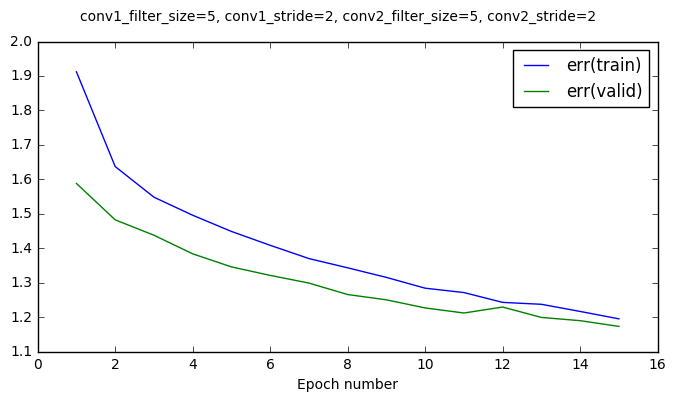

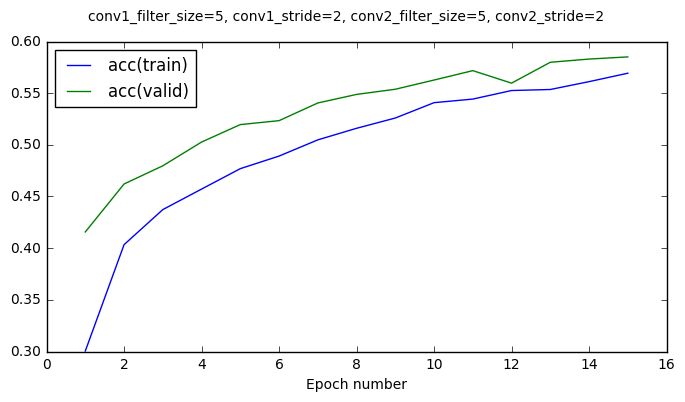

In [76]:
# Create directory (has suffix for today's date).
# Then DELETE all files in path if there are files already there.
subdir = 'cnn_filter_faster'
save_path = create_and_return_path(subdir, save_path_main)
clear_dir(save_path)

# Define hyperparameters
params = {
    'learning_rate': 1e-3,  # used to be 1e-4
    'conv1_filter_size': 3,
    'conv1_num_filters': 32,
    'conv1_stride': 1,
    'pool1_k_width': 2,
    'pool1_stride': 2,
    'conv2_filter_size': 3,
    'conv2_num_filters': 64,
    'conv2_stride': 1,
    'pool2_k_width': 2,
    'pool2_stride': 2,
    'fc1_num_outputs': 384,
    'fc2_num_outputs': 192,
    'keep_prob': 0.5,  # used to be 0.75
    'fc_batch_norm': True,
    'conv_batch_norm': False
}

stats = OrderedDict()

num_epoch = 15

iter_vars = make_filter_iter_vars()
iter_strs = make_filter_iter_strs(iter_vars)
if len(iter_vars) != len(iter_strs):
    print 'lengths DO NOT match. Bad!!!'

for iter_var, iter_str in zip(iter_vars, iter_strs):

    print '==========\n{}\n'.format(iter_str)
    # print params
    stats_one = {'err(train)': [], 'acc(train)': [], 'err(valid)': [], 'acc(valid)': []}
    
    params['conv1_filter_size'], params['conv1_stride'], params['conv2_filter_size'], params['conv2_stride'] = iter_var
    stats[iter_str] = run_cnn_model(params, save_path)
    
    # Pickle all important objects
    pickle.dump(stats, open(os.path.join(save_path_main, subdir, "stats.p"), "wb"))

path created: run/coursework4/cnn_filter_faster/2017-03-14


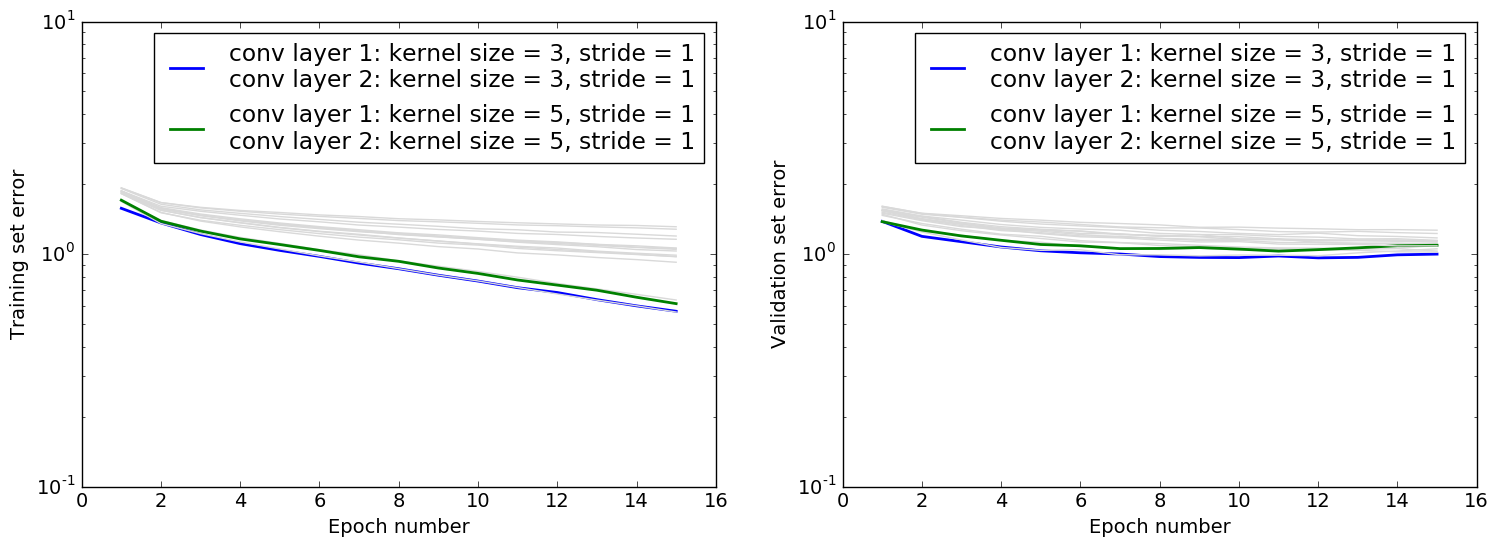

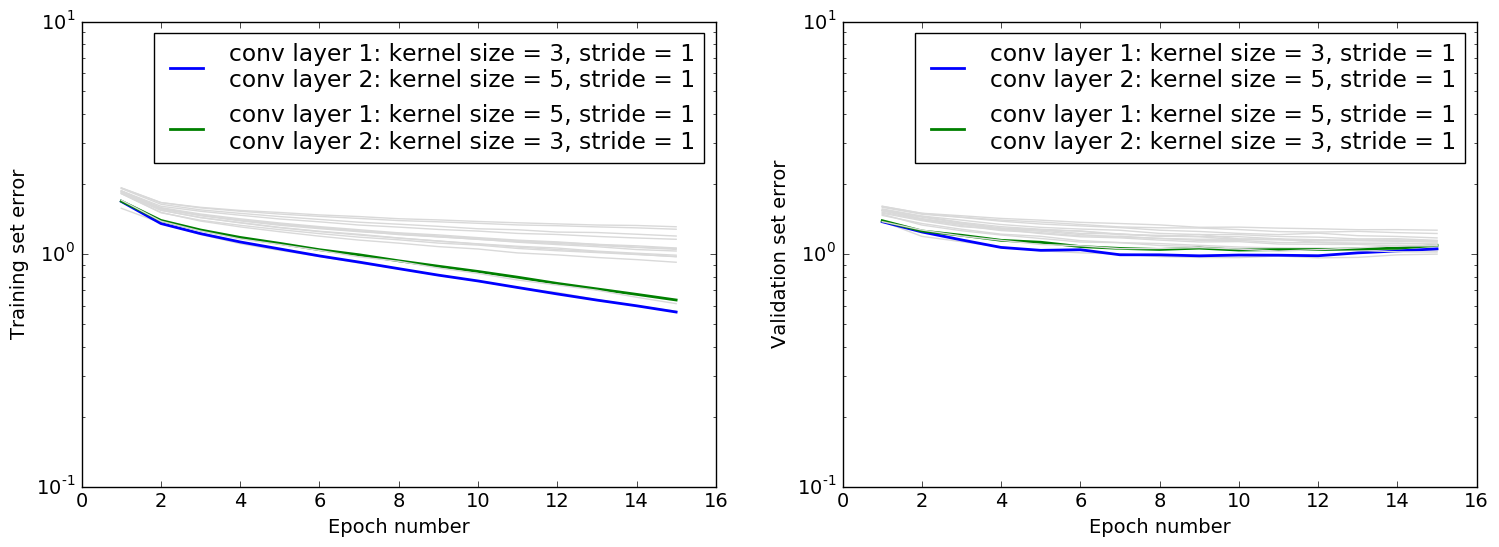

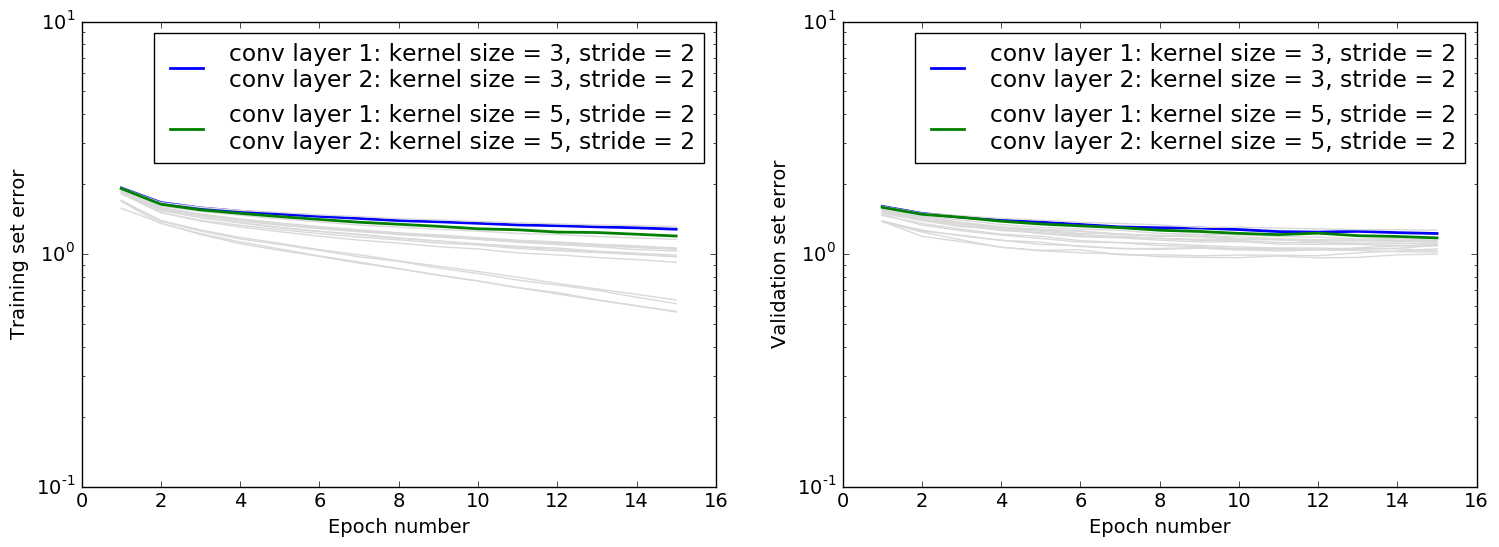

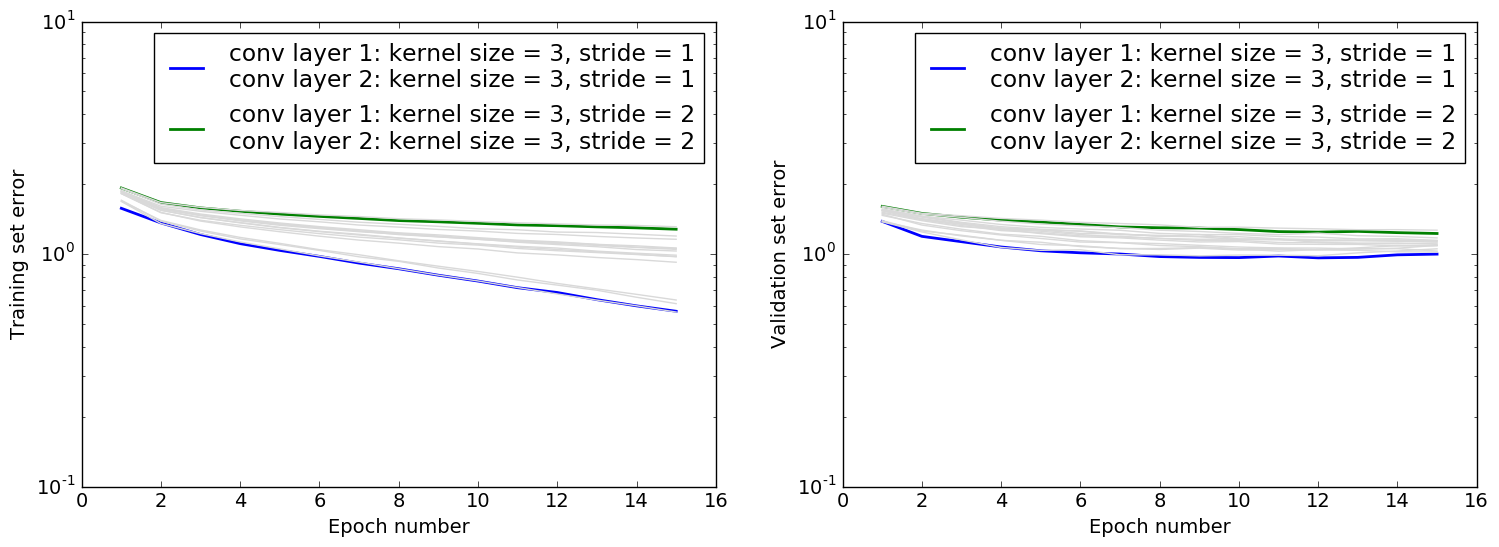

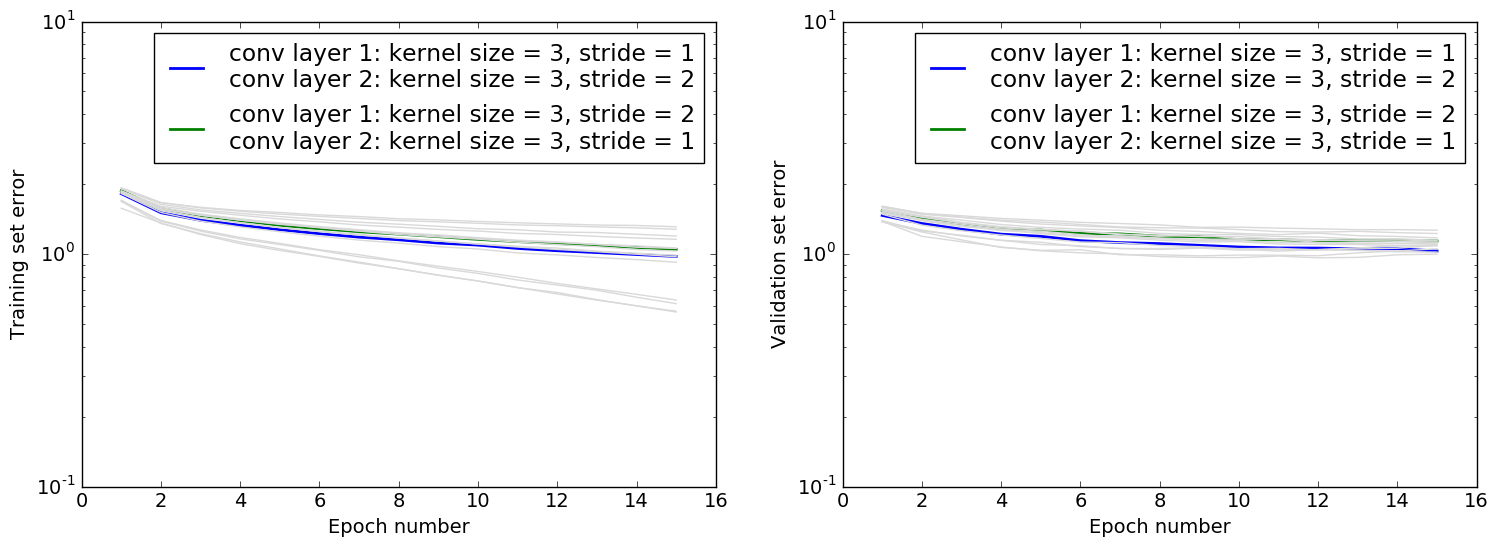

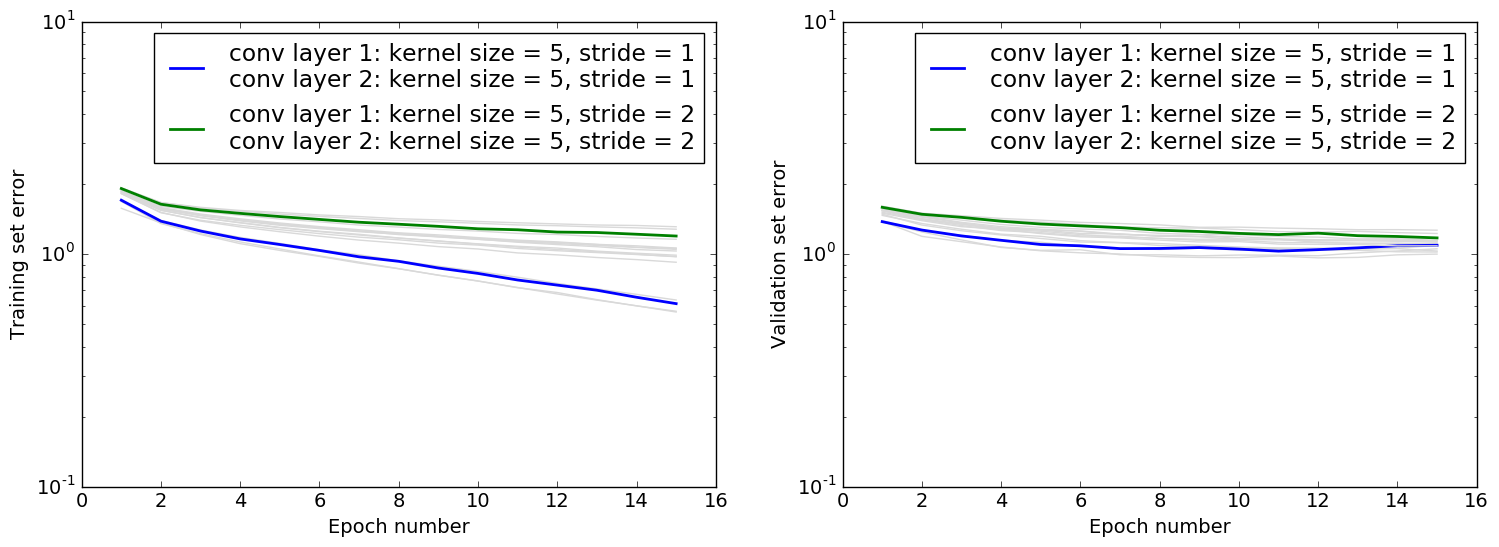

In [80]:
subdir = 'cnn_filter_faster'
save_path = create_and_return_path(subdir, save_path_main)
stats = pickle.load(open(os.path.join(save_path_main, subdir, "stats.p"), "rb"))

# Helper functions.
compare = lambda x, y: collections.Counter(x) == collections.Counter(y)
iterstr2values = lambda iter_str: [int(s) for s in iter_str if s.isdigit()][1::2]
def values2label(values):
    label = ('conv layer 1: kernel size = {}, stride = {}\n' +\
             'conv layer 2: kernel size = {}, stride = {}').format(*values)
    return label
iterstr2label = lambda iter_str: values2label(iterstr2values(iter_str))
values2short = lambda values: ''.join(str(v) for v in values)

iters_to_compare_list = [
    [[3, 1, 3, 1], [5, 1, 5, 1]],
    [[3, 1, 5, 1], [5, 1, 3, 1]],
    [[3, 2, 3, 2], [5, 2, 5, 2]],
    [[3, 1, 3, 1], [3, 2, 3, 2]],
    [[3, 2, 3, 1], [3, 1, 3, 2]],
    [[5, 1, 5, 1], [5, 2, 5, 2]]
]

for iters_to_compare in iters_to_compare_list:

    # Plot stuff. Can't use default b/c there are too many lines.
    fig = plt.figure(figsize=(18, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    for iter_str, stats_sub in stats.iteritems():
        values = [int(s) for s in iter_str if s.isdigit()][1::2]
        if any(compare(values, v) for v in iters_to_compare):
            color = None
            label = values2label(values)
            linewidth = 2
        else:
            color = '0.85'
            label = None
            linewidth = None
        num_epoch = len(stats_sub.values()[0])
        ax1.plot(np.arange(1, num_epoch + 1), 
                 stats_sub['err(train)'], linewidth=linewidth, color=color, label=label)
        ax2.plot(np.arange(1, num_epoch + 1), 
                 stats_sub['err(valid)'], linewidth=linewidth, color=color, label=label)
    ax1.legend(loc=0)
    ax1.set_xlabel('Epoch number')
    ax1.set_ylabel('Training set error')
    ax1.set_yscale('log')
    ax2.legend(loc=0)
    ax2.set_xlabel('Epoch number')
    ax2.set_ylabel('Validation set error')
    ax2.set_yscale('log')
    
    with plt.rc_context(rc={'text.usetex': False}):
        plt.savefig(os.path.join(save_path, 'cnn_filter_{}-{}.pdf'.format(*[values2short(v) for v in iters_to_compare])))

In [98]:
for iter_str, values in stats.iteritems():
    print '{}, {}, {}, {}'.format(*iterstr2values(iter_str)) + ', {}'.format(values['time'])

3, 1, 3, 1, 3850.81297898
3, 1, 3, 2, 2221.0943439
3, 1, 5, 1, 6071.5004971
3, 1, 5, 2, 2632.20590401
3, 2, 3, 1, 1000.31606698
3, 2, 3, 2, 567.601837873
3, 2, 5, 1, 1549.52508783
3, 2, 5, 2, 762.24008894
5, 1, 3, 1, 4686.93790412
5, 1, 3, 2, 3077.58427
5, 1, 5, 1, 6910.99969816
5, 1, 5, 2, 3584.71279407
5, 2, 3, 1, 1269.261338
5, 2, 3, 2, 840.99898386
5, 2, 5, 1, 1737.72980618
5, 2, 5, 2, 952.772051811


In [136]:
# pd.DataFrame.from_dict(stats, orient='index').to_csv(os.path.join(save_path, 'tmp.csv'))

## Pooling

In [77]:
def make_pool_iter_vars():
    iter_vars = []
    # for pool1_k_width in [2, 3]:
    #     for pool1_stride in [2]:
    #         for pool2_k_width in [2, 3]:
    #             for pool2_stride in [2]:
    #                 iter_vars.append([pool1_k_width, pool1_stride, pool2_k_width, pool2_stride])
    iter_vars = [[2, 2, 2, 2], [3, 2, 3, 2], [3, 3, 3, 3], [3, 2, 2, 2], [2, 2, 3, 2], [2, 1, 2, 1]]
    return iter_vars

def make_pool_iter_strs(pool_iter_vars):
    iter_strs = []
    for pool_iter_var in pool_iter_vars:
        iter_strs.append('pool1_k_width={}, pool1_stride={}, pool2_k_width={}, pool2_stride={}'.format(*pool_iter_var))
    return iter_strs

path created: run/coursework4/cnn_pool_faster/2017-03-14
deleting files in: run/coursework4/cnn_pool_faster/2017-03-14
pool1_k_width=2, pool1_stride=2, pool2_k_width=2, pool2_stride=2

End of epoch 01: err(train)=1.68 acc(train)=0.39 err(valid)=1.36 acc(valid)=0.51 time=2.02 min
End of epoch 02: err(train)=1.34 acc(train)=0.52 err(valid)=1.19 acc(valid)=0.58 time=2.01 min
End of epoch 03: err(train)=1.19 acc(train)=0.58 err(valid)=1.11 acc(valid)=0.61 time=1.97 min
End of epoch 04: err(train)=1.10 acc(train)=0.61 err(valid)=1.05 acc(valid)=0.63 time=1.97 min
End of epoch 05: err(train)=1.02 acc(train)=0.64 err(valid)=1.01 acc(valid)=0.65 time=1.96 min
End of epoch 06: err(train)=0.96 acc(train)=0.66 err(valid)=0.99 acc(valid)=0.66 time=1.98 min
End of epoch 07: err(train)=0.90 acc(train)=0.68 err(valid)=0.99 acc(valid)=0.66 time=1.97 min
End of epoch 08: err(train)=0.84 acc(train)=0.70 err(valid)=0.98 acc(valid)=0.67 time=1.97 min
End of epoch 09: err(train)=0.80 acc(train)=0.72 err(va

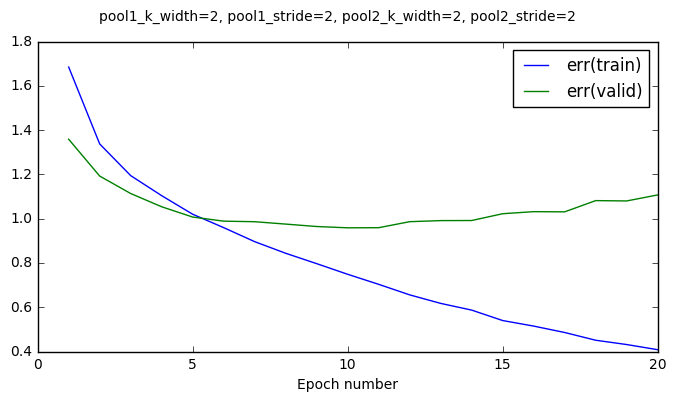

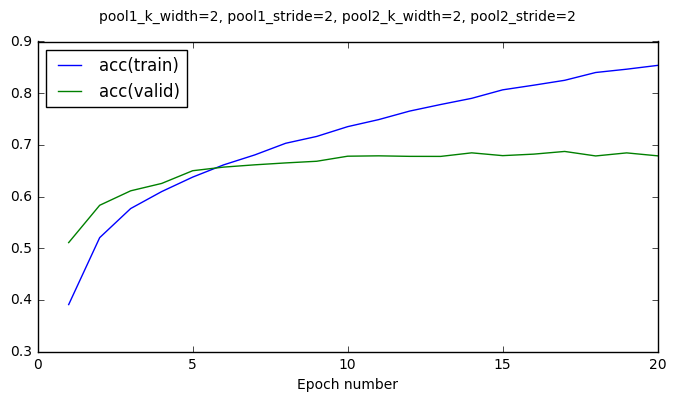

pool1_k_width=3, pool1_stride=2, pool2_k_width=3, pool2_stride=2

End of epoch 01: err(train)=1.70 acc(train)=0.38 err(valid)=1.36 acc(valid)=0.52 time=2.11 min
End of epoch 02: err(train)=1.35 acc(train)=0.51 err(valid)=1.22 acc(valid)=0.57 time=2.05 min
End of epoch 03: err(train)=1.22 acc(train)=0.57 err(valid)=1.13 acc(valid)=0.60 time=2.05 min
End of epoch 04: err(train)=1.13 acc(train)=0.60 err(valid)=1.08 acc(valid)=0.62 time=2.05 min
End of epoch 05: err(train)=1.06 acc(train)=0.62 err(valid)=1.05 acc(valid)=0.64 time=2.05 min
End of epoch 06: err(train)=1.00 acc(train)=0.64 err(valid)=1.02 acc(valid)=0.64 time=2.06 min
End of epoch 07: err(train)=0.95 acc(train)=0.66 err(valid)=1.01 acc(valid)=0.65 time=2.05 min
End of epoch 08: err(train)=0.89 acc(train)=0.68 err(valid)=1.00 acc(valid)=0.65 time=2.05 min
End of epoch 09: err(train)=0.85 acc(train)=0.70 err(valid)=1.01 acc(valid)=0.65 time=2.04 min
End of epoch 10: err(train)=0.81 acc(train)=0.71 err(valid)=0.99 acc(valid)=0.6

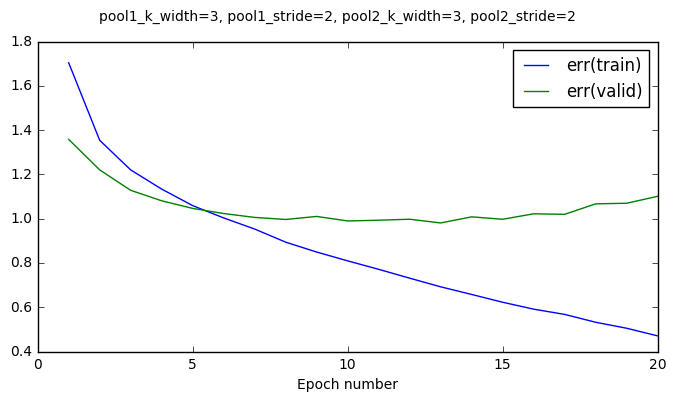

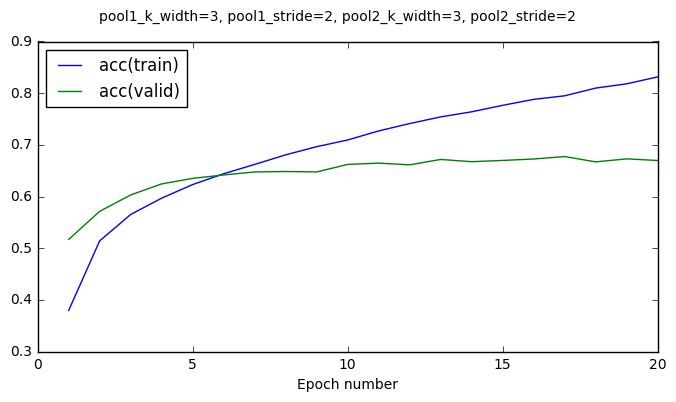

pool1_k_width=3, pool1_stride=3, pool2_k_width=3, pool2_stride=3

End of epoch 01: err(train)=1.84 acc(train)=0.32 err(valid)=1.49 acc(valid)=0.46 time=1.29 min
End of epoch 02: err(train)=1.53 acc(train)=0.45 err(valid)=1.36 acc(valid)=0.51 time=1.26 min
End of epoch 03: err(train)=1.41 acc(train)=0.49 err(valid)=1.30 acc(valid)=0.54 time=1.26 min
End of epoch 04: err(train)=1.33 acc(train)=0.52 err(valid)=1.22 acc(valid)=0.56 time=1.26 min
End of epoch 05: err(train)=1.27 acc(train)=0.54 err(valid)=1.19 acc(valid)=0.58 time=1.26 min
End of epoch 06: err(train)=1.23 acc(train)=0.56 err(valid)=1.16 acc(valid)=0.59 time=1.26 min
End of epoch 07: err(train)=1.19 acc(train)=0.58 err(valid)=1.13 acc(valid)=0.60 time=1.26 min
End of epoch 08: err(train)=1.15 acc(train)=0.59 err(valid)=1.12 acc(valid)=0.61 time=1.26 min
End of epoch 09: err(train)=1.12 acc(train)=0.60 err(valid)=1.10 acc(valid)=0.62 time=1.27 min
End of epoch 10: err(train)=1.10 acc(train)=0.61 err(valid)=1.10 acc(valid)=0.6

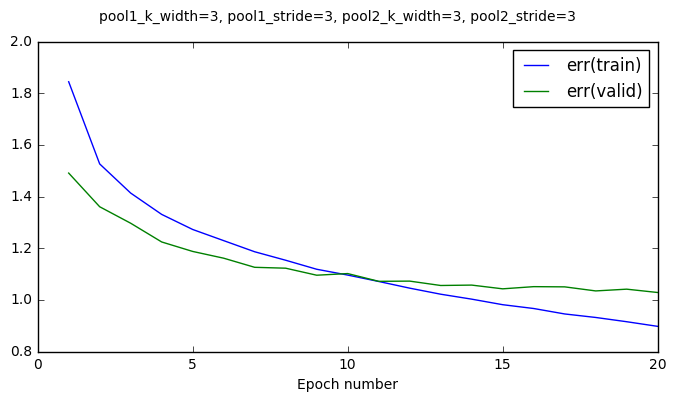

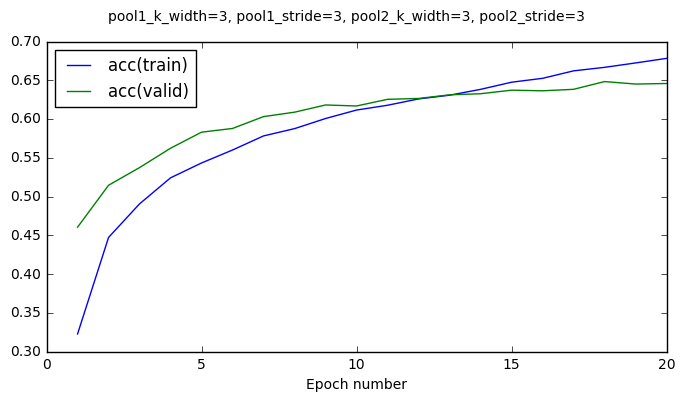

pool1_k_width=3, pool1_stride=2, pool2_k_width=2, pool2_stride=2

End of epoch 01: err(train)=1.66 acc(train)=0.40 err(valid)=1.33 acc(valid)=0.53 time=2.05 min
End of epoch 02: err(train)=1.31 acc(train)=0.53 err(valid)=1.19 acc(valid)=0.58 time=2.00 min
End of epoch 03: err(train)=1.19 acc(train)=0.58 err(valid)=1.12 acc(valid)=0.60 time=2.03 min
End of epoch 04: err(train)=1.10 acc(train)=0.61 err(valid)=1.07 acc(valid)=0.62 time=2.01 min
End of epoch 05: err(train)=1.04 acc(train)=0.63 err(valid)=1.04 acc(valid)=0.64 time=2.00 min
End of epoch 06: err(train)=0.98 acc(train)=0.65 err(valid)=1.00 acc(valid)=0.65 time=2.01 min
End of epoch 07: err(train)=0.92 acc(train)=0.67 err(valid)=0.98 acc(valid)=0.66 time=2.00 min
End of epoch 08: err(train)=0.87 acc(train)=0.69 err(valid)=0.97 acc(valid)=0.67 time=2.03 min
End of epoch 09: err(train)=0.83 acc(train)=0.71 err(valid)=0.96 acc(valid)=0.67 time=2.02 min
End of epoch 10: err(train)=0.79 acc(train)=0.72 err(valid)=0.96 acc(valid)=0.6

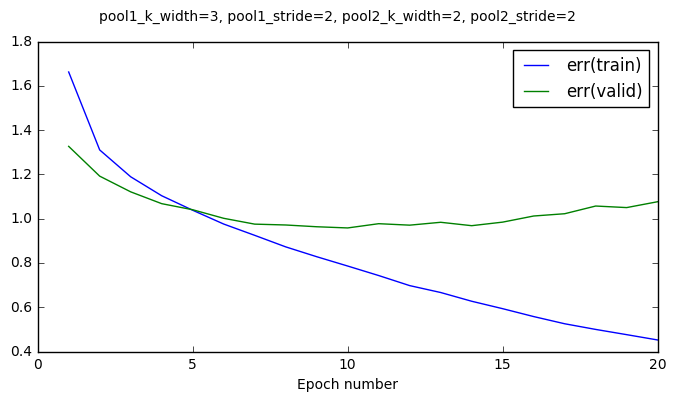

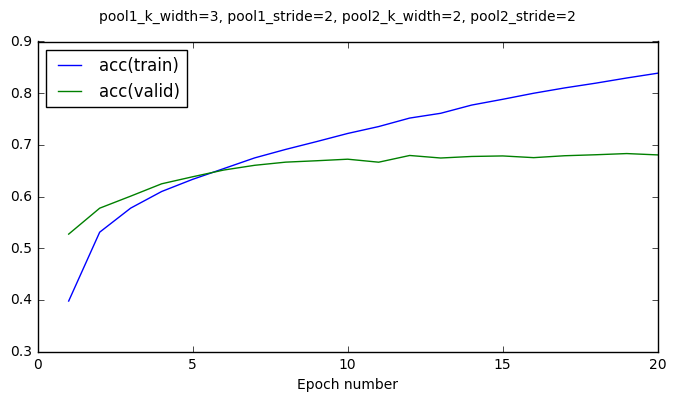

pool1_k_width=2, pool1_stride=2, pool2_k_width=3, pool2_stride=2

End of epoch 01: err(train)=1.74 acc(train)=0.37 err(valid)=1.39 acc(valid)=0.50 time=2.02 min
End of epoch 02: err(train)=1.38 acc(train)=0.51 err(valid)=1.24 acc(valid)=0.56 time=2.00 min
End of epoch 03: err(train)=1.24 acc(train)=0.56 err(valid)=1.16 acc(valid)=0.59 time=2.01 min
End of epoch 04: err(train)=1.15 acc(train)=0.59 err(valid)=1.10 acc(valid)=0.61 time=2.00 min
End of epoch 05: err(train)=1.07 acc(train)=0.62 err(valid)=1.07 acc(valid)=0.63 time=2.00 min
End of epoch 06: err(train)=1.01 acc(train)=0.64 err(valid)=1.03 acc(valid)=0.64 time=1.99 min
End of epoch 07: err(train)=0.95 acc(train)=0.66 err(valid)=1.01 acc(valid)=0.65 time=1.98 min
End of epoch 08: err(train)=0.90 acc(train)=0.68 err(valid)=1.00 acc(valid)=0.65 time=1.99 min
End of epoch 09: err(train)=0.86 acc(train)=0.70 err(valid)=0.99 acc(valid)=0.66 time=1.97 min
End of epoch 10: err(train)=0.81 acc(train)=0.71 err(valid)=1.02 acc(valid)=0.6

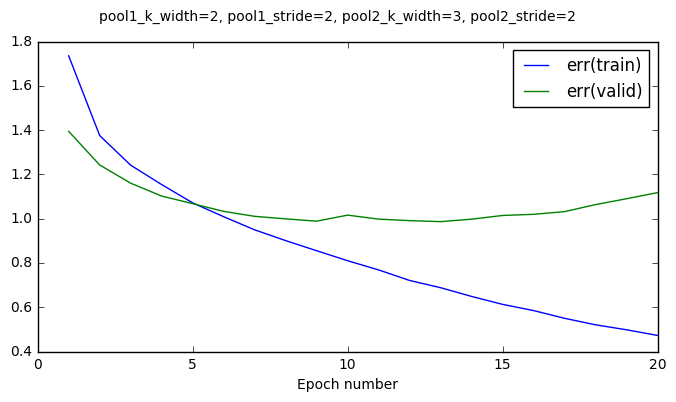

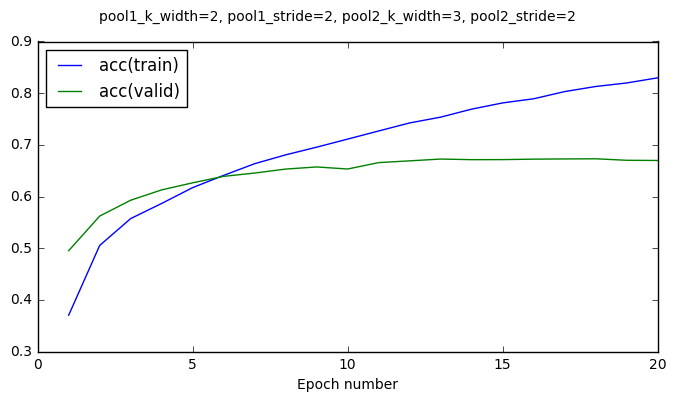

pool1_k_width=2, pool1_stride=1, pool2_k_width=2, pool2_stride=1

End of epoch 01: err(train)=1.47 acc(train)=0.48 err(valid)=1.19 acc(valid)=0.59 time=10.57 min
End of epoch 02: err(train)=1.10 acc(train)=0.61 err(valid)=1.04 acc(valid)=0.64 time=10.47 min
End of epoch 03: err(train)=0.92 acc(train)=0.68 err(valid)=0.97 acc(valid)=0.66 time=10.44 min
End of epoch 04: err(train)=0.76 acc(train)=0.73 err(valid)=0.96 acc(valid)=0.67 time=10.44 min
End of epoch 05: err(train)=0.62 acc(train)=0.78 err(valid)=0.99 acc(valid)=0.67 time=10.45 min
End of epoch 06: err(train)=0.50 acc(train)=0.82 err(valid)=1.03 acc(valid)=0.67 time=10.53 min
End of epoch 07: err(train)=0.38 acc(train)=0.87 err(valid)=1.07 acc(valid)=0.68 time=10.48 min
End of epoch 08: err(train)=0.28 acc(train)=0.90 err(valid)=1.14 acc(valid)=0.69 time=10.43 min
End of epoch 09: err(train)=0.22 acc(train)=0.93 err(valid)=1.24 acc(valid)=0.68 time=10.44 min
End of epoch 10: err(train)=0.19 acc(train)=0.94 err(valid)=1.29 acc(v

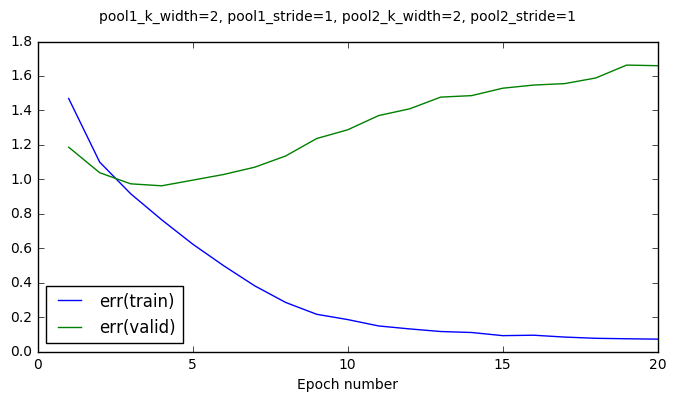

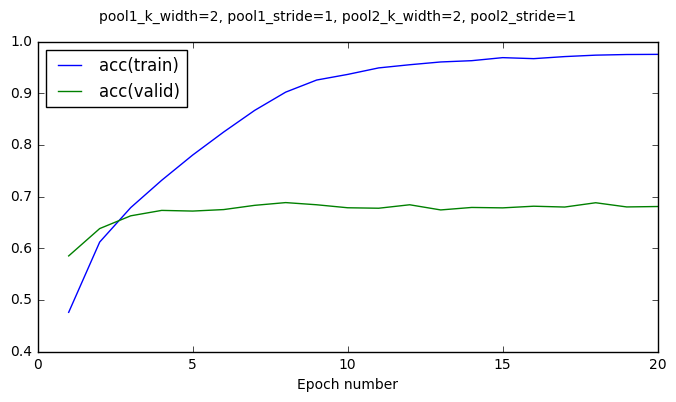

In [78]:
# Create directory (has suffix for today's date).
# Then DELETE all files in path if there are files already there.
subdir = 'cnn_pool_faster'
save_path = create_and_return_path(subdir, save_path_main)
clear_dir(save_path)

# Define hyperparameters
params = {
    'learning_rate': 1e-3,
    'conv1_filter_size': 3,
    'conv1_num_filters': 32,
    'conv1_stride': 1,
    'pool1_k_width': 2,
    'pool1_stride': 2,
    'conv2_filter_size': 3,
    'conv2_num_filters': 64,
    'conv2_stride': 1,
    'pool2_k_width': 2,
    'pool2_stride': 2,
    'fc1_num_outputs': 384,
    'fc2_num_outputs': 192,
    'keep_prob': 0.5,
    'fc_batch_norm': True,
    'conv_batch_norm': False
}

stats = OrderedDict()

num_epoch = 10

iter_vars = make_pool_iter_vars()
iter_strs = make_pool_iter_strs(iter_vars)
if len(iter_vars) != len(iter_strs):
    print 'lengths DO NOT match. Bad!!!'

for iter_var, iter_str in zip(iter_vars, iter_strs):

    print '==========\n{}\n'.format(iter_str)
    stats_one = {'err(train)': [], 'acc(train)': [], 'err(valid)': [], 'acc(valid)': []}
    
    params['pool1_k_width'], params['pool1_stride'], params['pool2_k_width'], params['pool2_stride'] = iter_var
    stats[iter_str] = run_cnn_model(params, save_path)
    
    # Pickle all important objects
    pickle.dump(stats, open(os.path.join(save_path_main, subdir, "stats.p"), "wb"))

path created: run/coursework4/cnn_pool_faster/2017-03-14


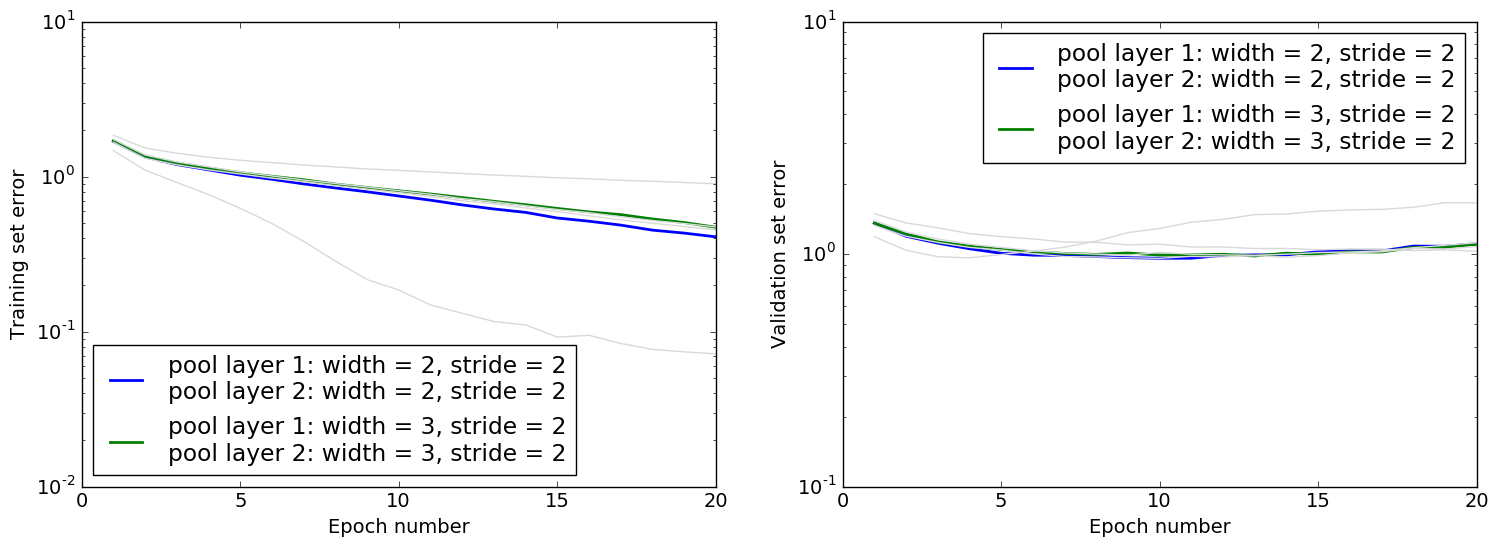

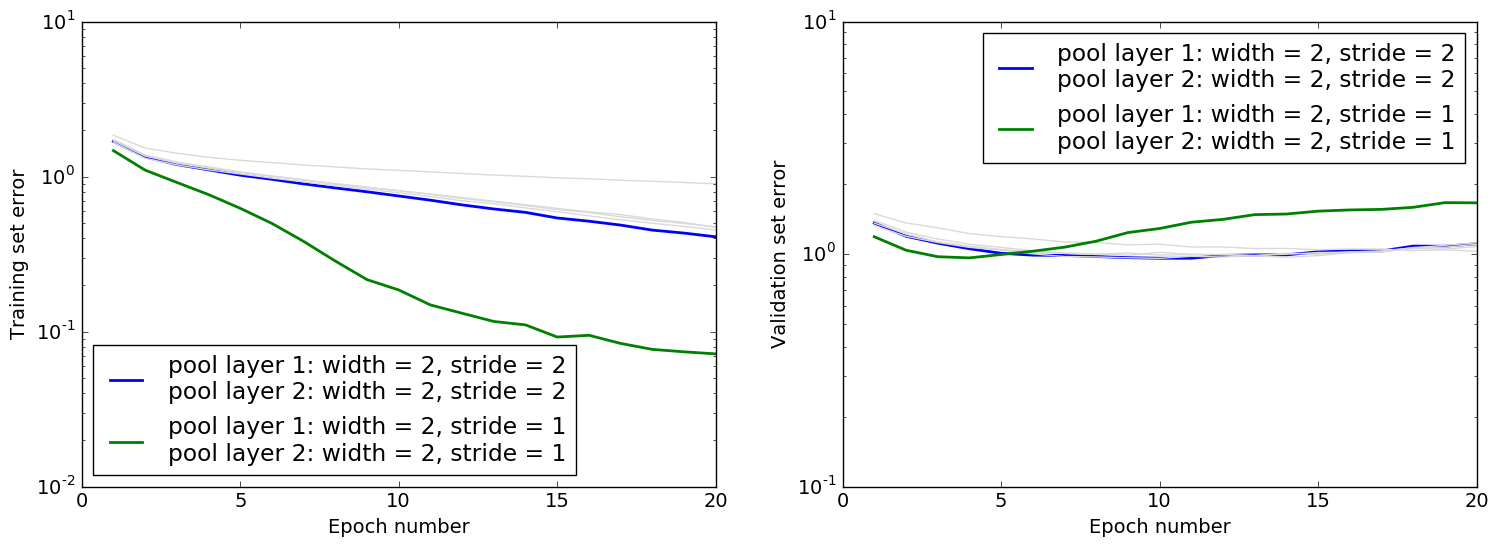

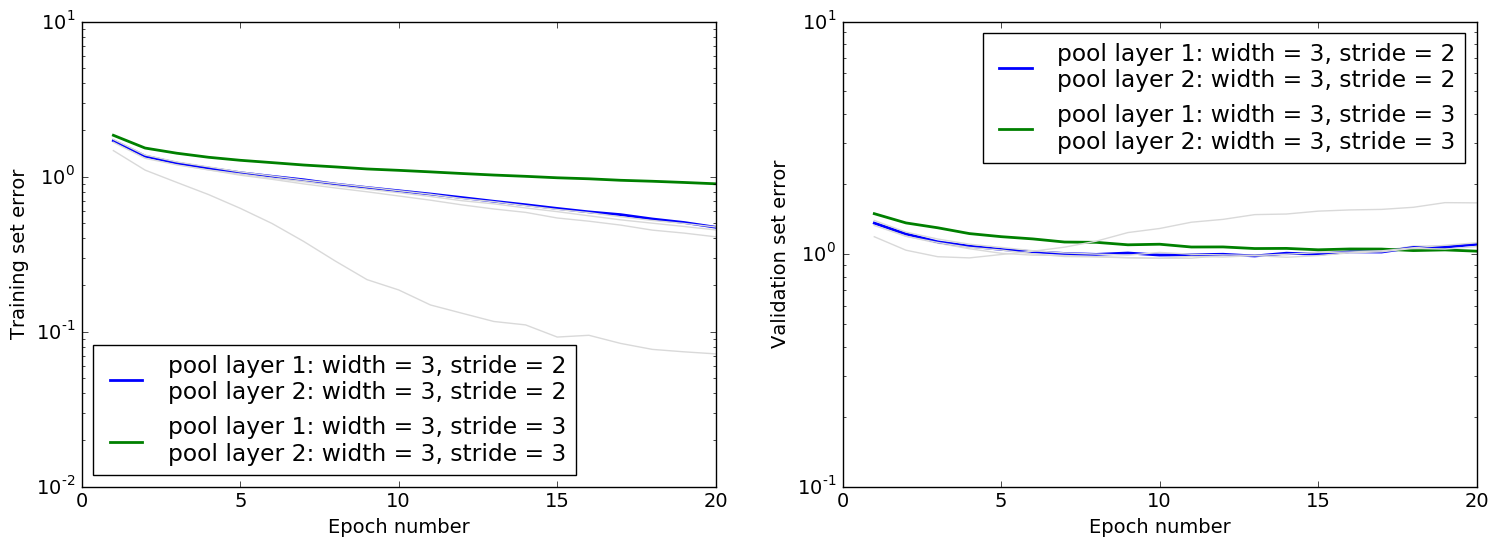

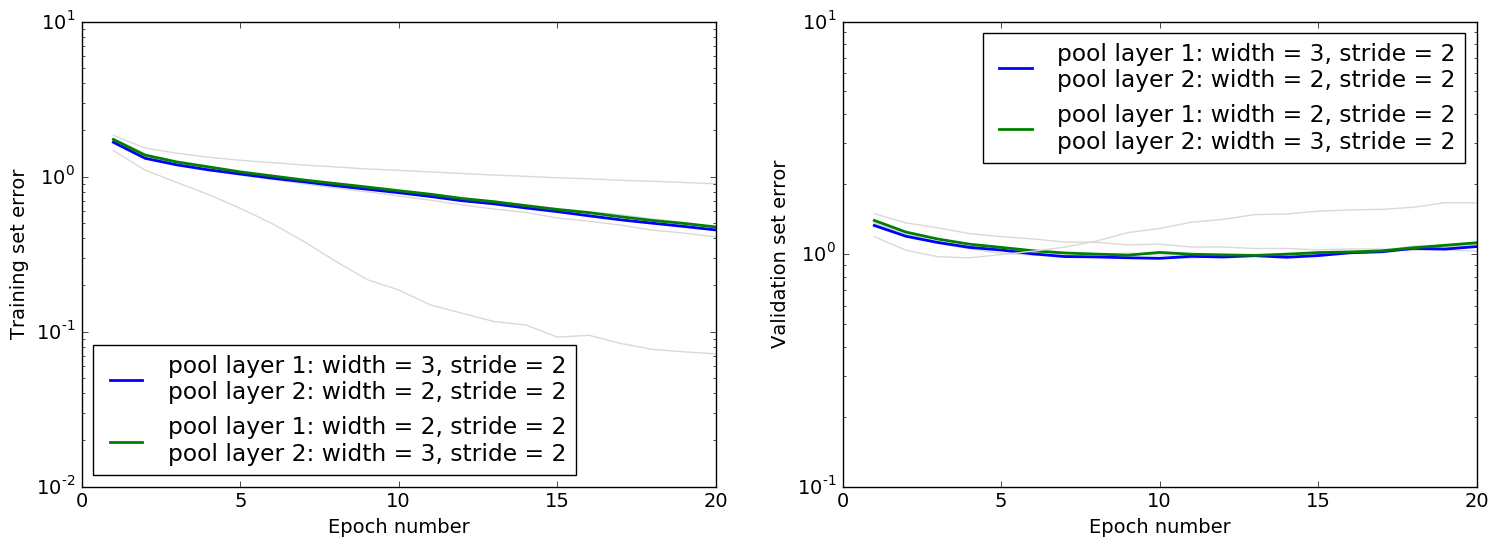

In [82]:
subdir = 'cnn_pool_faster'
save_path = create_and_return_path(subdir, save_path_main)
stats = pickle.load(open(os.path.join(save_path_main, subdir, "stats.p"), "rb"))

# Helper functions.
compare = lambda x, y: collections.Counter(x) == collections.Counter(y)
iterstr2values = lambda iter_str: [int(s) for s in iter_str if s.isdigit()][1::2]
def values2label(values):
    label = ('pool layer 1: width = {}, stride = {}\n' +\
             'pool layer 2: width = {}, stride = {}').format(*values)
    return label
iterstr2label = lambda iter_str: values2label(iterstr2values(iter_str))
values2short = lambda values: ''.join(str(v) for v in values)

iters_to_compare_list = [
    [[2, 2, 2, 2], [3, 2, 3, 2]],
    [[2, 2, 2, 2], [2, 1, 2, 1]],
    [[3, 2, 3, 2], [3, 3, 3, 3]],
    [[3, 2, 2, 2], [2, 2, 3, 2]]
]

for iters_to_compare in iters_to_compare_list:

    # Plot stuff. Can't use default b/c there are too many lines.
    fig = plt.figure(figsize=(18, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    for iter_str, stats_sub in stats.iteritems():
        values = [int(s) for s in iter_str if s.isdigit()][1::2]
        if any(compare(values, v) for v in iters_to_compare):
            color = None
            label = values2label(values)
            linewidth = 2
        else:
            color = '0.85'
            label = None
            linewidth = None
        num_epoch = len(stats_sub.values()[0])
        ax1.plot(np.arange(1, num_epoch + 1), 
                 stats_sub['err(train)'], linewidth=linewidth, color=color, label=label)
        ax2.plot(np.arange(1, num_epoch + 1), 
                 stats_sub['err(valid)'], linewidth=linewidth, color=color, label=label)
    ax1.legend(loc=0)
    ax1.set_xlabel('Epoch number')
    ax1.set_ylabel('Training set error')
    ax1.set_yscale('log')
    ax2.legend(loc=0)
    ax2.set_xlabel('Epoch number')
    ax2.set_ylabel('Validation set error')
    ax2.set_yscale('log')
    
    with plt.rc_context(rc={'text.usetex': False}):
        plt.savefig(os.path.join(save_path, 'cnn_pool_{}-{}.pdf'.format(*[values2short(v) for v in iters_to_compare])))

path created: run/coursework4/cifar100/2017-03-16
deleting files in: run/coursework4/cifar100/2017-03-16
cifar100

End of epoch 01: err(train)=3.98 acc(train)=0.10 err(valid)=3.43 acc(valid)=0.19 time=3.36 min
End of epoch 02: err(train)=3.32 acc(train)=0.20 err(valid)=3.10 acc(valid)=0.25 time=3.42 min
End of epoch 03: err(train)=3.02 acc(train)=0.26 err(valid)=2.88 acc(valid)=0.29 time=2.99 min
End of epoch 04: err(train)=2.82 acc(train)=0.30 err(valid)=2.76 acc(valid)=0.31 time=2.90 min
End of epoch 05: err(train)=2.64 acc(train)=0.33 err(valid)=2.67 acc(valid)=0.33 time=2.87 min
End of epoch 06: err(train)=2.49 acc(train)=0.36 err(valid)=2.63 acc(valid)=0.34 time=2.31 min
End of epoch 07: err(train)=2.36 acc(train)=0.39 err(valid)=2.57 acc(valid)=0.36 time=2.42 min
End of epoch 08: err(train)=2.23 acc(train)=0.42 err(valid)=2.56 acc(valid)=0.36 time=2.14 min
End of epoch 09: err(train)=2.11 acc(train)=0.44 err(valid)=2.57 acc(valid)=0.36 time=2.19 min
End of epoch 10: err(train)=2.

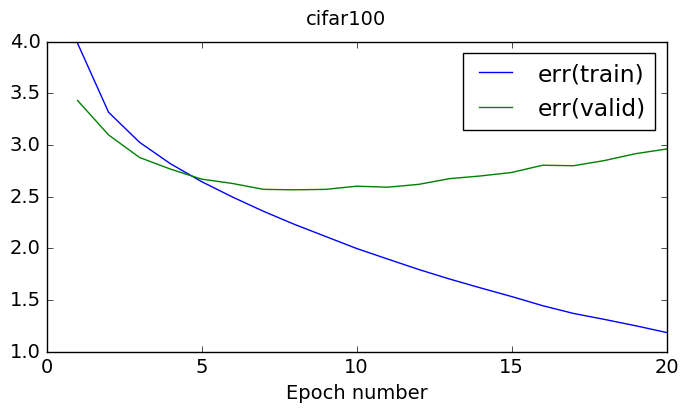

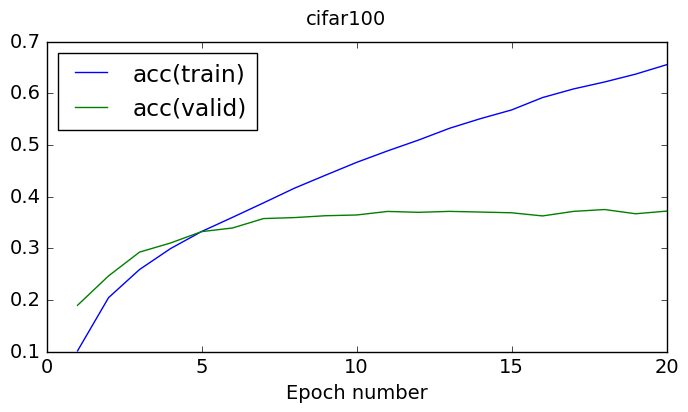

In [81]:
# Create directory (has suffix for today's date).
# Then DELETE all files in path if there are files already there.
subdir = 'cifar100'
save_path = create_and_return_path(subdir, save_path_main)
clear_dir(save_path)

use_cifar_10 = False

if use_cifar_10:
    train_data = CIFAR10DataProvider('train', batch_size=batch_size)
    valid_data = CIFAR10DataProvider('valid', batch_size=batch_size)
else:
    train_data = CIFAR100DataProvider('train', batch_size=batch_size)
    valid_data = CIFAR100DataProvider('valid', batch_size=batch_size)

for input_batch, target_batch in train_data:
    num_classes = target_batch.shape[1]
    break

# Define hyperparameters
params = {
    'learning_rate': 1e-3,
    'conv1_filter_size': 3,
    'conv1_num_filters': 32,
    'conv1_stride': 1,
    'pool1_k_width': 2,
    'pool1_stride': 2,
    'conv2_filter_size': 3,
    'conv2_num_filters': 64,
    'conv2_stride': 1,
    'pool2_k_width': 2,
    'pool2_stride': 2,
    'fc1_num_outputs': 384,
    'fc2_num_outputs': 192,
    'keep_prob': 0.5,
    'fc_batch_norm': True,
    'conv_batch_norm': False
}

stats = OrderedDict()

num_epoch = 20

iter_vars = [None]
iter_strs = ['cifar100']
# if len(iter_vars) != len(iter_strs):
#     print 'lengths DO NOT match. Bad!!!'

for iter_var, iter_str in zip(iter_vars, iter_strs):

    print '==========\n{}\n'.format(iter_str)
    stats_one = {'err(train)': [], 'acc(train)': [], 'err(valid)': [], 'acc(valid)': []}
    
    stats[iter_str] = run_cnn_model(params, save_path)
    
    # Pickle all important objects
    pickle.dump(stats, open(os.path.join(save_path_main, subdir, "stats.p"), "wb"))


use_cifar_10 = True

if use_cifar_10:
    train_data = CIFAR10DataProvider('train', batch_size=batch_size)
    valid_data = CIFAR10DataProvider('valid', batch_size=batch_size)
else:
    train_data = CIFAR100DataProvider('train', batch_size=batch_size)
    valid_data = CIFAR100DataProvider('valid', batch_size=batch_size)

for input_batch, target_batch in train_data:
    num_classes = target_batch.shape[1]
    break

path created: run/coursework4/cifar100/2017-03-16
CIFAR-100 (Coursework 4) 0.37480000101
CIFAR-100 (Coursework 3) 0.187400000524
CIFAR-10 (Coursework 4) 0.598800004274


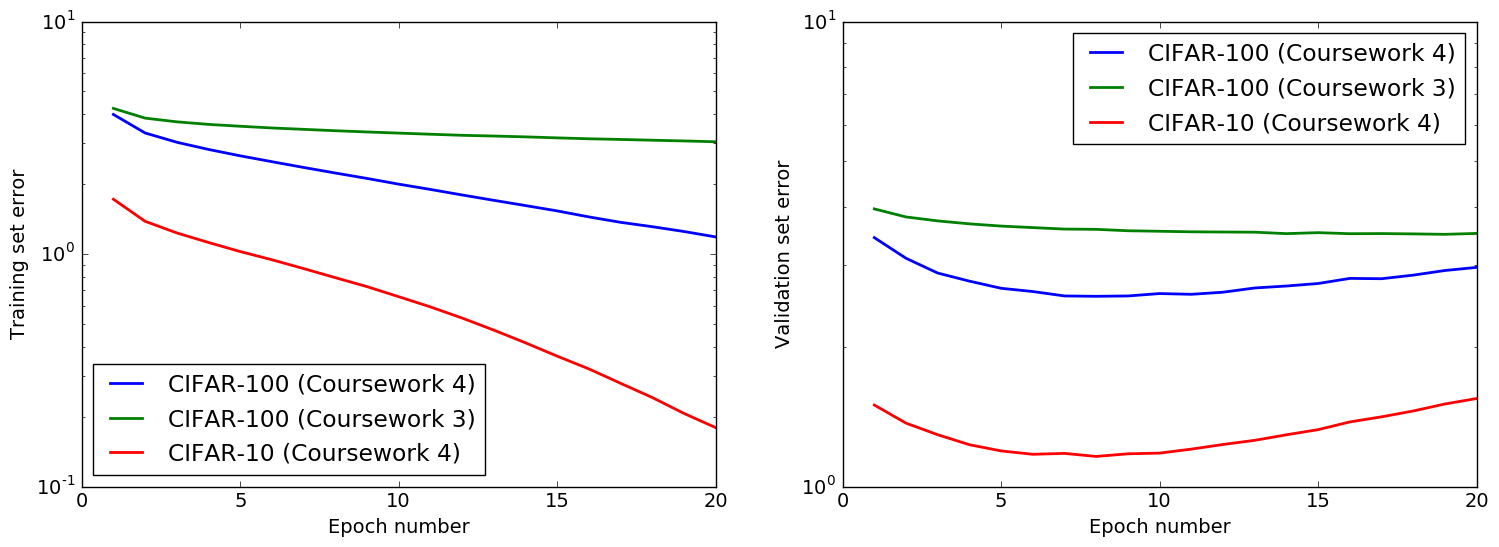

In [92]:
# Get stats from end of CW3 to compare with new CNN architecture.
stats_batch_norm = pickle.load(open(os.path.join(save_path_main, 'cnn_batch_norm', 'stats.p'), 'rb'))
stats_cifar100 = pickle.load(open(os.path.join(save_path_main, 'cifar100', 'stats.p'), 'rb'))
stats_cifar100_cw3 = pickle.load(open(os.path.join('/Users/sipola/Google Drive/mlpractical/run/coursework3/cifar-100', 'stats.p'), 'rb'))

# Manucally create stats object.
stats = {}
stats['CIFAR-10 (Coursework 4)'] = stats_batch_norm['fc_batch_norm=True, conv_batch_norm=False']
stats['CIFAR-100 (Coursework 4)'] = stats_cifar100['cifar100']
stats['CIFAR-100 (Coursework 3)'] = stats_cifar100_cw3['']

subdir = 'cifar100'
save_path = create_and_return_path(subdir, save_path_main)
iter_graph(stats, os.path.join(save_path, 'cifar100.pdf'))

for iter_str, values in stats.iteritems():
    print iter_str, max(values['acc(valid)'])

# Play around with stats for paper

In [99]:
last = lambda x: x[-1]
self = lambda x: x
print_stats('cnn_pool_faster', 'err(valid)', min)  # stats_key can be, for example, 'err(valid)' or 'acc(train)'

pool1_k_width=2, pool1_stride=2, pool2_k_width=2, pool2_stride=2 0.958566103876
pool1_k_width=3, pool1_stride=2, pool2_k_width=3, pool2_stride=2 0.98053581059
pool1_k_width=3, pool1_stride=3, pool2_k_width=3, pool2_stride=3 1.02838530391
pool1_k_width=3, pool1_stride=2, pool2_k_width=2, pool2_stride=2 0.958010488749
pool1_k_width=2, pool1_stride=2, pool2_k_width=3, pool2_stride=2 0.986479557306
pool1_k_width=2, pool1_stride=1, pool2_k_width=2, pool2_stride=1 0.962143086791
